# using LSTM

In [1]:
# Importing Libraries

In [2]:
import pandas as pd
import numpy as np

In [38]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

In [39]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Data

In [4]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [7]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [8]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        signals_data.append(
            _read_csv(filename).as_matrix()
        ) 

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [9]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]

    return pd.get_dummies(y).as_matrix()

In [10]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [11]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.set_random_seed(42)

In [12]:
# Configuring a session
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [13]:
# Import Keras
from keras import backend as K
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

Using TensorFlow backend.


In [54]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [15]:
# Initializing parameters
epochs = 20
batch_size = 16
n_hidden = 32

In [16]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [17]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [18]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


- Defining the Architecture of LSTM

In [19]:
#http://maxpumperla.com/hyperas/
'''
from __future__ import print_function
import numpy as np

from hyperopt import Trials, STATUS_OK, tpe
from keras.datasets import mnist
from keras.layers.core import Dense, Dropout, Activation
from keras.models import Sequential
from keras.utils import np_utils

from hyperas import optim
from hyperas.distributions import choice, uniform


def create_model(X_train, y_train, X_test, y_test):
    
    epochs = 8
    batch_size = 32
    timesteps = x_train.shape[1]
    input_dim = len(x_train[0][0])
    n_classes = 6
    
    model = Sequential()
    
    model.add(LSTM({{choice([64,32, 16])}}, return_sequences = True, input_shape = (timesteps, input_dim)))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(LSTM({{choice([32, 16])}}))
    model.add(Dropout({{uniform(0, 1)}}))
    
    model.add(Dense(n_classes, activation='sigmoid'))
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='rmsprop')
    
    result = model.fit(X_train, y_train, batch_size = batch_size, epochs=epochs, verbose=2, validation_split=0.01)
    
    validation_acc = np.amax(result.history['val_acc']) 
    
    print('Best validation acc of epoch:', validation_acc)
    
    return {'loss': -validation_acc, 'status': STATUS_OK, 'model': model}'''

"\nfrom __future__ import print_function\nimport numpy as np\n\nfrom hyperopt import Trials, STATUS_OK, tpe\nfrom keras.datasets import mnist\nfrom keras.layers.core import Dense, Dropout, Activation\nfrom keras.models import Sequential\nfrom keras.utils import np_utils\n\nfrom hyperas import optim\nfrom hyperas.distributions import choice, uniform\n\n\ndef create_model(X_train, y_train, X_test, y_test):\n    \n    epochs = 8\n    batch_size = 32\n    timesteps = x_train.shape[1]\n    input_dim = len(x_train[0][0])\n    n_classes = 6\n    \n    model = Sequential()\n    \n    model.add(LSTM({{choice([64,32, 16])}}, return_sequences = True, input_shape = (timesteps, input_dim)))\n    model.add(Dropout({{uniform(0, 1)}}))\n    \n    model.add(LSTM({{choice([32, 16])}}))\n    model.add(Dropout({{uniform(0, 1)}}))\n    \n    model.add(Dense(n_classes, activation='sigmoid'))\n    \n    print(model.summary())\n    \n    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], opt

In [20]:
'''best_run, best_model = optim.minimize(model=create_model, data=load_data(), algo=tpe.suggest, max_evals=4, trials=Trials())
X_train, y_train, X_test, y_test = load_data()

score = best_model.evaluate(X_test, y_test)

print('---------------------')
print('|      Accuracy      |')
print('---------------------')
acc = np.round((score[1]*100), 2)
print(str(acc)+"%\n")
    
print('----------------------------------')
print('|      Best Hyper-Parameters      |')
print('----------------------------------')
print(best_run)
print("\n\n")

true_labels = [np.argmax(i)+1 for i in y_test]
predicted_probs = best_model.predict(X_test)
predicted_labels = [np.argmax(i)+1 for i in predicted_probs]
print_confusionMatrix(true_labels, predicted_labels)'''

'best_run, best_model = optim.minimize(model=create_model, data=load_data(), algo=tpe.suggest, max_evals=4, trials=Trials())\nX_train, y_train, X_test, y_test = load_data()\n\nscore = best_model.evaluate(X_test, y_test)\n\nprint(\'---------------------\')\nprint(\'|      Accuracy      |\')\nprint(\'---------------------\')\nacc = np.round((score[1]*100), 2)\nprint(str(acc)+"%\n")\n    \nprint(\'----------------------------------\')\nprint(\'|      Best Hyper-Parameters      |\')\nprint(\'----------------------------------\')\nprint(best_run)\nprint("\n\n")\n\ntrue_labels = [np.argmax(i)+1 for i in y_test]\npredicted_probs = best_model.predict(X_test)\npredicted_labels = [np.argmax(i)+1 for i in predicted_probs]\nprint_confusionMatrix(true_labels, predicted_labels)'

# Model1: 1 LSTM with 32 hidden unit , rmsprop optimizer

In [19]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

W0626 22:24:19.299101  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0626 22:24:19.305118  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0626 22:24:19.308441  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0626 22:24:19.699645  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0626 22:24:19

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

W0626 22:24:23.850056  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0626 22:24:23.889933  6868 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [21]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

W0626 22:24:25.472001  6868 deprecation.py:323] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 77s 10ms/step - loss: 1.3207 - acc: 0.4329 - val_loss: 1.1474 - val_acc: 0.4706
Epoch 2/30
7352/7352 [==============================] - 72s 10ms/step - loss: 0.9877 - acc: 0.5702 - val_loss: 1.0286 - val_acc: 0.5046
Epoch 3/30
7352/7352 [==============================] - 74s 10ms/step - loss: 0.7947 - acc: 0.6477 - val_loss: 0.7681 - val_acc: 0.6074
Epoch 4/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.6952 - acc: 0.6578 - val_loss: 0.7221 - val_acc: 0.6060
Epoch 5/30
7352/7352 [==============================] - 73s 10ms/step - loss: 0.6491 - acc: 0.6802 - val_loss: 0.7290 - val_acc: 0.6169
Epoch 6/30
7352/7352 [==============================] - 64s 9ms/step - loss: 0.6374 - acc: 0.6857 - val_loss: 1.2811 - val_acc: 0.5877
Epoch 7/30
7352/7352 [==============================] - 65s 9ms/step - loss: 0.6218 - acc: 0.7231 - val_loss: 0.6598 - val_acc: 0.7194
Ep

Test Score: 0.431993
Test Accuracy: 89.379030%


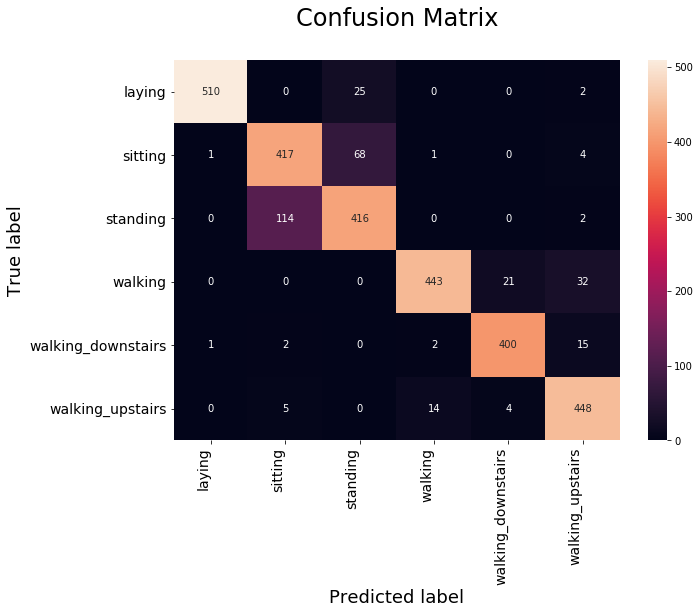

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

- With a simple 1 layer architecture we got 89.34% accuracy and a loss of 0.43
- We can further imporve the performace with Hyperparameter tuning

# Model2: 1 LSTM with 64 hodden unit , adam optimizer

In [24]:
# Initiliazing the sequential model
model2 = Sequential()
# Configuring the parameters
model2.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model2.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model2.add(Dense(n_classes, activation='sigmoid'))
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [25]:
# Compiling the model
model2.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training the model
model2.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)




Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 73s 10ms/step - loss: 1.4055 - acc: 0.3928 - val_loss: 1.2250 - val_acc: 0.4326
Epoch 2/20
7352/7352 [==============================] - 73s 10ms/step - loss: 1.2155 - acc: 0.4698 - val_loss: 1.2551 - val_acc: 0.5151
Epoch 3/20
7352/7352 [==============================] - 71s 10ms/step - loss: 1.0704 - acc: 0.5320 - val_loss: 1.0345 - val_acc: 0.4930
Epoch 4/20
7352/7352 [==============================] - 75s 10ms/step - loss: 1.0918 - acc: 0.5222 - val_loss: 1.2427 - val_acc: 0.5134
Epoch 5/20
7352/7352 [==============================] - 74s 10ms/step - loss: 1.1104 - acc: 0.5144 - val_loss: 0.8929 - val_acc: 0.5870
Epoch 6/20
7352/7352 [==============================] - 73s 10ms/step - loss: 0.8779 - acc: 0.6009 - val_loss: 0.8901 - val_acc: 0.5657
Epoch 7/20
7352/7352 [==============================] - 80s 11ms/step - loss: 0.8381 - acc: 0.6034 - val_loss: 0.9905 - val_acc: 0.5704


Test Score: 0.916506
Test Accuracy: 65.218867%


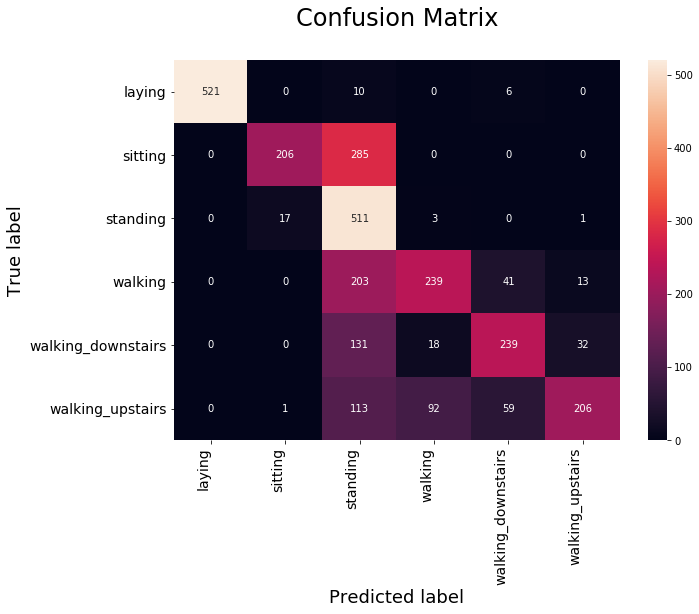

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model2.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model2.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

it is seen that when i decrease opochs value from 30 to 20, accuracy decrease drastically.

loss also increase significantly in 1 LSTM model

# Model3: 1 LSTM with 64 hodden unit , rmsprop optimizer

In [27]:
# Initiliazing the sequential model
model3 = Sequential()
# Configuring the parameters
model3.add(LSTM(64, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model3.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model3.add(Dense(n_classes, activation='sigmoid'))
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                18944     
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 390       
Total params: 19,334
Trainable params: 19,334
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Compiling the model
model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model3.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)


Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 76s 10ms/step - loss: 1.2690 - acc: 0.4430 - val_loss: 1.0997 - val_acc: 0.5324
Epoch 2/20
7352/7352 [==============================] - 69s 9ms/step - loss: 0.9841 - acc: 0.5680 - val_loss: 0.8458 - val_acc: 0.6491
Epoch 3/20
7352/7352 [==============================] - 70s 10ms/step - loss: 0.8499 - acc: 0.6334 - val_loss: 1.0590 - val_acc: 0.5127
Epoch 4/20
7352/7352 [==============================] - 72s 10ms/step - loss: 0.6973 - acc: 0.7001 - val_loss: 0.7259 - val_acc: 0.7038
Epoch 5/20
7352/7352 [==============================] - 75s 10ms/step - loss: 0.5915 - acc: 0.7455 - val_loss: 0.5523 - val_acc: 0.7608
Epoch 6/20
7352/7352 [==============================] - 71s 10ms/step - loss: 0.4976 - acc: 0.8048 - val_loss: 0.5066 - val_acc: 0.8001
Epoch 7/20
7352/7352 [==============================] - 70s 10ms/step - loss: 0.3891 - acc: 0.8637 - val_loss: 0.4102 - val_acc: 0.8578
E

Test Score: 0.466954
Test Accuracy: 89.820156%


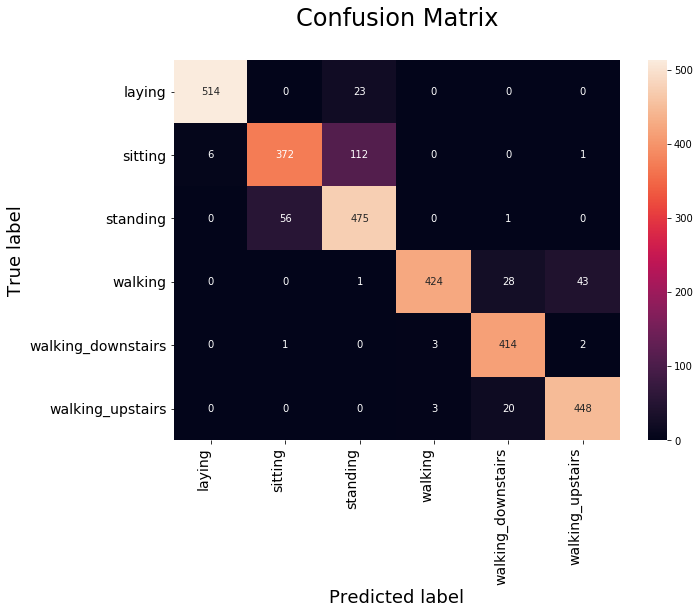

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model3.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model3.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

RMSProp optimizer is suitable for this problem. accuracy again reach to 89%

loss also decrease from 0.9 to 0.46

let check with 2 LSTM network...

# Model4: 2 LSTM with 32 hidden unit , adam optimizer

In [30]:
# Initiliazing the sequential model
model4 = Sequential()
# Configuring the parameters
model4.add(LSTM(32,return_sequences=True, input_shape=(timesteps, input_dim)))
model4.add(Dropout(0.5))

# Configuring the parameters
model4.add(LSTM(32))
model4.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model4.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
# Compiling the model
model4.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training the model
model4.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 137s 19ms/step - loss: 1.2312 - acc: 0.4869 - val_loss: 0.9302 - val_acc: 0.6210
Epoch 2/20
7352/7352 [==============================] - 130s 18ms/step - loss: 0.8336 - acc: 0.6080 - val_loss: 0.7768 - val_acc: 0.6206
Epoch 3/20
7352/7352 [==============================] - 5732s 780ms/step - loss: 0.7795 - acc: 0.6174 - val_loss: 0.7749 - val_acc: 0.6430
Epoch 4/20
7352/7352 [==============================] - 129s 18ms/step - loss: 0.8037 - acc: 0.6049 - val_loss: 0.7544 - val_acc: 0.5969
Epoch 5/20
7352/7352 [==============================] - 1588s 216ms/step - loss: 0.7207 - acc: 0.6138 - val_loss: 0.6889 - val_acc: 0.6125
Epoch 6/20
7352/7352 [==============================] - 120s 16ms/step - loss: 0.7499 - acc: 0.5962 - val_loss: 0.7753 - val_acc: 0.5419
Epoch 7/20
7352/7352 [==============================] - 134s 18ms/step - loss: 0.7406 - acc: 0.5967 - val_loss: 0.7400 - val_a

Test Score: 0.461573
Test Accuracy: 86.257211%


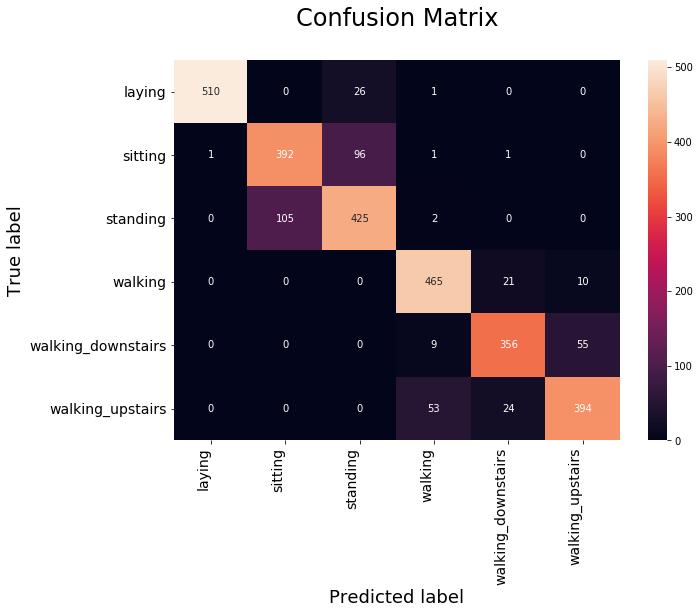

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model4.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model4.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

# Model5: 2 LSTM with 64 hidden unit , adam optimizer

In [33]:
# Initiliazing the sequential model
model5 = Sequential()
# Configuring the parameters
model5.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
model5.add(Dropout(0.5))

# Configuring the parameters
model5.add(LSTM(32))
model5.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model5.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
# Compiling the model
model5.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Training the model
model5.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 134s 18ms/step - loss: 1.4015 - acc: 0.4169 - val_loss: 1.2836 - val_acc: 0.4564
Epoch 2/20
7352/7352 [==============================] - 128s 17ms/step - loss: 1.2390 - acc: 0.4407 - val_loss: 1.2479 - val_acc: 0.4164
Epoch 3/20
7352/7352 [==============================] - 125s 17ms/step - loss: 1.2551 - acc: 0.4348 - val_loss: 1.4182 - val_acc: 0.3488
Epoch 4/20
7352/7352 [==============================] - 120s 16ms/step - loss: 1.1706 - acc: 0.4937 - val_loss: 1.0925 - val_acc: 0.5643
Epoch 5/20
7352/7352 [==============================] - 127s 17ms/step - loss: 0.9595 - acc: 0.5817 - val_loss: 1.3757 - val_acc: 0.4147
Epoch 6/20
7352/7352 [==============================] - 154s 21ms/step - loss: 1.0993 - acc: 0.5267 - val_loss: 0.9664 - val_acc: 0.5711
Epoch 7/20
7352/7352 [==============================] - 146s 20ms/step - loss: 0.9192 - acc: 0.6043 - val_loss: 1.1931 - val_acc: 

Test Score: 0.707013
Test Accuracy: 62.538174%


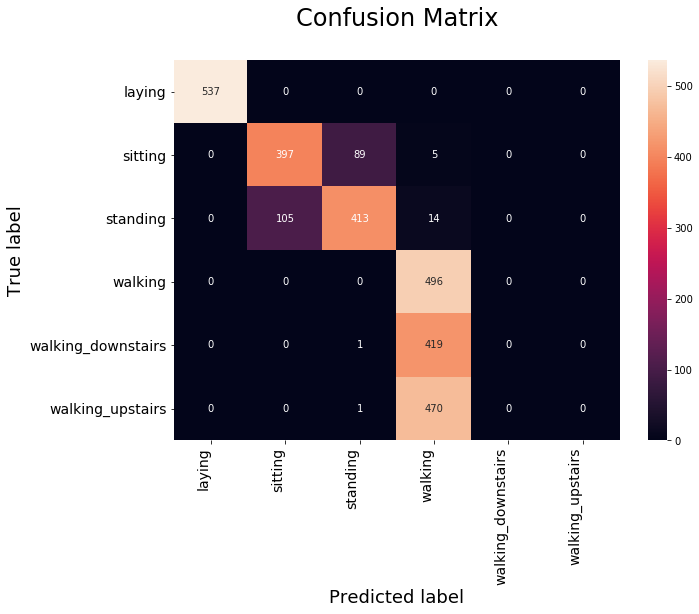

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model5.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model5.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

In [55]:
# Importing libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout


K.clear_session()
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total para

In [25]:
import math
import keras
import numpy as np
import tensorflow as tf
import random as rn
adam = keras.optimizers.Adam(lr=0.001)

In [27]:
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train,Y_train, epochs=20, batch_size=16,validation_data=(X_test, Y_test), verbose=1)

ValueError: Error when checking target: expected dense_2 to have shape (2,) but got array with shape (6,)

# Model6: 2 LSTM with 64 hidden unit , rmsprop optimizer

In [36]:
# Initiliazing the sequential model
model6 = Sequential()
# Configuring the parameters
model6.add(LSTM(64,return_sequences=True, input_shape=(timesteps, input_dim)))
model6.add(Dropout(0.5))

# Configuring the parameters
model6.add(LSTM(32))
model6.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model6.add(Dense(n_classes, activation='sigmoid'))
print(model4.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 128, 32)           5376      
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 198       
Total params: 13,894
Trainable params: 13,894
Non-trainable params: 0
_________________________________________________________________
None


In [37]:
# Compiling the model
model6.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training the model
model6.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 134s 18ms/step - loss: 1.2233 - acc: 0.4961 - val_loss: 0.9743 - val_acc: 0.5986
Epoch 2/20
7352/7352 [==============================] - 130s 18ms/step - loss: 0.8135 - acc: 0.6517 - val_loss: 0.7748 - val_acc: 0.7197
Epoch 3/20
7352/7352 [==============================] - 128s 17ms/step - loss: 0.6675 - acc: 0.7274 - val_loss: 0.6315 - val_acc: 0.7913
Epoch 4/20
7352/7352 [==============================] - 135s 18ms/step - loss: 0.4925 - acc: 0.8443 - val_loss: 0.5876 - val_acc: 0.8005
Epoch 5/20
7352/7352 [==============================] - 121s 16ms/step - loss: 0.3329 - acc: 0.9048 - val_loss: 0.4312 - val_acc: 0.8663
Epoch 6/20
7352/7352 [==============================] - 125s 17ms/step - loss: 0.2665 - acc: 0.9253 - val_loss: 0.3789 - val_acc: 0.8873
Epoch 7/20
7352/7352 [==============================] - 122s 17ms/step - loss: 0.2311 - acc: 0.9271 - val_loss: 0.4710 - val_acc: 

Test Score: 0.451065
Test Accuracy: 90.634544%


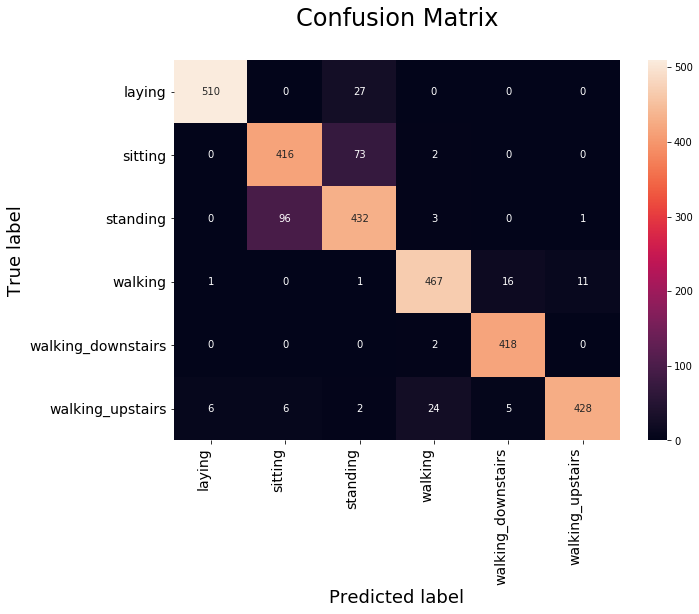

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Final evaluation of the model
scores = model6.evaluate(X_test, Y_test, verbose=0)
print("Test Score: %f" % (scores[0]))
print("Test Accuracy: %f%%" % (scores[1]*100))

# Confusion Matrix
Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_test, axis=1)])
Y_predictions = pd.Series([ACTIVITIES[y] for y in np.argmax(model6.predict(X_test), axis=1)])

# Code for drawing seaborn heatmaps
class_names = ['laying','sitting','standing','walking','walking_downstairs','walking_upstairs']
df_heatmap = pd.DataFrame(confusion_matrix(Y_true, Y_predictions), index=class_names, columns=class_names )
fig = plt.figure(figsize=(10,7))
heatmap = sns.heatmap(df_heatmap, annot=True, fmt="d")

# Setting tick labels for heatmap
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=14)
plt.ylabel('True label',size=18)
plt.xlabel('Predicted label',size=18)
plt.title("Confusion Matrix\n",size=24)
plt.show()

Observation:
    
    test accuracy reach upto 90.0 % with 2 LSTM Layer and rmsprop optimizer.
    
    loss is 0.45.

# Using CNN

 - CNN are useful to get best features and realtions between sequnce data using convolution.

In [4]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import tensorflow as tf
import random as rn
np.random.seed(36)
rn.seed(36)
tf.set_random_seed(36)
# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(36)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [56]:
# Importing libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [6]:
##gives train and validation data 
def data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        return pd.get_dummies(y).as_matrix()
    
    X_train, X_val = load_signals('train'), load_signals('test')
    Y_train, Y_val = load_y('train'), load_y('test')

    return X_train, Y_train, X_val,  Y_val

In [34]:
X_train, Y_train, X_val, Y_val = data()

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [35]:
###Scling data
from sklearn.base import BaseEstimator, TransformerMixin
class scaling_tseries_data(BaseEstimator, TransformerMixin):
    from sklearn.preprocessing import StandardScaler
    def __init__(self):
        self.scale = None

    def transform(self, X):
        temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
        temp_X1 = self.scale.transform(temp_X1)
        return temp_X1.reshape(X.shape)

    def fit(self, X):
        # remove overlaping
        remove = int(X.shape[1] / 2)
        temp_X = X[:, -remove:, :]
        # flatten data
        temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
        scale = StandardScaler()
        scale.fit(temp_X)
        self.scale = scale
        return self

In [36]:
Scale = scaling_tseries_data()
Scale.fit(X_train)
X_train_sc = Scale.transform(X_train)
X_val_sc = Scale.transform(X_val)

In [37]:
print('Shape of scaled X train',X_train_sc.shape)
print('Shape of scaled X test',X_val_sc.shape)

Shape of scaled X train (7352, 128, 9)
Shape of scaled X test (2947, 128, 9)


In [38]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

W0728 00:13:24.345396 18200 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_2 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 306       
Total para

In [39]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.fit(X_train_sc,Y_train, epochs=30, batch_size=16,validation_data=(X_val_sc, Y_val), verbose=1)

W0728 00:14:21.040678 18200 deprecation.py:323] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 11s 2ms/step - loss: 0.4758 - acc: 0.8126 - val_loss: 0.3243 - val_acc: 0.8812
Epoch 2/30
7352/7352 [==============================] - 8s 1ms/step - loss: 0.1452 - acc: 0.9382 - val_loss: 0.2754 - val_acc: 0.9050
Epoch 3/30
7352/7352 [==============================] - 7s 1ms/step - loss: 0.1084 - acc: 0.9513 - val_loss: 0.2803 - val_acc: 0.9080
Epoch 4/30
7352/7352 [==============================] - 7s 1ms/step - loss: 0.1042 - acc: 0.9546 - val_loss: 0.2464 - val_acc: 0.9226
Epoch 5/30
7352/7352 [==============================] - 7s 956us/step - loss: 0.1042 - acc: 0.9580 - val_loss: 0.2154 - val_acc: 0.9287
Epoch 6/30
7352/7352 [==============================] - 7s 963us/step - loss: 0.0900 - acc: 0.9607 - val_loss: 0.2656 - val_acc: 0.9148
Epoch 7/30
7352/7352 [==============================] - 7s 966us/step - loss: 0.0768 - acc: 0.9655 - val_loss: 0.2896 - val_acc: 0.9182
Epoch 8

it is giving some good score in train as well as test but it is overfitting so much. i will try some regularization in below models.

In [57]:
from keras.regularizers import l2,l1
import keras
from keras.layers import BatchNormalization

In [42]:
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',
                 kernel_regularizer=l2(0.1),input_shape=(128,9)))
model.add(Conv1D(filters=16, kernel_size=3, activation='relu',kernel_regularizer=l2(0.06),kernel_initializer='he_uniform'))
model.add(Dropout(0.65))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(6, activation='softmax'))
model.summary()

W0728 00:18:05.307078 18200 nn_ops.py:4224] Large dropout rate: 0.65 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 124, 16)           1552      
_________________________________________________________________
dropout_3 (Dropout)          (None, 124, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 62, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 992)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                31776     
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 198       
Total para

In [43]:
import math
adam = keras.optimizers.Adam(lr=0.001)
rmsprop = keras.optimizers.RMSprop(lr=0.001)
def step_decay(epoch):
    return float(0.001 * math.pow(0.6, math.floor((1+epoch)/10)))
from keras.callbacks import LearningRateScheduler
lrate = LearningRateScheduler(step_decay)
callbacks_list = [lrate]

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [44]:
model.fit(X_train_sc,Y_train, epochs=30, batch_size=16,validation_data=(X_val_sc, Y_val), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 6s 879us/step - loss: 4.0377 - acc: 0.8041 - val_loss: 1.4630 - val_acc: 0.8826
Epoch 2/30
7352/7352 [==============================] - 6s 798us/step - loss: 0.7059 - acc: 0.9204 - val_loss: 0.6384 - val_acc: 0.8778
Epoch 3/30
7352/7352 [==============================] - 6s 803us/step - loss: 0.3666 - acc: 0.9263 - val_loss: 0.4930 - val_acc: 0.8833
Epoch 4/30
7352/7352 [==============================] - 6s 786us/step - loss: 0.2947 - acc: 0.9319 - val_loss: 0.4684 - val_acc: 0.8833
Epoch 5/30
7352/7352 [==============================] - 6s 784us/step - loss: 0.2707 - acc: 0.9331 - val_loss: 0.4442 - val_acc: 0.8548
Epoch 6/30
7352/7352 [==============================] - 6s 762us/step - loss: 0.2517 - acc: 0.9357 - val_loss: 0.4358 - val_acc: 0.8806
Epoch 7/30
7352/7352 [==============================] - 6s 750us/step - loss: 0.2363 - acc: 0.9365 - val_loss: 0.4217 - val_acc: 0.9002


Still val accuracy is very low.

# Divide and Conquer-Based 1D CNN Human Activity Recognition 

Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening

Reference:  https://www.mdpi.com/1424-8220/18/4/1055/pdf

In [58]:
import os
os.environ['PYTHONHASHSEED'] = '0'
import numpy as np
import pickle
import tensorflow as tf
import random as rn
np.random.seed(0)
rn.seed(0)
tf.set_random_seed(0)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(0)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Importing libraries
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [52]:
## Classifying data as 2 class dynamic vs static 
##data preparation
def data_scaled_2class():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            ##saving for furter usage
            ## will use in predicton pipeline
            pickle.dump(scale,open('Scale_2class.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y[y<=3] = 0
        y[y>3] = 1
        return pd.get_dummies(y).as_matrix()
    
    X_train_2c, X_val_2c = load_signals('train'), load_signals('test')
    Y_train_2c, Y_val_2c = load_y('train'), load_y('test')
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_2c)
    X_train_2c = Scale.transform(X_train_2c)
    X_val_2c = Scale.transform(X_val_2c)
    return X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c

In [53]:
X_train_2c, Y_train_2c, X_val_2c,  Y_val_2c = data_scaled_2class()

print(Y_train_2c.shape)
print(Y_val_2c.shape)

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:62: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:80: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(7352, 2)
(2947, 2)


In [54]:
#Model for classifying data into Static and Dynamic activities
K.clear_session()
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

W0728 12:34:26.365523 18200 nn_ops.py:4224] Large dropout rate: 0.6 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 124, 32)           3104      
_________________________________________________________________
dropout_1 (Dropout)          (None, 124, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 62, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1984)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                99250     
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 102       
Total para

In [55]:
import math
adam = keras.optimizers.Adam(lr=0.001)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_2c,Y_train_2c, epochs=20, batch_size=16,validation_data=(X_val_2c, Y_val_2c), verbose=1)

Train on 7352 samples, validate on 2947 samples
Epoch 1/20
7352/7352 [==============================] - 11s 1ms/step - loss: 0.0572 - acc: 0.9766 - val_loss: 0.0245 - val_acc: 0.9902
Epoch 2/20
7352/7352 [==============================] - 8s 1ms/step - loss: 0.0019 - acc: 0.9993 - val_loss: 0.0119 - val_acc: 0.9932
Epoch 3/20
7352/7352 [==============================] - 8s 1ms/step - loss: 2.6472e-04 - acc: 1.0000 - val_loss: 0.0226 - val_acc: 0.9925
Epoch 4/20
7352/7352 [==============================] - 9s 1ms/step - loss: 0.0078 - acc: 0.9976 - val_loss: 0.0490 - val_acc: 0.9868
Epoch 5/20
7352/7352 [==============================] - 8s 1ms/step - loss: 0.0031 - acc: 0.9995 - val_loss: 0.0784 - val_acc: 0.9895
Epoch 6/20
7352/7352 [==============================] - 8s 1ms/step - loss: 0.0073 - acc: 0.9986 - val_loss: 0.0531 - val_acc: 0.9878
Epoch 7/20
7352/7352 [==============================] - 8s 1ms/step - loss: 0.0017 - acc: 0.9996 - val_loss: 0.0958 - val_acc: 0.9878
Epoch 8/2

In [56]:
_,acc_val = model.evaluate(X_val_2c,Y_val_2c,verbose=0)
_,acc_train = model.evaluate(X_train_2c,Y_train_2c,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 1.0 test_accuracy 0.9989820156090939


In [57]:
##saving model
model.save('final_model_2class.h5')

classifying data into dynammic or static correctly with very hig accuracy.

### Classificaton of Static activities

In [7]:
##data preparation
def data_scaled_static():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            #for furter use at prediction pipeline
            pickle.dump(scale,open('Scale_static.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y>3
        y = y[y_subset]
        return pd.get_dummies(y).as_matrix(),y_subset
    
    Y_train_s,y_train_sub = load_y('train')
    Y_val_s,y_test_sub = load_y('test')
    X_train_s, X_val_s = load_signals('train'), load_signals('test')
    X_train_s = X_train_s[y_train_sub]
    X_val_s = X_val_s[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_s)
    X_train_s = Scale.transform(X_train_s)
    X_val_s = Scale.transform(X_val_s)

    return X_train_s, Y_train_s, X_val_s,  Y_val_s

#### baseline model

In [8]:
X_train_s, Y_train_s, X_val_s,  Y_val_s = data_scaled_static()
print('X Shape of train data',X_train_s.shape, 'Y shape', Y_train_s.shape)
print('X Shape of val data',X_val_s.shape,'Y shape',Y_val_s.shape)

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


X Shape of train data (4067, 128, 9) Y shape (4067, 3)
X Shape of val data (1560, 128, 9) Y shape (1560, 3)


In [10]:
import keras
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

W0729 17:10:50.753993 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0729 17:10:50.755985 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0729 17:10:51.004517 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0729 17:10:51.537074 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0729 17:10:51

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 122, 64)           4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 120, 32)           6176      
_________________________________________________________________
dropout_1 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                38430     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 93        
Total para

In [11]:
import math
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=20, batch_size=32,validation_data=(X_val_s, Y_val_s), verbose=1)
K.clear_session()

W0729 17:11:04.472161 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0729 17:11:04.489114 31700 deprecation_wrapper.py:119] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.

W0729 17:11:05.101507 31700 deprecation.py:323] From C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 4067 samples, validate on 1560 samples
Epoch 1/20
4067/4067 [==============================] - 9s 2ms/step - loss: 0.4261 - acc: 0.8729 - val_loss: 0.2451 - val_acc: 0.8910
Epoch 2/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.2119 - acc: 0.9208 - val_loss: 0.2941 - val_acc: 0.8929
Epoch 3/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.2772 - acc: 0.9235 - val_loss: 0.3355 - val_acc: 0.9006
Epoch 4/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.2035 - acc: 0.9307 - val_loss: 0.2676 - val_acc: 0.9032
Epoch 5/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.1578 - acc: 0.9390 - val_loss: 0.2669 - val_acc: 0.8962
Epoch 6/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.1340 - acc: 0.9530 - val_loss: 0.2308 - val_acc: 0.9346
Epoch 7/20
4067/4067 [==============================] - 5s 1ms/step - loss: 0.1198 - acc: 0.9548 - val_loss: 0.2768 - val_acc: 0.8968
Epoch 8/20
406

In [12]:
def model_cnn(X_train_s, Y_train_s, X_val_s, Y_val_s):
    np.random.seed(0)
    tf.set_random_seed(0)
    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    # Initiliazing the sequential model
    model = Sequential()
    
    model.add(Conv1D(filters={{choice([28,32,42])}}, kernel_size={{choice([3,5,7])}},activation='relu',kernel_initializer='he_uniform',
                 kernel_regularizer=l2({{uniform(0,3)}}),input_shape=(128,9)))
    
    model.add(Conv1D(filters={{choice([16,24,32])}}, kernel_size={{choice([3,5,7])}}, 
                     activation='relu',kernel_regularizer=l2({{uniform(0,2)}}),kernel_initializer='he_uniform'))
    model.add(Dropout({{uniform(0.45,0.7)}}))
    model.add(MaxPooling1D(pool_size={{choice([2,3,5])}}))
    model.add(Flatten())
    model.add(Dense({{choice([16,32,64])}}, activation='relu'))
    model.add(Dense(3, activation='softmax'))
        
    adam = keras.optimizers.Adam(lr={{uniform(0.00065,0.004)}})
    rmsprop = keras.optimizers.RMSprop(lr={{uniform(0.00065,0.004)}})
   
    choiceval = {{choice(['adam', 'rmsprop'])}}
    
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop
    
    print(model.summary())
        
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    
    result = model.fit(X_train_s, Y_train_s,
              batch_size={{choice([16,32,64])}},
              nb_epoch={{choice([25,30,35])}},
              verbose=2,
              validation_data=(X_val_s, Y_val_s))
                       
    score, acc = model.evaluate(X_val_s, Y_val_s, verbose=0)
    score1, acc1 = model.evaluate(X_train_s, Y_train_s, verbose=0)
    print('Train accuracy',acc1,'Test accuracy:', acc)
    print('-------------------------------------------------------------------------------------')
    K.clear_session()
    return {'loss': -acc, 'status': STATUS_OK,'train_acc':acc1}

In [17]:
from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform
from hyperas.utils import eval_hyperopt_space
X_train, Y_train, X_val, Y_val = data_scaled_static()
trials = Trials()
best_run, best_model, space = optim.minimize(model=model_cnn,
                                      data=data_scaled_static,
                                      algo=tpe.suggest,
                                      max_evals=120,rseed = 0,                                           
                                      trials=trials,notebook_name = 'ranasinghiitkgpemail.com_21LSTM',
                                      return_space = True)

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:60: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


>>> Imports:
#coding=utf-8

try:
    import pandas as pd
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import tensorflow as tf
except:
    pass

try:
    from keras import backend as K
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import LSTM
except:
    pass

try:
    from keras.layers.core import Dense, Dropout
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import seaborn as sns
except:
    pass

try:
    from sklearn.metrics import confusion_matrix
except:
    pass

try:
    import matplotlib.pyplot as p

  93: 
>>> Resulting replaced keras model:

   1: def keras_fmin_fnct(space):
   2: 
   3:     np.random.seed(0)
   4:     tf.set_random_seed(0)
   5:     sess = tf.Session(graph=tf.get_default_graph())
   6:     K.set_session(sess)
   7:     # Initiliazing the sequential model
   8:     model = Sequential()
   9:     
  10:     model.add(Conv1D(filters=space['filters'], kernel_size=space['kernel_size'],activation='relu',kernel_initializer='he_uniform',
  11:                  kernel_regularizer=l2(space['l2']),input_shape=(128,9)))
  12:     
  13:     model.add(Conv1D(filters=space['filters_1'], kernel_size=space['kernel_size_1'], 
  14:                      activation='relu',kernel_regularizer=l2(space['l2_1']),kernel_initializer='he_uniform'))
  15:     model.add(Dropout(space['Dropout']))
  16:     model.add(MaxPooling1D(pool_size=space['pool_size']))
  17:     model.add(Flatten())
  18:     model.add(Dense(space['Dense'], activation='relu'))
  19:     model.add(Dense(3, activation

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:569: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  return pd.get_dummies(y).as_matrix(),y_subset
C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:551: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  signals_data.append( _read_csv(filename).as_matrix())


  0%|                                                                            | 0/120 [00:00<?, ?it/s, best loss: ?]

W0729 17:16:57.232643 31700 nn_ops.py:4224] Large dropout rate: 0.649177 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
conv1d_1 (Conv1D)            (None, 124, 32)           1472                                                            
_________________________________________________________________                                                      
conv1d_2 (Conv1D)            (None, 120, 32)           5152                                                            
_________________________________________________________________                                                      
dropout_1 (Dropout)          (None, 120, 32)           0                                                               
_________________________________________________________________                                                      
max_pooling1d_1 (MaxPooling1 (None, 60, 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 5s - loss: 43.0197 - acc: 0.8375 - val_loss: 5.0265 - val_acc: 0.7686                                               

Epoch 2/35                                                                                                             
 - 4s - loss: 1.3852 - acc: 0.8699 - val_loss: 0.5577 - val_acc: 0.8224                                                

Epoch 3/35                                                                                                             
 - 4s - loss: 0.3976 - acc: 0.8776 - val_loss: 0.4837 - val_acc: 0.8244                                                

Epoch 4/35                                                                                                             
 - 4s - loss: 0.3494 - acc: 0.8891 - 

W0729 17:19:28.953362 31700 nn_ops.py:4224] Large dropout rate: 0.601446 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
conv1d_1 (Conv1D)            (None, 122, 28)           1792                                                            
_________________________________________________________________                                                      
conv1d_2 (Conv1D)            (None, 120, 24)           2040                                                            
_________________________________________________________________                                                      
dropout_1 (Dropout)          (None, 120, 24)           0                                                               
_________________________________________________________________                                                      
max_pooling1d_1 (MaxPooling1 (None, 40, 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 109.6863 - acc: 0.8104 - val_loss: 27.5473 - val_acc: 0.8647                                             

Epoch 2/25                                                                                                             
 - 3s - loss: 9.9715 - acc: 0.8943 - val_loss: 2.0637 - val_acc: 0.8731                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.8451 - acc: 0.8916 - val_loss: 0.5401 - val_acc: 0.8526                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.4214 - acc: 0.8724 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 25.4823 - acc: 0.8589 - val_loss: 13.2134 - val_acc: 0.8859                                              

Epoch 2/35                                                                                                             
 - 3s - loss: 7.7711 - acc: 0.9053 - val_loss: 4.0805 - val_acc: 0.8827                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 2.3372 - acc: 0.9127 - val_loss: 1.3796 - val_acc: 0.8724                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.7678 - acc: 0.9174 - 

W0729 17:22:24.158199 31700 nn_ops.py:4224] Large dropout rate: 0.54313 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
conv1d_1 (Conv1D)            (None, 124, 32)           1472                                                            
_________________________________________________________________                                                      
conv1d_2 (Conv1D)            (None, 122, 24)           2328                                                            
_________________________________________________________________                                                      
dropout_1 (Dropout)          (None, 122, 24)           0                                                               
_________________________________________________________________                                                      
max_pooling1d_1 (MaxPooling1 (None, 61, 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 48.6761 - acc: 0.8208 - val_loss: 36.4390 - val_acc: 0.8769                                              

Epoch 2/30                                                                                                             
 - 3s - loss: 27.6790 - acc: 0.9058 - val_loss: 19.9079 - val_acc: 0.8609                                              

Epoch 3/30                                                                                                             
 - 3s - loss: 14.3495 - acc: 0.9120 - val_loss: 9.7341 - val_acc: 0.8571                                               

Epoch 4/30                                                                                                             
 - 3s - loss: 6.6449 - acc: 0.9206 - 

W0729 17:23:50.607777 31700 nn_ops.py:4224] Large dropout rate: 0.541898 (>0.5). In TensorFlow 2.x, dropout() uses dropout rate instead of keep_prob. Please ensure that this is intended.



_________________________________________________________________                                                      
Layer (type)                 Output Shape              Param #                                                         
conv1d_1 (Conv1D)            (None, 124, 42)           1932                                                            
_________________________________________________________________                                                      
conv1d_2 (Conv1D)            (None, 118, 16)           4720                                                            
_________________________________________________________________                                                      
dropout_1 (Dropout)          (None, 118, 16)           0                                                               
_________________________________________________________________                                                      
max_pooling1d_1 (MaxPooling1 (None, 39, 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 5s - loss: 17.8030 - acc: 0.8626 - val_loss: 0.6377 - val_acc: 0.8532                                               

Epoch 2/30                                                                                                             
 - 4s - loss: 0.4010 - acc: 0.8810 - val_loss: 0.4033 - val_acc: 0.8609                                                

Epoch 3/30                                                                                                             
 - 5s - loss: 0.3270 - acc: 0.8844 - val_loss: 0.4515 - val_acc: 0.8250                                                

Epoch 4/30                                                                                                             
 - 5s - loss: 0.3053 - acc: 0.8953 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 5s - loss: 42.4149 - acc: 0.8372 - val_loss: 0.6089 - val_acc: 0.7994                                               

Epoch 2/35                                                                                                             
 - 5s - loss: 0.4258 - acc: 0.8640 - val_loss: 0.4936 - val_acc: 0.8442                                                

Epoch 3/35                                                                                                             
 - 5s - loss: 0.3771 - acc: 0.8729 - val_loss: 0.5783 - val_acc: 0.7974                                                

Epoch 4/35                                                                                                             
 - 5s - loss: 0.3497 - acc: 0.8839 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 7s - loss: 6.9787 - acc: 0.8203 - val_loss: 0.7538 - val_acc: 0.7526                                                

Epoch 2/35                                                                                                             
 - 6s - loss: 0.4785 - acc: 0.8562 - val_loss: 0.5292 - val_acc: 0.8224                                                

Epoch 3/35                                                                                                             
 - 6s - loss: 0.4474 - acc: 0.8662 - val_loss: 0.5782 - val_acc: 0.8026                                                

Epoch 4/35                                                                                                             
 - 5s - loss: 0.4595 - acc: 0.8680 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 19.2036 - acc: 0.8353 - val_loss: 1.0626 - val_acc: 0.7949                                               

Epoch 2/25                                                                                                             
 - 3s - loss: 0.4920 - acc: 0.8645 - val_loss: 0.4499 - val_acc: 0.8500                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.3680 - acc: 0.8771 - val_loss: 0.4198 - val_acc: 0.8436                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.3597 - acc: 0.8807 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 126.9816 - acc: 0.8163 - val_loss: 71.3691 - val_acc: 0.8718                                             

Epoch 2/35                                                                                                             
 - 3s - loss: 45.1798 - acc: 0.8948 - val_loss: 26.1050 - val_acc: 0.8731                                              

Epoch 3/35                                                                                                             
 - 3s - loss: 16.3642 - acc: 0.8987 - val_loss: 9.3048 - val_acc: 0.8667                                               

Epoch 4/35                                                                                                             
 - 3s - loss: 5.6712 - acc: 0.8945 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 5s - loss: 25.7404 - acc: 0.7920 - val_loss: 0.6911 - val_acc: 0.8051                                               

Epoch 2/35                                                                                                             
 - 5s - loss: 0.4768 - acc: 0.8567 - val_loss: 0.6349 - val_acc: 0.8205                                                

Epoch 3/35                                                                                                             
 - 4s - loss: 0.4611 - acc: 0.8645 - val_loss: 0.5875 - val_acc: 0.7994                                                

Epoch 4/35                                                                                                             
 - 4s - loss: 0.4534 - acc: 0.8689 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 5s - loss: 44.1407 - acc: 0.8375 - val_loss: 0.7251 - val_acc: 0.8096                                               

Epoch 2/25                                                                                                             
 - 4s - loss: 0.4219 - acc: 0.8699 - val_loss: 0.5141 - val_acc: 0.8577                                                

Epoch 3/25                                                                                                             
 - 5s - loss: 0.3516 - acc: 0.8805 - val_loss: 0.4833 - val_acc: 0.8218                                                

Epoch 4/25                                                                                                             
 - 5s - loss: 0.3256 - acc: 0.8886 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 5s - loss: 23.7208 - acc: 0.8547 - val_loss: 4.3612 - val_acc: 0.8756                                               

Epoch 2/35                                                                                                             
 - 4s - loss: 1.4831 - acc: 0.8980 - val_loss: 0.5835 - val_acc: 0.8782                                                

Epoch 3/35                                                                                                             
 - 4s - loss: 0.3659 - acc: 0.8889 - val_loss: 0.4304 - val_acc: 0.8526                                                

Epoch 4/35                                                                                                             
 - 4s - loss: 0.3536 - acc: 0.8862 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 6s - loss: 36.5680 - acc: 0.8498 - val_loss: 0.6101 - val_acc: 0.8442                                               

Epoch 2/35                                                                                                             
 - 5s - loss: 0.4496 - acc: 0.8768 - val_loss: 0.6135 - val_acc: 0.8276                                                

Epoch 3/35                                                                                                             
 - 5s - loss: 0.4550 - acc: 0.8630 - val_loss: 0.5519 - val_acc: 0.8263                                                

Epoch 4/35                                                                                                             
 - 5s - loss: 0.4367 - acc: 0.8719 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 69.8137 - acc: 0.8483 - val_loss: 8.6616 - val_acc: 0.8051                                               

Epoch 2/35                                                                                                             
 - 3s - loss: 2.5807 - acc: 0.8849 - val_loss: 0.6380 - val_acc: 0.8404                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.4458 - acc: 0.8763 - val_loss: 0.4745 - val_acc: 0.8256                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.4308 - acc: 0.8704 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 97.3711 - acc: 0.8569 - val_loss: 44.1452 - val_acc: 0.8827                                              

Epoch 2/25                                                                                                             
 - 3s - loss: 23.5267 - acc: 0.8997 - val_loss: 10.4323 - val_acc: 0.8756                                              

Epoch 3/25                                                                                                             
 - 3s - loss: 5.3065 - acc: 0.9024 - val_loss: 2.4145 - val_acc: 0.8628                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 1.2252 - acc: 0.8898 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 39.6644 - acc: 0.8478 - val_loss: 1.7633 - val_acc: 0.8397                                               

Epoch 2/25                                                                                                             
 - 3s - loss: 0.5218 - acc: 0.8741 - val_loss: 0.4615 - val_acc: 0.8660                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.3558 - acc: 0.8820 - val_loss: 0.4534 - val_acc: 0.8372                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.3336 - acc: 0.8827 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 23.9810 - acc: 0.8308 - val_loss: 3.9873 - val_acc: 0.8038                                               

Epoch 2/35                                                                                                             
 - 2s - loss: 1.2274 - acc: 0.8677 - val_loss: 0.6294 - val_acc: 0.8692                                                

Epoch 3/35                                                                                                             
 - 2s - loss: 0.4203 - acc: 0.8729 - val_loss: 0.5214 - val_acc: 0.8038                                                

Epoch 4/35                                                                                                             
 - 2s - loss: 0.3872 - acc: 0.8803 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 16.0793 - acc: 0.8203 - val_loss: 0.8218 - val_acc: 0.7936                                               

Epoch 2/25                                                                                                             
 - 3s - loss: 0.4710 - acc: 0.8751 - val_loss: 0.4531 - val_acc: 0.8673                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.3679 - acc: 0.8844 - val_loss: 0.4139 - val_acc: 0.8429                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.3829 - acc: 0.8896 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 87.1548 - acc: 0.8158 - val_loss: 44.2616 - val_acc: 0.8718                                              

Epoch 2/35                                                                                                             
 - 4s - loss: 27.1855 - acc: 0.9031 - val_loss: 15.8142 - val_acc: 0.8737                                              

Epoch 3/35                                                                                                             
 - 4s - loss: 10.8618 - acc: 0.9031 - val_loss: 7.4064 - val_acc: 0.8782                                               

Epoch 4/35                                                                                                             
 - 3s - loss: 5.4148 - acc: 0.9075 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 5s - loss: 76.7991 - acc: 0.8308 - val_loss: 25.2696 - val_acc: 0.8635                                              

Epoch 2/25                                                                                                             
 - 4s - loss: 11.1701 - acc: 0.8889 - val_loss: 3.5678 - val_acc: 0.8724                                               

Epoch 3/25                                                                                                             
 - 5s - loss: 1.5214 - acc: 0.9002 - val_loss: 0.7501 - val_acc: 0.8583                                                

Epoch 4/25                                                                                                             
 - 4s - loss: 0.4616 - acc: 0.8879 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 13.0512 - acc: 0.8200 - val_loss: 5.1421 - val_acc: 0.8929                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.7555 - acc: 0.9085 - val_loss: 1.5202 - val_acc: 0.8833                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.9448 - acc: 0.9117 - val_loss: 0.7511 - val_acc: 0.8724                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5135 - acc: 0.9046 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 11.8197 - acc: 0.8394 - val_loss: 2.7110 - val_acc: 0.8859                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 1.2870 - acc: 0.8997 - val_loss: 0.7504 - val_acc: 0.8769                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4465 - acc: 0.8982 - val_loss: 0.4068 - val_acc: 0.8609                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.2970 - acc: 0.9078 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 11.2518 - acc: 0.8313 - val_loss: 3.4397 - val_acc: 0.8821                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 1.6672 - acc: 0.9004 - val_loss: 0.8981 - val_acc: 0.8885                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.6926 - acc: 0.9014 - val_loss: 0.7147 - val_acc: 0.8500                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4987 - acc: 0.9048 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 48.5250 - acc: 0.7895 - val_loss: 37.0985 - val_acc: 0.8590                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 28.8639 - acc: 0.8724 - val_loss: 21.4615 - val_acc: 0.8692                                              

Epoch 3/30                                                                                                             
 - 2s - loss: 16.0428 - acc: 0.8994 - val_loss: 11.4430 - val_acc: 0.8635                                              

Epoch 4/30                                                                                                             
 - 2s - loss: 8.2315 - acc: 0.9078 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 85.7601 - acc: 0.8153 - val_loss: 59.7817 - val_acc: 0.8679                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 42.5279 - acc: 0.9029 - val_loss: 27.7676 - val_acc: 0.8538                                              

Epoch 3/30                                                                                                             
 - 2s - loss: 18.3237 - acc: 0.9066 - val_loss: 10.8467 - val_acc: 0.8429                                              

Epoch 4/30                                                                                                             
 - 2s - loss: 6.5573 - acc: 0.9063 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 26.2787 - acc: 0.8050 - val_loss: 8.0676 - val_acc: 0.8936                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 3.2729 - acc: 0.8682 - val_loss: 1.0125 - val_acc: 0.8583                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.5660 - acc: 0.8780 - val_loss: 0.5227 - val_acc: 0.7968                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3855 - acc: 0.8825 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 15.0112 - acc: 0.8355 - val_loss: 2.9736 - val_acc: 0.6968                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 1.0641 - acc: 0.8699 - val_loss: 0.5338 - val_acc: 0.8737                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4003 - acc: 0.8793 - val_loss: 0.5830 - val_acc: 0.7885                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3635 - acc: 0.8876 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 50.3271 - acc: 0.7986 - val_loss: 21.5585 - val_acc: 0.8840                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 10.0065 - acc: 0.8670 - val_loss: 2.9033 - val_acc: 0.8667                                               

Epoch 3/30                                                                                                             
 - 2s - loss: 1.1295 - acc: 0.8734 - val_loss: 0.5904 - val_acc: 0.7846                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4010 - acc: 0.8832 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 101.8160 - acc: 0.8171 - val_loss: 62.5121 - val_acc: 0.8731                                             

Epoch 2/30                                                                                                             
 - 2s - loss: 39.5088 - acc: 0.8985 - val_loss: 21.2652 - val_acc: 0.8724                                              

Epoch 3/30                                                                                                             
 - 2s - loss: 11.8914 - acc: 0.8923 - val_loss: 5.3574 - val_acc: 0.8141                                               

Epoch 4/30                                                                                                             
 - 2s - loss: 2.5737 - acc: 0.8916 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 12.7084 - acc: 0.8117 - val_loss: 9.2711 - val_acc: 0.8731                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 6.9073 - acc: 0.9031 - val_loss: 4.9996 - val_acc: 0.8776                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 3.5381 - acc: 0.9147 - val_loss: 2.5107 - val_acc: 0.8840                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 1.8095 - acc: 0.9223 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 8.4485 - acc: 0.8026 - val_loss: 1.7619 - val_acc: 0.8641                                                

Epoch 2/30                                                                                                             
 - 2s - loss: 0.9092 - acc: 0.8822 - val_loss: 0.6631 - val_acc: 0.8635                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4356 - acc: 0.8967 - val_loss: 0.5589 - val_acc: 0.8462                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3757 - acc: 0.8977 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 29.9280 - acc: 0.8006 - val_loss: 18.2808 - val_acc: 0.8872                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 11.6077 - acc: 0.8913 - val_loss: 6.4509 - val_acc: 0.8788                                               

Epoch 3/30                                                                                                             
 - 2s - loss: 3.7511 - acc: 0.9019 - val_loss: 1.9635 - val_acc: 0.8500                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 1.0670 - acc: 0.9071 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 12.5203 - acc: 0.8235 - val_loss: 2.6158 - val_acc: 0.8615                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 1.0498 - acc: 0.8876 - val_loss: 0.6116 - val_acc: 0.8910                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4922 - acc: 0.8994 - val_loss: 0.5748 - val_acc: 0.8372                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4086 - acc: 0.9056 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 40.7849 - acc: 0.7792 - val_loss: 9.6113 - val_acc: 0.8391                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.9217 - acc: 0.8653 - val_loss: 0.5836 - val_acc: 0.8462                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4579 - acc: 0.8672 - val_loss: 0.5246 - val_acc: 0.8109                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4167 - acc: 0.8724 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 25.7496 - acc: 0.7984 - val_loss: 9.3055 - val_acc: 0.8654                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 4.0289 - acc: 0.8746 - val_loss: 1.3149 - val_acc: 0.8654                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.6683 - acc: 0.8859 - val_loss: 0.6251 - val_acc: 0.7853                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3806 - acc: 0.8891 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 30.3417 - acc: 0.8055 - val_loss: 12.6115 - val_acc: 0.8647                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 5.7514 - acc: 0.8795 - val_loss: 2.0761 - val_acc: 0.8737                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.9953 - acc: 0.8901 - val_loss: 0.7379 - val_acc: 0.8154                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4193 - acc: 0.8982 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 30.4530 - acc: 0.7583 - val_loss: 6.7733 - val_acc: 0.8160                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 2.2867 - acc: 0.8485 - val_loss: 0.5765 - val_acc: 0.8474                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4499 - acc: 0.8608 - val_loss: 0.5099 - val_acc: 0.7955                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4203 - acc: 0.8716 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 30.6680 - acc: 0.8134 - val_loss: 6.0000 - val_acc: 0.6795                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.7901 - acc: 0.8571 - val_loss: 0.5645 - val_acc: 0.8545                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4146 - acc: 0.8731 - val_loss: 0.5415 - val_acc: 0.7929                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3602 - acc: 0.8832 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 28.3830 - acc: 0.8176 - val_loss: 3.3626 - val_acc: 0.7449                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.9341 - acc: 0.8662 - val_loss: 0.4818 - val_acc: 0.8500                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3979 - acc: 0.8739 - val_loss: 0.4429 - val_acc: 0.8442                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3691 - acc: 0.8842 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 50.9444 - acc: 0.7893 - val_loss: 19.9882 - val_acc: 0.8506                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 8.4986 - acc: 0.8702 - val_loss: 2.0865 - val_acc: 0.8628                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.7880 - acc: 0.8724 - val_loss: 0.5540 - val_acc: 0.8212                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3847 - acc: 0.8827 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 5s - loss: 24.7644 - acc: 0.8166 - val_loss: 0.6585 - val_acc: 0.8045                                               

Epoch 2/25                                                                                                             
 - 4s - loss: 0.4425 - acc: 0.8662 - val_loss: 0.5301 - val_acc: 0.8192                                                

Epoch 3/25                                                                                                             
 - 4s - loss: 0.4132 - acc: 0.8726 - val_loss: 0.5458 - val_acc: 0.7968                                                

Epoch 4/25                                                                                                             
 - 4s - loss: 0.4080 - acc: 0.8714 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 56.3952 - acc: 0.8271 - val_loss: 7.6814 - val_acc: 0.8096                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.9000 - acc: 0.8377 - val_loss: 0.5517 - val_acc: 0.8442                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4974 - acc: 0.8515 - val_loss: 0.5311 - val_acc: 0.8045                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4427 - acc: 0.8672 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 17.5926 - acc: 0.8458 - val_loss: 0.8767 - val_acc: 0.7840                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.4364 - acc: 0.8729 - val_loss: 0.4606 - val_acc: 0.8519                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3663 - acc: 0.8830 - val_loss: 0.4791 - val_acc: 0.8109                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3529 - acc: 0.8849 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 10.8849 - acc: 0.8311 - val_loss: 0.5395 - val_acc: 0.8199                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.4113 - acc: 0.8689 - val_loss: 0.4353 - val_acc: 0.8647                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3634 - acc: 0.8761 - val_loss: 0.4600 - val_acc: 0.8205                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3622 - acc: 0.8807 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 69.8809 - acc: 0.8043 - val_loss: 17.1833 - val_acc: 0.8673                                              

Epoch 2/25                                                                                                             
 - 3s - loss: 7.0860 - acc: 0.8874 - val_loss: 2.5300 - val_acc: 0.8571                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 1.1758 - acc: 0.8982 - val_loss: 0.7734 - val_acc: 0.8526                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.4404 - acc: 0.8945 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 4.9169 - acc: 0.8394 - val_loss: 0.4765 - val_acc: 0.8340                                                

Epoch 2/35                                                                                                             
 - 3s - loss: 0.3869 - acc: 0.8763 - val_loss: 0.3919 - val_acc: 0.8731                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3624 - acc: 0.8842 - val_loss: 0.4333 - val_acc: 0.8269                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3599 - acc: 0.8803 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 14.4711 - acc: 0.8112 - val_loss: 0.8476 - val_acc: 0.7840                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.4779 - acc: 0.8596 - val_loss: 0.4660 - val_acc: 0.8378                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4003 - acc: 0.8667 - val_loss: 0.4364 - val_acc: 0.8449                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3873 - acc: 0.8773 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 81.4748 - acc: 0.8173 - val_loss: 53.6524 - val_acc: 0.8827                                              

Epoch 2/35                                                                                                             
 - 3s - loss: 37.2256 - acc: 0.9063 - val_loss: 24.0494 - val_acc: 0.8942                                              

Epoch 3/35                                                                                                             
 - 3s - loss: 16.3372 - acc: 0.9230 - val_loss: 10.3413 - val_acc: 0.8814                                              

Epoch 4/35                                                                                                             
 - 3s - loss: 6.8660 - acc: 0.9228 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 4s - loss: 55.5716 - acc: 0.7465 - val_loss: 3.9084 - val_acc: 0.8494                                               

Epoch 2/25                                                                                                             
 - 3s - loss: 1.0705 - acc: 0.8156 - val_loss: 0.6808 - val_acc: 0.8468                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.5442 - acc: 0.8495 - val_loss: 0.5843 - val_acc: 0.8083                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.5131 - acc: 0.8596 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 28.7809 - acc: 0.8316 - val_loss: 0.5454 - val_acc: 0.8032                                               

Epoch 2/30                                                                                                             
 - 4s - loss: 0.4390 - acc: 0.8618 - val_loss: 0.4594 - val_acc: 0.8571                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.3963 - acc: 0.8712 - val_loss: 0.4625 - val_acc: 0.8205                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.3860 - acc: 0.8773 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 40.1664 - acc: 0.8579 - val_loss: 8.3889 - val_acc: 0.8840                                               

Epoch 2/35                                                                                                             
 - 3s - loss: 2.9090 - acc: 0.8985 - val_loss: 0.7629 - val_acc: 0.8679                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.4322 - acc: 0.8908 - val_loss: 0.4455 - val_acc: 0.8506                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3594 - acc: 0.8820 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 2s - loss: 17.1364 - acc: 0.8259 - val_loss: 4.9381 - val_acc: 0.8885                                               

Epoch 2/25                                                                                                             
 - 2s - loss: 1.9384 - acc: 0.8953 - val_loss: 0.8102 - val_acc: 0.8814                                                

Epoch 3/25                                                                                                             
 - 2s - loss: 0.5710 - acc: 0.9073 - val_loss: 0.5963 - val_acc: 0.8474                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.4582 - acc: 0.9085 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 6.3405 - acc: 0.8571 - val_loss: 0.5675 - val_acc: 0.8564                                                

Epoch 2/30                                                                                                             
 - 4s - loss: 0.3634 - acc: 0.8940 - val_loss: 0.4415 - val_acc: 0.8705                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.3345 - acc: 0.8960 - val_loss: 0.3872 - val_acc: 0.8551                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.3066 - acc: 0.8989 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 69.8062 - acc: 0.8296 - val_loss: 15.3941 - val_acc: 0.8462                                              

Epoch 2/35                                                                                                             
 - 3s - loss: 4.5084 - acc: 0.8537 - val_loss: 0.7782 - val_acc: 0.7769                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.4827 - acc: 0.8564 - val_loss: 0.5321 - val_acc: 0.8308                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.4401 - acc: 0.8721 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 25.9319 - acc: 0.8392 - val_loss: 1.5820 - val_acc: 0.7712                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.5456 - acc: 0.8726 - val_loss: 0.5079 - val_acc: 0.8154                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3733 - acc: 0.8807 - val_loss: 0.4757 - val_acc: 0.8276                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3377 - acc: 0.8896 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 46.7227 - acc: 0.7504 - val_loss: 35.9021 - val_acc: 0.8096                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 28.2558 - acc: 0.8726 - val_loss: 21.6416 - val_acc: 0.8705                                              

Epoch 3/25                                                                                                             
 - 2s - loss: 16.9094 - acc: 0.9048 - val_loss: 12.9129 - val_acc: 0.8686                                              

Epoch 4/25                                                                                                             
 - 2s - loss: 9.9939 - acc: 0.9152 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 31.7427 - acc: 0.7876 - val_loss: 7.3728 - val_acc: 0.8449                                               

Epoch 2/30                                                                                                             
 - 4s - loss: 2.3846 - acc: 0.8603 - val_loss: 0.5778 - val_acc: 0.8564                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.4320 - acc: 0.8672 - val_loss: 0.5159 - val_acc: 0.7885                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.4188 - acc: 0.8751 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 8.4518 - acc: 0.8621 - val_loss: 0.6482 - val_acc: 0.8474                                                

Epoch 2/30                                                                                                             
 - 3s - loss: 0.4179 - acc: 0.8896 - val_loss: 0.4333 - val_acc: 0.8455                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3425 - acc: 0.8923 - val_loss: 0.4110 - val_acc: 0.8346                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3037 - acc: 0.8980 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 75.7934 - acc: 0.7903 - val_loss: 38.0178 - val_acc: 0.8545                                              

Epoch 2/35                                                                                                             
 - 3s - loss: 20.6820 - acc: 0.8603 - val_loss: 8.4376 - val_acc: 0.8577                                               

Epoch 3/35                                                                                                             
 - 3s - loss: 3.5461 - acc: 0.8702 - val_loss: 1.0232 - val_acc: 0.8090                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.4945 - acc: 0.8862 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 22.0908 - acc: 0.8343 - val_loss: 0.8608 - val_acc: 0.7750                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 0.4322 - acc: 0.8783 - val_loss: 0.4804 - val_acc: 0.8474                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3659 - acc: 0.8852 - val_loss: 0.3775 - val_acc: 0.8686                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3995 - acc: 0.8810 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 2s - loss: 34.4271 - acc: 0.8070 - val_loss: 10.2233 - val_acc: 0.8551                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 4.0434 - acc: 0.8552 - val_loss: 1.0173 - val_acc: 0.8769                                                

Epoch 3/25                                                                                                             
 - 2s - loss: 0.5313 - acc: 0.8662 - val_loss: 0.5493 - val_acc: 0.7885                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.3933 - acc: 0.8852 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 19.2787 - acc: 0.8296 - val_loss: 2.9047 - val_acc: 0.8474                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.0381 - acc: 0.8807 - val_loss: 0.6022 - val_acc: 0.8417                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4234 - acc: 0.8822 - val_loss: 0.4586 - val_acc: 0.8481                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3903 - acc: 0.8876 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 114.1556 - acc: 0.7900 - val_loss: 60.5345 - val_acc: 0.8756                                             

Epoch 2/30                                                                                                             
 - 3s - loss: 35.5331 - acc: 0.8517 - val_loss: 17.0380 - val_acc: 0.8667                                              

Epoch 3/30                                                                                                             
 - 3s - loss: 8.4875 - acc: 0.8677 - val_loss: 2.8603 - val_acc: 0.7968                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 1.1345 - acc: 0.8748 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 19.8139 - acc: 0.8431 - val_loss: 0.5387 - val_acc: 0.8385                                               

Epoch 2/35                                                                                                             
 - 4s - loss: 0.4627 - acc: 0.8707 - val_loss: 0.5230 - val_acc: 0.8583                                                

Epoch 3/35                                                                                                             
 - 4s - loss: 0.4282 - acc: 0.8709 - val_loss: 0.4731 - val_acc: 0.8551                                                

Epoch 4/35                                                                                                             
 - 4s - loss: 0.4171 - acc: 0.8795 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 140.6887 - acc: 0.7494 - val_loss: 104.8079 - val_acc: 0.8321                                            

Epoch 2/30                                                                                                             
 - 2s - loss: 79.8164 - acc: 0.8766 - val_loss: 57.7896 - val_acc: 0.8724                                              

Epoch 3/30                                                                                                             
 - 2s - loss: 42.4456 - acc: 0.8989 - val_loss: 29.2746 - val_acc: 0.8686                                              

Epoch 4/30                                                                                                             
 - 2s - loss: 20.3494 - acc: 0.9061 -

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 27.2689 - acc: 0.7912 - val_loss: 20.7774 - val_acc: 0.8673                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 16.1202 - acc: 0.8921 - val_loss: 12.0266 - val_acc: 0.8731                                              

Epoch 3/30                                                                                                             
 - 2s - loss: 8.9782 - acc: 0.9085 - val_loss: 6.4713 - val_acc: 0.8564                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 4.5957 - acc: 0.9162 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 12.4219 - acc: 0.8102 - val_loss: 8.8309 - val_acc: 0.8679                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 6.4286 - acc: 0.9039 - val_loss: 4.5067 - val_acc: 0.8731                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 3.1523 - acc: 0.9132 - val_loss: 2.2632 - val_acc: 0.8731                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 1.6159 - acc: 0.9198 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 19.4908 - acc: 0.7925 - val_loss: 14.6195 - val_acc: 0.8692                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 11.1894 - acc: 0.8965 - val_loss: 8.2859 - val_acc: 0.8705                                               

Epoch 3/30                                                                                                             
 - 2s - loss: 6.0636 - acc: 0.9068 - val_loss: 4.3533 - val_acc: 0.8724                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 3.1302 - acc: 0.9174 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 10.1069 - acc: 0.8269 - val_loss: 4.0977 - val_acc: 0.8987                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.1417 - acc: 0.9007 - val_loss: 1.2337 - val_acc: 0.8667                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.8440 - acc: 0.9053 - val_loss: 0.7333 - val_acc: 0.8641                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5488 - acc: 0.9105 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 18.9274 - acc: 0.8114 - val_loss: 7.4747 - val_acc: 0.8801                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 3.5079 - acc: 0.8825 - val_loss: 1.3124 - val_acc: 0.8609                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.7217 - acc: 0.8889 - val_loss: 0.6210 - val_acc: 0.8141                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3882 - acc: 0.8921 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 16.0199 - acc: 0.8151 - val_loss: 4.8590 - val_acc: 0.8776                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.1507 - acc: 0.8785 - val_loss: 0.9466 - val_acc: 0.8481                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.5697 - acc: 0.8965 - val_loss: 0.6279 - val_acc: 0.8179                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3691 - acc: 0.9034 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 11.9821 - acc: 0.8323 - val_loss: 4.9371 - val_acc: 0.8865                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.6008 - acc: 0.8987 - val_loss: 1.3338 - val_acc: 0.8763                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.8978 - acc: 0.9034 - val_loss: 0.7425 - val_acc: 0.8603                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5294 - acc: 0.9051 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 26.1182 - acc: 0.8139 - val_loss: 12.3677 - val_acc: 0.8776                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 6.3142 - acc: 0.8876 - val_loss: 2.4362 - val_acc: 0.8724                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 1.1336 - acc: 0.8925 - val_loss: 0.6632 - val_acc: 0.8026                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4119 - acc: 0.8940 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 11.9985 - acc: 0.8257 - val_loss: 6.5945 - val_acc: 0.8897                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 3.8878 - acc: 0.9034 - val_loss: 2.0800 - val_acc: 0.8577                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 1.2049 - acc: 0.9048 - val_loss: 0.8631 - val_acc: 0.8526                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5174 - acc: 0.9105 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 40.4107 - acc: 0.8168 - val_loss: 21.1421 - val_acc: 0.8853                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 11.5239 - acc: 0.8933 - val_loss: 4.7127 - val_acc: 0.8737                                               

Epoch 3/30                                                                                                             
 - 2s - loss: 2.1387 - acc: 0.8918 - val_loss: 0.8920 - val_acc: 0.8372                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5104 - acc: 0.8943 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 9.0042 - acc: 0.8562 - val_loss: 3.4409 - val_acc: 0.8647                                                

Epoch 2/30                                                                                                             
 - 2s - loss: 1.5006 - acc: 0.9034 - val_loss: 0.8755 - val_acc: 0.8333                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4678 - acc: 0.9029 - val_loss: 0.5647 - val_acc: 0.8327                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3368 - acc: 0.9095 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 37.7895 - acc: 0.8087 - val_loss: 23.0039 - val_acc: 0.8583                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 14.2648 - acc: 0.8950 - val_loss: 7.5864 - val_acc: 0.8756                                               

Epoch 3/25                                                                                                             
 - 2s - loss: 4.0642 - acc: 0.9021 - val_loss: 1.8024 - val_acc: 0.8218                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.8529 - acc: 0.9009 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 27.1766 - acc: 0.8043 - val_loss: 16.7809 - val_acc: 0.8788                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 10.7267 - acc: 0.8950 - val_loss: 6.1237 - val_acc: 0.8179                                               

Epoch 3/30                                                                                                             
 - 2s - loss: 3.4576 - acc: 0.8997 - val_loss: 1.8011 - val_acc: 0.8391                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.9670 - acc: 0.9063 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 28.1986 - acc: 0.8178 - val_loss: 8.6408 - val_acc: 0.8609                                               

Epoch 2/30                                                                                                             
 - 4s - loss: 4.1135 - acc: 0.8672 - val_loss: 1.6138 - val_acc: 0.8692                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.7939 - acc: 0.8896 - val_loss: 0.6660 - val_acc: 0.8186                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.3909 - acc: 0.8987 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 7.6857 - acc: 0.8345 - val_loss: 4.1217 - val_acc: 0.8647                                                

Epoch 2/35                                                                                                             
 - 2s - loss: 2.3184 - acc: 0.9009 - val_loss: 1.3114 - val_acc: 0.8737                                                

Epoch 3/35                                                                                                             
 - 2s - loss: 0.7854 - acc: 0.9098 - val_loss: 0.6902 - val_acc: 0.8340                                                

Epoch 4/35                                                                                                             
 - 2s - loss: 0.4339 - acc: 0.9093 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 5s - loss: 19.8783 - acc: 0.8665 - val_loss: 0.9607 - val_acc: 0.8135                                               

Epoch 2/30                                                                                                             
 - 4s - loss: 0.4329 - acc: 0.8881 - val_loss: 0.4228 - val_acc: 0.8782                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.3498 - acc: 0.8847 - val_loss: 0.4009 - val_acc: 0.8532                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.3502 - acc: 0.8866 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 41.5969 - acc: 0.8301 - val_loss: 9.7082 - val_acc: 0.8244                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.7988 - acc: 0.8790 - val_loss: 0.5609 - val_acc: 0.8353                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.3979 - acc: 0.8788 - val_loss: 0.4601 - val_acc: 0.8199                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3440 - acc: 0.8906 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 18.6160 - acc: 0.8370 - val_loss: 5.2337 - val_acc: 0.8237                                               

Epoch 2/25                                                                                                             
 - 3s - loss: 2.3166 - acc: 0.8741 - val_loss: 1.0744 - val_acc: 0.8622                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.6054 - acc: 0.8884 - val_loss: 0.6405 - val_acc: 0.8154                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.3727 - acc: 0.9012 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 17.6560 - acc: 0.8330 - val_loss: 6.0418 - val_acc: 0.8571                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 2.5950 - acc: 0.8903 - val_loss: 0.9455 - val_acc: 0.8532                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.5497 - acc: 0.8903 - val_loss: 0.6156 - val_acc: 0.8109                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3600 - acc: 0.8980 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 30.6581 - acc: 0.8448 - val_loss: 6.4310 - val_acc: 0.8705                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 2.5141 - acc: 0.8898 - val_loss: 0.8424 - val_acc: 0.8647                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4571 - acc: 0.8943 - val_loss: 0.4117 - val_acc: 0.8596                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3456 - acc: 0.8933 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 7.4812 - acc: 0.8503 - val_loss: 0.5146 - val_acc: 0.8564                                                

Epoch 2/35                                                                                                             
 - 3s - loss: 0.3755 - acc: 0.8778 - val_loss: 0.4429 - val_acc: 0.8429                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3381 - acc: 0.8886 - val_loss: 0.4413 - val_acc: 0.8333                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3139 - acc: 0.8913 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 6.7498 - acc: 0.8776 - val_loss: 3.0520 - val_acc: 0.8622                                                

Epoch 2/30                                                                                                             
 - 3s - loss: 1.4667 - acc: 0.9110 - val_loss: 0.8025 - val_acc: 0.8731                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.5023 - acc: 0.9157 - val_loss: 0.5363 - val_acc: 0.8558                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3436 - acc: 0.9166 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 2s - loss: 76.7023 - acc: 0.8262 - val_loss: 41.5304 - val_acc: 0.8788                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 23.4249 - acc: 0.8803 - val_loss: 10.1789 - val_acc: 0.8750                                              

Epoch 3/25                                                                                                             
 - 2s - loss: 4.5132 - acc: 0.8916 - val_loss: 1.3369 - val_acc: 0.7885                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.5756 - acc: 0.8753 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 40.2079 - acc: 0.8326 - val_loss: 23.6520 - val_acc: 0.8853                                              

Epoch 2/30                                                                                                             
 - 3s - loss: 14.3340 - acc: 0.8997 - val_loss: 7.3128 - val_acc: 0.8571                                               

Epoch 3/30                                                                                                             
 - 3s - loss: 3.9082 - acc: 0.8972 - val_loss: 1.8318 - val_acc: 0.8192                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.8870 - acc: 0.9024 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 24.3906 - acc: 0.8549 - val_loss: 4.5208 - val_acc: 0.8821                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.7096 - acc: 0.8930 - val_loss: 0.7814 - val_acc: 0.8865                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.5635 - acc: 0.9103 - val_loss: 0.5919 - val_acc: 0.8846                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.5286 - acc: 0.9044 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 23.6565 - acc: 0.8271 - val_loss: 0.5998 - val_acc: 0.8199                                               

Epoch 2/35                                                                                                             
 - 3s - loss: 0.3952 - acc: 0.8748 - val_loss: 0.4855 - val_acc: 0.8474                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3506 - acc: 0.8839 - val_loss: 0.4592 - val_acc: 0.8282                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3362 - acc: 0.8852 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 75.0678 - acc: 0.8547 - val_loss: 36.9006 - val_acc: 0.8699                                              

Epoch 2/30                                                                                                             
 - 3s - loss: 18.7516 - acc: 0.8898 - val_loss: 6.2582 - val_acc: 0.8705                                               

Epoch 3/30                                                                                                             
 - 3s - loss: 2.3483 - acc: 0.8854 - val_loss: 0.6870 - val_acc: 0.8006                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4209 - acc: 0.8879 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 21.4083 - acc: 0.8537 - val_loss: 2.2585 - val_acc: 0.8468                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 0.8058 - acc: 0.8793 - val_loss: 0.5066 - val_acc: 0.8468                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.3797 - acc: 0.8815 - val_loss: 0.4997 - val_acc: 0.8250                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3419 - acc: 0.8901 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 40.9582 - acc: 0.8527 - val_loss: 13.7500 - val_acc: 0.8788                                              

Epoch 2/25                                                                                                             
 - 3s - loss: 6.4127 - acc: 0.9044 - val_loss: 2.4434 - val_acc: 0.8635                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 1.1893 - acc: 0.8989 - val_loss: 0.6717 - val_acc: 0.8564                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.4384 - acc: 0.8911 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 2s - loss: 80.8490 - acc: 0.7908 - val_loss: 20.3440 - val_acc: 0.6115                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 6.1203 - acc: 0.8419 - val_loss: 0.8102 - val_acc: 0.8090                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.5178 - acc: 0.8520 - val_loss: 0.5572 - val_acc: 0.7904                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.4405 - acc: 0.8692 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 21.9962 - acc: 0.8244 - val_loss: 6.7898 - val_acc: 0.8628                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 3.1916 - acc: 0.8716 - val_loss: 1.3193 - val_acc: 0.8635                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.6915 - acc: 0.8921 - val_loss: 0.6187 - val_acc: 0.8231                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3752 - acc: 0.8940 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 10.1643 - acc: 0.8473 - val_loss: 0.5436 - val_acc: 0.8526                                               

Epoch 2/35                                                                                                             
 - 3s - loss: 0.3834 - acc: 0.8746 - val_loss: 0.5012 - val_acc: 0.8583                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3297 - acc: 0.8859 - val_loss: 0.5099 - val_acc: 0.8269                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3298 - acc: 0.8864 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 19.5161 - acc: 0.8461 - val_loss: 4.7246 - val_acc: 0.8519                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.7409 - acc: 0.8835 - val_loss: 0.5382 - val_acc: 0.8833                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4089 - acc: 0.8862 - val_loss: 0.5308 - val_acc: 0.8077                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3490 - acc: 0.8935 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 39.6673 - acc: 0.8129 - val_loss: 14.8881 - val_acc: 0.8776                                              

Epoch 2/30                                                                                                             
 - 2s - loss: 7.3374 - acc: 0.9014 - val_loss: 3.0191 - val_acc: 0.8718                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 1.5099 - acc: 0.8997 - val_loss: 0.8531 - val_acc: 0.8564                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.5213 - acc: 0.8881 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 60.2191 - acc: 0.8050 - val_loss: 10.1351 - val_acc: 0.8288                                              

Epoch 2/25                                                                                                             
 - 3s - loss: 2.7267 - acc: 0.8535 - val_loss: 0.6579 - val_acc: 0.8237                                                

Epoch 3/25                                                                                                             
 - 3s - loss: 0.4883 - acc: 0.8544 - val_loss: 0.5970 - val_acc: 0.7897                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.4205 - acc: 0.8697 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 14.6324 - acc: 0.8139 - val_loss: 4.3891 - val_acc: 0.8673                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 1.9008 - acc: 0.8785 - val_loss: 0.8108 - val_acc: 0.8686                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.5153 - acc: 0.8844 - val_loss: 0.5968 - val_acc: 0.7987                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3874 - acc: 0.8879 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 23.7338 - acc: 0.8394 - val_loss: 13.6323 - val_acc: 0.8904                                              

Epoch 2/30                                                                                                             
 - 3s - loss: 8.3485 - acc: 0.8997 - val_loss: 4.4810 - val_acc: 0.8705                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 2.5403 - acc: 0.9031 - val_loss: 1.3189 - val_acc: 0.8673                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.7414 - acc: 0.9107 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 4s - loss: 12.8041 - acc: 0.8758 - val_loss: 2.5705 - val_acc: 0.8750                                               

Epoch 2/35                                                                                                             
 - 3s - loss: 0.9183 - acc: 0.9080 - val_loss: 0.5775 - val_acc: 0.8532                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3625 - acc: 0.9110 - val_loss: 0.4903 - val_acc: 0.8359                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3120 - acc: 0.9157 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 64.2781 - acc: 0.8466 - val_loss: 26.3678 - val_acc: 0.8795                                              

Epoch 2/30                                                                                                             
 - 3s - loss: 12.9861 - acc: 0.8987 - val_loss: 4.8991 - val_acc: 0.8660                                               

Epoch 3/30                                                                                                             
 - 3s - loss: 2.3244 - acc: 0.8994 - val_loss: 1.0096 - val_acc: 0.8577                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.5773 - acc: 0.8960 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 16.5145 - acc: 0.8458 - val_loss: 9.7144 - val_acc: 0.8513                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 5.9290 - acc: 0.9039 - val_loss: 3.3463 - val_acc: 0.8481                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 1.9368 - acc: 0.9125 - val_loss: 1.1739 - val_acc: 0.8538                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.6429 - acc: 0.9142 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 61.7899 - acc: 0.8131 - val_loss: 29.2118 - val_acc: 0.9026                                              

Epoch 2/25                                                                                                             
 - 3s - loss: 14.4101 - acc: 0.8962 - val_loss: 4.8678 - val_acc: 0.8635                                               

Epoch 3/25                                                                                                             
 - 3s - loss: 2.0708 - acc: 0.8884 - val_loss: 0.9190 - val_acc: 0.8154                                                

Epoch 4/25                                                                                                             
 - 3s - loss: 0.4834 - acc: 0.8950 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 10.2002 - acc: 0.8301 - val_loss: 5.2111 - val_acc: 0.8827                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 3.0056 - acc: 0.9031 - val_loss: 1.6707 - val_acc: 0.8519                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 1.0355 - acc: 0.9068 - val_loss: 0.8101 - val_acc: 0.8417                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.5343 - acc: 0.9080 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 14.6215 - acc: 0.8335 - val_loss: 7.7808 - val_acc: 0.8756                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 4.5685 - acc: 0.9014 - val_loss: 2.5505 - val_acc: 0.8929                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 1.7643 - acc: 0.9088 - val_loss: 1.3604 - val_acc: 0.8718                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.9957 - acc: 0.9179 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 1.9062 - acc: 0.8731 - val_loss: 0.5846 - val_acc: 0.8712                                                

Epoch 2/35                                                                                                             
 - 3s - loss: 0.4446 - acc: 0.9031 - val_loss: 0.4859 - val_acc: 0.8859                                                

Epoch 3/35                                                                                                             
 - 3s - loss: 0.3272 - acc: 0.9115 - val_loss: 0.3997 - val_acc: 0.8692                                                

Epoch 4/35                                                                                                             
 - 3s - loss: 0.3280 - acc: 0.9105 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 144.3685 - acc: 0.8291 - val_loss: 89.4709 - val_acc: 0.8429                                             

Epoch 2/30                                                                                                             
 - 3s - loss: 57.3549 - acc: 0.8716 - val_loss: 31.3525 - val_acc: 0.8699                                              

Epoch 3/30                                                                                                             
 - 3s - loss: 17.2278 - acc: 0.8928 - val_loss: 7.0032 - val_acc: 0.8442                                               

Epoch 4/30                                                                                                             
 - 3s - loss: 2.9180 - acc: 0.8815 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 20.3999 - acc: 0.8289 - val_loss: 1.8019 - val_acc: 0.7968                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 0.5802 - acc: 0.8753 - val_loss: 0.4227 - val_acc: 0.8590                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.3392 - acc: 0.8847 - val_loss: 0.4417 - val_acc: 0.8410                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3196 - acc: 0.8925 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 2s - loss: 38.3772 - acc: 0.8279 - val_loss: 11.9872 - val_acc: 0.8840                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 4.4407 - acc: 0.8670 - val_loss: 0.8439 - val_acc: 0.8622                                                

Epoch 3/25                                                                                                             
 - 2s - loss: 0.4812 - acc: 0.8643 - val_loss: 0.5066 - val_acc: 0.8019                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.3655 - acc: 0.8835 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 55.1219 - acc: 0.8065 - val_loss: 7.9078 - val_acc: 0.8308                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 2.0051 - acc: 0.8530 - val_loss: 0.6064 - val_acc: 0.8462                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4937 - acc: 0.8598 - val_loss: 0.5688 - val_acc: 0.8026                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4476 - acc: 0.8704 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 24.8907 - acc: 0.7893 - val_loss: 5.6108 - val_acc: 0.8558                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 1.8847 - acc: 0.8633 - val_loss: 0.5141 - val_acc: 0.8513                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.4352 - acc: 0.8739 - val_loss: 0.4905 - val_acc: 0.8282                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4136 - acc: 0.8773 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/35                                                                                                             
 - 3s - loss: 30.7523 - acc: 0.8210 - val_loss: 7.5254 - val_acc: 0.8590                                               

Epoch 2/35                                                                                                             
 - 2s - loss: 2.8562 - acc: 0.8921 - val_loss: 0.9450 - val_acc: 0.8679                                                

Epoch 3/35                                                                                                             
 - 2s - loss: 0.4760 - acc: 0.9014 - val_loss: 0.4738 - val_acc: 0.8590                                                

Epoch 4/35                                                                                                             
 - 2s - loss: 0.3396 - acc: 0.8992 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 4.8467 - acc: 0.8672 - val_loss: 0.5698 - val_acc: 0.8667                                                

Epoch 2/30                                                                                                             
 - 4s - loss: 0.3805 - acc: 0.8960 - val_loss: 0.3767 - val_acc: 0.8763                                                

Epoch 3/30                                                                                                             
 - 4s - loss: 0.3173 - acc: 0.8994 - val_loss: 0.3968 - val_acc: 0.8506                                                

Epoch 4/30                                                                                                             
 - 4s - loss: 0.2881 - acc: 0.9056 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 33.2658 - acc: 0.7969 - val_loss: 6.9987 - val_acc: 0.8423                                               

Epoch 2/30                                                                                                             
 - 2s - loss: 2.0605 - acc: 0.8621 - val_loss: 0.5374 - val_acc: 0.8532                                                

Epoch 3/30                                                                                                             
 - 2s - loss: 0.4020 - acc: 0.8780 - val_loss: 0.4936 - val_acc: 0.8006                                                

Epoch 4/30                                                                                                             
 - 2s - loss: 0.3751 - acc: 0.8835 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/25                                                                                                             
 - 3s - loss: 85.6068 - acc: 0.8520 - val_loss: 27.8886 - val_acc: 0.8160                                              

Epoch 2/25                                                                                                             
 - 2s - loss: 9.7005 - acc: 0.8795 - val_loss: 1.0812 - val_acc: 0.8538                                                

Epoch 3/25                                                                                                             
 - 2s - loss: 0.4890 - acc: 0.8685 - val_loss: 0.4694 - val_acc: 0.8295                                                

Epoch 4/25                                                                                                             
 - 2s - loss: 0.3792 - acc: 0.8830 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 3s - loss: 106.2231 - acc: 0.8220 - val_loss: 42.4383 - val_acc: 0.8673                                             

Epoch 2/30                                                                                                             
 - 3s - loss: 18.6512 - acc: 0.8665 - val_loss: 4.7978 - val_acc: 0.7865                                               

Epoch 3/30                                                                                                             
 - 3s - loss: 1.5645 - acc: 0.8655 - val_loss: 0.6181 - val_acc: 0.7878                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.4252 - acc: 0.8751 - 

C:\Users\Raftaar Singh\Downloads\human activity\HAR\temp_model.py:623: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  validation_data=(X_val_s, Y_val_s))



Train on 4067 samples, validate on 1560 samples                                                                        
Epoch 1/30                                                                                                             
 - 4s - loss: 30.9736 - acc: 0.8286 - val_loss: 7.0226 - val_acc: 0.8705                                               

Epoch 2/30                                                                                                             
 - 3s - loss: 3.2555 - acc: 0.8817 - val_loss: 1.3723 - val_acc: 0.8673                                                

Epoch 3/30                                                                                                             
 - 3s - loss: 0.7001 - acc: 0.9019 - val_loss: 0.5209 - val_acc: 0.8635                                                

Epoch 4/30                                                                                                             
 - 3s - loss: 0.3629 - acc: 0.8985 - 

In [18]:
best_run

{'Dense': 2,
 'Dense_1': 2,
 'Dropout': 0.49529853850718253,
 'choiceval': 1,
 'filters': 1,
 'filters_1': 0,
 'kernel_size': 1,
 'kernel_size_1': 0,
 'l2': 0.08310635905151897,
 'l2_1': 0.39453880352012505,
 'lr': 0.0026702733143963197,
 'lr_1': 0.0017324123448968834,
 'nb_epoch': 1,
 'pool_size': 0}

In [19]:
from hyperas.utils import eval_hyperopt_space
total_trials = dict()
total_list = []
for t, trial in enumerate(trials):
        vals = trial.get('misc').get('vals')
        z = eval_hyperopt_space(space, vals)
        total_trials['M'+str(t+1)] = z


#best Hyper params from hyperas
best_params = eval_hyperopt_space(space, best_run)
best_params

{'Dense': 64,
 'Dense_1': 64,
 'Dropout': 0.49529853850718253,
 'choiceval': 'rmsprop',
 'filters': 32,
 'filters_1': 16,
 'kernel_size': 5,
 'kernel_size_1': 3,
 'l2': 0.08310635905151897,
 'l2_1': 0.39453880352012505,
 'lr': 0.0026702733143963197,
 'lr_1': 0.0017324123448968834,
 'nb_epoch': 30,
 'pool_size': 2}

In [26]:
from keras.regularizers import l2
##model from hyperas
def keras_fmin_fnct(space,verbose=1):   
    np.random.seed(0)
    tf.set_random_seed(0)
    sess = tf.Session(graph=tf.get_default_graph())
    K.set_session(sess)
    # Initiliazing the sequential model
    model = Sequential()
    model.add(Conv1D(filters=space['filters'], kernel_size=space['kernel_size'],activation='relu',
                    kernel_initializer='he_uniform',
                    kernel_regularizer=l2(space['l2']),input_shape=(128,9)))
    model.add(Conv1D(filters=space['filters_1'], kernel_size=space['kernel_size_1'], 
                activation='relu',kernel_regularizer=l2(space['l2_1']),kernel_initializer='he_uniform'))
    model.add(Dropout(space['Dropout']))
    model.add(MaxPooling1D(pool_size=space['pool_size']))
    model.add(Flatten())
    model.add(Dense(space['Dense'], activation='relu'))
    model.add(Dense(3, activation='softmax'))
    adam = keras.optimizers.Adam(lr=space['lr'])
    rmsprop = keras.optimizers.RMSprop(lr=space['lr_1'])
    choiceval = space['choiceval']
    if choiceval == 'adam':
        optim = adam
    else:
        optim = rmsprop
    print(model.summary())
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'],optimizer=optim)
    result = model.fit(X_train_s, Y_train_s,
                    batch_size=space['Dense_1'],
                    nb_epoch=space['nb_epoch'],
                    verbose=verbose,
                    validation_data=(X_val_s, Y_val_s))
    #K.clear_session()
    return model,result

best_model,result = keras_fmin_fnct(best_params)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 124, 32)           1472      
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 122, 16)           1552      
_________________________________________________________________
dropout_3 (Dropout)          (None, 122, 16)           0         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 61, 16)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 976)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                62528     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total para

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4067 samples, validate on 1560 samples
Epoch 1/30
4067/4067 [==============================] - ETA: 52s - loss: 19.5415 - acc: 0.296 - ETA: 18s - loss: 18.4986 - acc: 0.479 - ETA: 11s - loss: 17.8039 - acc: 0.562 - ETA: 8s - loss: 17.2049 - acc: 0.607 - ETA: 7s - loss: 16.7269 - acc: 0.64 - ETA: 5s - loss: 16.2621 - acc: 0.68 - ETA: 5s - loss: 15.8877 - acc: 0.69 - ETA: 4s - loss: 15.5174 - acc: 0.71 - ETA: 4s - loss: 15.1806 - acc: 0.73 - ETA: 3s - loss: 14.8748 - acc: 0.74 - ETA: 3s - loss: 14.7297 - acc: 0.74 - ETA: 3s - loss: 14.4392 - acc: 0.75 - ETA: 2s - loss: 14.1693 - acc: 0.76 - ETA: 2s - loss: 13.9090 - acc: 0.77 - ETA: 2s - loss: 13.6712 - acc: 0.77 - ETA: 2s - loss: 13.4227 - acc: 0.78 - ETA: 2s - loss: 13.1875 - acc: 0.78 - ETA: 1s - loss: 12.9583 - acc: 0.79 - ETA: 1s - loss: 12.7373 - acc: 0.79 - ETA: 1s - loss: 12.5263 - acc: 0.80 - ETA: 1s - loss: 12.3212 - acc: 0.80 - ETA: 1s - loss: 12.1181 - acc: 0.80 - ETA: 1s - loss: 11.9298 - acc: 0.81 - ETA: 1s - loss:

4067/4067 [==============================] - ETA: 2s - loss: 0.2257 - acc: 0.921 - ETA: 2s - loss: 0.2246 - acc: 0.921 - ETA: 2s - loss: 0.2704 - acc: 0.909 - ETA: 2s - loss: 0.2792 - acc: 0.901 - ETA: 2s - loss: 0.2636 - acc: 0.909 - ETA: 2s - loss: 0.2793 - acc: 0.906 - ETA: 2s - loss: 0.2607 - acc: 0.917 - ETA: 1s - loss: 0.2645 - acc: 0.914 - ETA: 1s - loss: 0.2671 - acc: 0.910 - ETA: 1s - loss: 0.2663 - acc: 0.910 - ETA: 1s - loss: 0.2641 - acc: 0.911 - ETA: 1s - loss: 0.2602 - acc: 0.912 - ETA: 1s - loss: 0.2634 - acc: 0.910 - ETA: 1s - loss: 0.2672 - acc: 0.910 - ETA: 1s - loss: 0.2617 - acc: 0.912 - ETA: 1s - loss: 0.2583 - acc: 0.914 - ETA: 1s - loss: 0.2592 - acc: 0.913 - ETA: 1s - loss: 0.2716 - acc: 0.908 - ETA: 1s - loss: 0.2715 - acc: 0.909 - ETA: 0s - loss: 0.2686 - acc: 0.910 - ETA: 0s - loss: 0.2655 - acc: 0.912 - ETA: 0s - loss: 0.2615 - acc: 0.913 - ETA: 0s - loss: 0.2628 - acc: 0.914 - ETA: 0s - loss: 0.2614 - acc: 0.915 - ETA: 0s - loss: 0.2586 - acc: 0.916 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.2530 - acc: 0.937 - ETA: 2s - loss: 0.2920 - acc: 0.932 - ETA: 2s - loss: 0.2822 - acc: 0.931 - ETA: 2s - loss: 0.2538 - acc: 0.942 - ETA: 2s - loss: 0.2281 - acc: 0.946 - ETA: 2s - loss: 0.2256 - acc: 0.941 - ETA: 1s - loss: 0.2142 - acc: 0.943 - ETA: 1s - loss: 0.2056 - acc: 0.945 - ETA: 1s - loss: 0.1989 - acc: 0.949 - ETA: 1s - loss: 0.1966 - acc: 0.948 - ETA: 1s - loss: 0.2085 - acc: 0.944 - ETA: 1s - loss: 0.2056 - acc: 0.942 - ETA: 1s - loss: 0.2135 - acc: 0.940 - ETA: 1s - loss: 0.2146 - acc: 0.939 - ETA: 1s - loss: 0.2158 - acc: 0.938 - ETA: 1s - loss: 0.2165 - acc: 0.938 - ETA: 1s - loss: 0.2221 - acc: 0.935 - ETA: 1s - loss: 0.2216 - acc: 0.936 - ETA: 1s - loss: 0.2191 - acc: 0.938 - ETA: 0s - loss: 0.2187 - acc: 0.937 - ETA: 0s - loss: 0.2163 - acc: 0.937 - ETA: 0s - loss: 0.2115 - acc: 0.940 - ETA: 0s - loss: 0.2150 - acc: 0.938 - ETA: 0s - loss: 0.2121 - acc: 0.939 - ETA: 0s - loss: 0.2117 - acc: 0.940 - ETA: 

In [21]:
_,acc_val = best_model.evaluate(X_val_s,Y_val_s,verbose=0)
_,acc_train = best_model.evaluate(X_train_s,Y_train_s,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9478731251536759 test_accuracy 0.9211538461538461


i can observe that 21st model is also giving good scores in runtime so will try once wit that params

In [22]:
runtime_param = total_trials['M21']
runtime_param

{'Dense': 64,
 'Dense_1': 64,
 'Dropout': 0.4741451827698069,
 'choiceval': 'adam',
 'filters': 32,
 'filters_1': 16,
 'kernel_size': 3,
 'kernel_size_1': 3,
 'l2': 0.08502848012041342,
 'l2_1': 0.6001993227170167,
 'lr': 0.0023858522033030054,
 'lr_1': 0.002242977232104179,
 'nb_epoch': 30,
 'pool_size': 3}

In [24]:
runtime_param['nb_epoch'] = 150
runtime_best_model,result = keras_fmin_fnct(runtime_param)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 124, 16)           1552      
_________________________________________________________________
dropout_2 (Dropout)          (None, 124, 16)           0         
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 41, 16)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 656)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                42048     
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 195       
Total para

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4067 samples, validate on 1560 samples
Epoch 1/150
4067/4067 [==============================] - ETA: 46s - loss: 26.5661 - acc: 0.265 - ETA: 16s - loss: 25.5133 - acc: 0.489 - ETA: 10s - loss: 25.0042 - acc: 0.546 - ETA: 7s - loss: 24.3814 - acc: 0.584 - ETA: 6s - loss: 23.7875 - acc: 0.61 - ETA: 5s - loss: 23.1779 - acc: 0.65 - ETA: 4s - loss: 22.6571 - acc: 0.66 - ETA: 4s - loss: 22.1302 - acc: 0.68 - ETA: 3s - loss: 21.5956 - acc: 0.70 - ETA: 3s - loss: 21.0872 - acc: 0.71 - ETA: 3s - loss: 20.5983 - acc: 0.73 - ETA: 2s - loss: 20.1313 - acc: 0.73 - ETA: 2s - loss: 19.6791 - acc: 0.73 - ETA: 2s - loss: 19.4554 - acc: 0.74 - ETA: 2s - loss: 19.0148 - acc: 0.74 - ETA: 2s - loss: 18.5833 - acc: 0.75 - ETA: 1s - loss: 18.1652 - acc: 0.76 - ETA: 1s - loss: 17.7614 - acc: 0.77 - ETA: 1s - loss: 17.3776 - acc: 0.77 - ETA: 1s - loss: 16.9999 - acc: 0.77 - ETA: 1s - loss: 16.6365 - acc: 0.78 - ETA: 1s - loss: 16.2832 - acc: 0.78 - ETA: 1s - loss: 15.9403 - acc: 0.78 - ETA: 0s - loss

4067/4067 [==============================] - ETA: 2s - loss: 0.2236 - acc: 0.953 - ETA: 2s - loss: 0.2240 - acc: 0.947 - ETA: 2s - loss: 0.2511 - acc: 0.925 - ETA: 2s - loss: 0.2571 - acc: 0.924 - ETA: 2s - loss: 0.2549 - acc: 0.921 - ETA: 2s - loss: 0.2573 - acc: 0.920 - ETA: 2s - loss: 0.2583 - acc: 0.918 - ETA: 2s - loss: 0.2531 - acc: 0.920 - ETA: 1s - loss: 0.2519 - acc: 0.921 - ETA: 1s - loss: 0.2497 - acc: 0.921 - ETA: 1s - loss: 0.2534 - acc: 0.915 - ETA: 1s - loss: 0.2477 - acc: 0.915 - ETA: 1s - loss: 0.2482 - acc: 0.914 - ETA: 1s - loss: 0.2512 - acc: 0.913 - ETA: 1s - loss: 0.2471 - acc: 0.915 - ETA: 1s - loss: 0.2428 - acc: 0.917 - ETA: 1s - loss: 0.2422 - acc: 0.917 - ETA: 1s - loss: 0.2426 - acc: 0.916 - ETA: 1s - loss: 0.2455 - acc: 0.914 - ETA: 1s - loss: 0.2472 - acc: 0.912 - ETA: 1s - loss: 0.2463 - acc: 0.913 - ETA: 1s - loss: 0.2458 - acc: 0.913 - ETA: 0s - loss: 0.2444 - acc: 0.914 - ETA: 0s - loss: 0.2425 - acc: 0.915 - ETA: 0s - loss: 0.2450 - acc: 0.916 - ETA: 

Epoch 22/150
4067/4067 [==============================] - ETA: 2s - loss: 0.3362 - acc: 0.875 - ETA: 2s - loss: 0.2493 - acc: 0.916 - ETA: 2s - loss: 0.2505 - acc: 0.921 - ETA: 2s - loss: 0.2483 - acc: 0.926 - ETA: 2s - loss: 0.2460 - acc: 0.925 - ETA: 1s - loss: 0.2493 - acc: 0.921 - ETA: 1s - loss: 0.2458 - acc: 0.920 - ETA: 1s - loss: 0.2474 - acc: 0.916 - ETA: 1s - loss: 0.2414 - acc: 0.920 - ETA: 1s - loss: 0.2417 - acc: 0.918 - ETA: 1s - loss: 0.2368 - acc: 0.921 - ETA: 1s - loss: 0.2328 - acc: 0.922 - ETA: 1s - loss: 0.2314 - acc: 0.923 - ETA: 1s - loss: 0.2406 - acc: 0.919 - ETA: 1s - loss: 0.2391 - acc: 0.919 - ETA: 1s - loss: 0.2433 - acc: 0.918 - ETA: 1s - loss: 0.2428 - acc: 0.919 - ETA: 1s - loss: 0.2461 - acc: 0.918 - ETA: 1s - loss: 0.2447 - acc: 0.918 - ETA: 1s - loss: 0.2478 - acc: 0.917 - ETA: 1s - loss: 0.2475 - acc: 0.917 - ETA: 0s - loss: 0.2492 - acc: 0.917 - ETA: 0s - loss: 0.2491 - acc: 0.917 - ETA: 0s - loss: 0.2503 - acc: 0.917 - ETA: 0s - loss: 0.2528 - acc: 

Epoch 33/150
4067/4067 [==============================] - ETA: 2s - loss: 0.2253 - acc: 0.906 - ETA: 2s - loss: 0.1905 - acc: 0.942 - ETA: 2s - loss: 0.1907 - acc: 0.937 - ETA: 2s - loss: 0.1897 - acc: 0.939 - ETA: 2s - loss: 0.1993 - acc: 0.927 - ETA: 1s - loss: 0.2039 - acc: 0.930 - ETA: 1s - loss: 0.2034 - acc: 0.931 - ETA: 1s - loss: 0.2073 - acc: 0.933 - ETA: 1s - loss: 0.2138 - acc: 0.931 - ETA: 1s - loss: 0.2147 - acc: 0.930 - ETA: 1s - loss: 0.2132 - acc: 0.932 - ETA: 1s - loss: 0.2150 - acc: 0.929 - ETA: 1s - loss: 0.2107 - acc: 0.931 - ETA: 1s - loss: 0.2089 - acc: 0.930 - ETA: 1s - loss: 0.2078 - acc: 0.930 - ETA: 1s - loss: 0.2112 - acc: 0.928 - ETA: 1s - loss: 0.2139 - acc: 0.927 - ETA: 1s - loss: 0.2148 - acc: 0.926 - ETA: 1s - loss: 0.2159 - acc: 0.926 - ETA: 0s - loss: 0.2158 - acc: 0.927 - ETA: 0s - loss: 0.2179 - acc: 0.926 - ETA: 0s - loss: 0.2166 - acc: 0.926 - ETA: 0s - loss: 0.2179 - acc: 0.927 - ETA: 0s - loss: 0.2186 - acc: 0.927 - ETA: 0s - loss: 0.2178 - acc: 

4067/4067 [==============================] - ETA: 2s - loss: 0.0949 - acc: 1.000 - ETA: 2s - loss: 0.1297 - acc: 0.984 - ETA: 2s - loss: 0.1725 - acc: 0.953 - ETA: 2s - loss: 0.1891 - acc: 0.944 - ETA: 2s - loss: 0.1880 - acc: 0.946 - ETA: 2s - loss: 0.1873 - acc: 0.946 - ETA: 1s - loss: 0.1801 - acc: 0.949 - ETA: 1s - loss: 0.1853 - acc: 0.945 - ETA: 1s - loss: 0.1816 - acc: 0.947 - ETA: 1s - loss: 0.1875 - acc: 0.946 - ETA: 1s - loss: 0.1853 - acc: 0.948 - ETA: 1s - loss: 0.1891 - acc: 0.946 - ETA: 1s - loss: 0.1905 - acc: 0.945 - ETA: 1s - loss: 0.1916 - acc: 0.941 - ETA: 1s - loss: 0.1958 - acc: 0.940 - ETA: 1s - loss: 0.1987 - acc: 0.940 - ETA: 1s - loss: 0.2008 - acc: 0.938 - ETA: 1s - loss: 0.2034 - acc: 0.937 - ETA: 1s - loss: 0.2033 - acc: 0.937 - ETA: 0s - loss: 0.2038 - acc: 0.935 - ETA: 0s - loss: 0.2036 - acc: 0.937 - ETA: 0s - loss: 0.2028 - acc: 0.936 - ETA: 0s - loss: 0.2030 - acc: 0.935 - ETA: 0s - loss: 0.2046 - acc: 0.935 - ETA: 0s - loss: 0.2081 - acc: 0.933 - ETA: 

Epoch 49/150
4067/4067 [==============================] - ETA: 2s - loss: 0.0843 - acc: 1.000 - ETA: 2s - loss: 0.2647 - acc: 0.916 - ETA: 2s - loss: 0.2293 - acc: 0.921 - ETA: 2s - loss: 0.2320 - acc: 0.926 - ETA: 2s - loss: 0.2458 - acc: 0.916 - ETA: 1s - loss: 0.2398 - acc: 0.920 - ETA: 1s - loss: 0.2503 - acc: 0.921 - ETA: 1s - loss: 0.2392 - acc: 0.929 - ETA: 1s - loss: 0.2289 - acc: 0.932 - ETA: 1s - loss: 0.2211 - acc: 0.936 - ETA: 1s - loss: 0.2248 - acc: 0.934 - ETA: 1s - loss: 0.2225 - acc: 0.936 - ETA: 1s - loss: 0.2170 - acc: 0.938 - ETA: 1s - loss: 0.2139 - acc: 0.937 - ETA: 1s - loss: 0.2150 - acc: 0.935 - ETA: 1s - loss: 0.2140 - acc: 0.934 - ETA: 1s - loss: 0.2117 - acc: 0.934 - ETA: 1s - loss: 0.2095 - acc: 0.936 - ETA: 0s - loss: 0.2076 - acc: 0.937 - ETA: 0s - loss: 0.2095 - acc: 0.936 - ETA: 0s - loss: 0.2093 - acc: 0.936 - ETA: 0s - loss: 0.2078 - acc: 0.935 - ETA: 0s - loss: 0.2099 - acc: 0.934 - ETA: 0s - loss: 0.2104 - acc: 0.935 - ETA: 0s - loss: 0.2093 - acc: 

Epoch 61/150
4067/4067 [==============================] - ETA: 2s - loss: 0.1688 - acc: 0.968 - ETA: 2s - loss: 0.1815 - acc: 0.947 - ETA: 2s - loss: 0.1914 - acc: 0.940 - ETA: 1s - loss: 0.1845 - acc: 0.944 - ETA: 1s - loss: 0.1801 - acc: 0.944 - ETA: 1s - loss: 0.1808 - acc: 0.943 - ETA: 1s - loss: 0.1812 - acc: 0.945 - ETA: 1s - loss: 0.1849 - acc: 0.945 - ETA: 1s - loss: 0.1872 - acc: 0.943 - ETA: 1s - loss: 0.2045 - acc: 0.935 - ETA: 1s - loss: 0.2003 - acc: 0.937 - ETA: 1s - loss: 0.1969 - acc: 0.939 - ETA: 1s - loss: 0.1955 - acc: 0.940 - ETA: 1s - loss: 0.1938 - acc: 0.939 - ETA: 1s - loss: 0.1883 - acc: 0.942 - ETA: 1s - loss: 0.1935 - acc: 0.940 - ETA: 1s - loss: 0.2004 - acc: 0.938 - ETA: 1s - loss: 0.2058 - acc: 0.934 - ETA: 1s - loss: 0.2066 - acc: 0.934 - ETA: 0s - loss: 0.2088 - acc: 0.933 - ETA: 0s - loss: 0.2053 - acc: 0.935 - ETA: 0s - loss: 0.2067 - acc: 0.935 - ETA: 0s - loss: 0.2087 - acc: 0.934 - ETA: 0s - loss: 0.2064 - acc: 0.935 - ETA: 0s - loss: 0.2061 - acc: 

Epoch 72/150
4067/4067 [==============================] - ETA: 2s - loss: 0.2506 - acc: 0.921 - ETA: 2s - loss: 0.1885 - acc: 0.947 - ETA: 2s - loss: 0.1901 - acc: 0.950 - ETA: 1s - loss: 0.1851 - acc: 0.948 - ETA: 1s - loss: 0.1793 - acc: 0.947 - ETA: 1s - loss: 0.1856 - acc: 0.946 - ETA: 1s - loss: 0.1803 - acc: 0.948 - ETA: 1s - loss: 0.1917 - acc: 0.942 - ETA: 1s - loss: 0.1981 - acc: 0.937 - ETA: 1s - loss: 0.1988 - acc: 0.935 - ETA: 1s - loss: 0.1998 - acc: 0.935 - ETA: 1s - loss: 0.1985 - acc: 0.934 - ETA: 1s - loss: 0.1982 - acc: 0.935 - ETA: 1s - loss: 0.1970 - acc: 0.936 - ETA: 1s - loss: 0.1984 - acc: 0.935 - ETA: 1s - loss: 0.1935 - acc: 0.939 - ETA: 1s - loss: 0.1935 - acc: 0.939 - ETA: 1s - loss: 0.1943 - acc: 0.938 - ETA: 0s - loss: 0.1956 - acc: 0.938 - ETA: 0s - loss: 0.1977 - acc: 0.938 - ETA: 0s - loss: 0.1967 - acc: 0.938 - ETA: 0s - loss: 0.1959 - acc: 0.938 - ETA: 0s - loss: 0.1950 - acc: 0.939 - ETA: 0s - loss: 0.1959 - acc: 0.938 - ETA: 0s - loss: 0.1937 - acc: 

4067/4067 [==============================] - ETA: 2s - loss: 0.3628 - acc: 0.859 - ETA: 2s - loss: 0.2131 - acc: 0.937 - ETA: 2s - loss: 0.2239 - acc: 0.925 - ETA: 2s - loss: 0.2131 - acc: 0.924 - ETA: 1s - loss: 0.1990 - acc: 0.928 - ETA: 1s - loss: 0.2068 - acc: 0.923 - ETA: 1s - loss: 0.2121 - acc: 0.924 - ETA: 1s - loss: 0.2102 - acc: 0.926 - ETA: 1s - loss: 0.2031 - acc: 0.930 - ETA: 1s - loss: 0.2057 - acc: 0.930 - ETA: 1s - loss: 0.2079 - acc: 0.930 - ETA: 1s - loss: 0.2093 - acc: 0.928 - ETA: 1s - loss: 0.2079 - acc: 0.928 - ETA: 1s - loss: 0.2048 - acc: 0.929 - ETA: 1s - loss: 0.2035 - acc: 0.930 - ETA: 1s - loss: 0.1977 - acc: 0.933 - ETA: 1s - loss: 0.1993 - acc: 0.933 - ETA: 1s - loss: 0.2007 - acc: 0.933 - ETA: 0s - loss: 0.2026 - acc: 0.933 - ETA: 0s - loss: 0.2035 - acc: 0.932 - ETA: 0s - loss: 0.2000 - acc: 0.933 - ETA: 0s - loss: 0.1975 - acc: 0.935 - ETA: 0s - loss: 0.1986 - acc: 0.934 - ETA: 0s - loss: 0.1988 - acc: 0.935 - ETA: 0s - loss: 0.1962 - acc: 0.936 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.1720 - acc: 0.937 - ETA: 2s - loss: 0.1982 - acc: 0.927 - ETA: 2s - loss: 0.1794 - acc: 0.943 - ETA: 2s - loss: 0.1854 - acc: 0.944 - ETA: 1s - loss: 0.1793 - acc: 0.946 - ETA: 1s - loss: 0.1657 - acc: 0.953 - ETA: 1s - loss: 0.1673 - acc: 0.951 - ETA: 1s - loss: 0.1734 - acc: 0.952 - ETA: 1s - loss: 0.1655 - acc: 0.956 - ETA: 1s - loss: 0.1653 - acc: 0.954 - ETA: 1s - loss: 0.1662 - acc: 0.954 - ETA: 1s - loss: 0.1682 - acc: 0.954 - ETA: 1s - loss: 0.1743 - acc: 0.950 - ETA: 1s - loss: 0.1760 - acc: 0.950 - ETA: 1s - loss: 0.1747 - acc: 0.952 - ETA: 1s - loss: 0.1770 - acc: 0.951 - ETA: 1s - loss: 0.1760 - acc: 0.952 - ETA: 1s - loss: 0.1817 - acc: 0.951 - ETA: 0s - loss: 0.1809 - acc: 0.951 - ETA: 0s - loss: 0.1813 - acc: 0.950 - ETA: 0s - loss: 0.1910 - acc: 0.948 - ETA: 0s - loss: 0.1976 - acc: 0.947 - ETA: 0s - loss: 0.1978 - acc: 0.947 - ETA: 0s - loss: 0.2000 - acc: 0.945 - ETA: 0s - loss: 0.1996 - acc: 0.945 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.1421 - acc: 0.953 - ETA: 2s - loss: 0.1762 - acc: 0.947 - ETA: 2s - loss: 0.1745 - acc: 0.953 - ETA: 1s - loss: 0.1872 - acc: 0.942 - ETA: 1s - loss: 0.1713 - acc: 0.947 - ETA: 1s - loss: 0.1695 - acc: 0.947 - ETA: 1s - loss: 0.1650 - acc: 0.950 - ETA: 1s - loss: 0.1648 - acc: 0.952 - ETA: 1s - loss: 0.1614 - acc: 0.952 - ETA: 1s - loss: 0.1620 - acc: 0.953 - ETA: 1s - loss: 0.1642 - acc: 0.950 - ETA: 1s - loss: 0.1710 - acc: 0.948 - ETA: 1s - loss: 0.1718 - acc: 0.946 - ETA: 1s - loss: 0.1686 - acc: 0.949 - ETA: 1s - loss: 0.1695 - acc: 0.947 - ETA: 1s - loss: 0.1668 - acc: 0.949 - ETA: 1s - loss: 0.1657 - acc: 0.949 - ETA: 1s - loss: 0.1634 - acc: 0.951 - ETA: 0s - loss: 0.1663 - acc: 0.949 - ETA: 0s - loss: 0.1693 - acc: 0.948 - ETA: 0s - loss: 0.1719 - acc: 0.946 - ETA: 0s - loss: 0.1681 - acc: 0.948 - ETA: 0s - loss: 0.1737 - acc: 0.946 - ETA: 0s - loss: 0.1719 - acc: 0.947 - ETA: 0s - loss: 0.1706 - acc: 0.947 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.2096 - acc: 0.921 - ETA: 2s - loss: 0.1877 - acc: 0.937 - ETA: 2s - loss: 0.1597 - acc: 0.959 - ETA: 2s - loss: 0.1576 - acc: 0.953 - ETA: 1s - loss: 0.1619 - acc: 0.953 - ETA: 2s - loss: 0.1595 - acc: 0.954 - ETA: 1s - loss: 0.1677 - acc: 0.951 - ETA: 1s - loss: 0.1688 - acc: 0.949 - ETA: 1s - loss: 0.1642 - acc: 0.953 - ETA: 1s - loss: 0.1749 - acc: 0.949 - ETA: 1s - loss: 0.1709 - acc: 0.950 - ETA: 1s - loss: 0.1748 - acc: 0.949 - ETA: 1s - loss: 0.1771 - acc: 0.948 - ETA: 1s - loss: 0.1745 - acc: 0.949 - ETA: 1s - loss: 0.1771 - acc: 0.949 - ETA: 1s - loss: 0.1774 - acc: 0.949 - ETA: 1s - loss: 0.1760 - acc: 0.950 - ETA: 1s - loss: 0.1775 - acc: 0.948 - ETA: 1s - loss: 0.1769 - acc: 0.949 - ETA: 1s - loss: 0.1781 - acc: 0.948 - ETA: 1s - loss: 0.1764 - acc: 0.949 - ETA: 1s - loss: 0.1812 - acc: 0.947 - ETA: 0s - loss: 0.1819 - acc: 0.946 - ETA: 0s - loss: 0.1857 - acc: 0.945 - ETA: 0s - loss: 0.1862 - acc: 0.944 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.1112 - acc: 0.984 - ETA: 2s - loss: 0.1149 - acc: 0.979 - ETA: 2s - loss: 0.1277 - acc: 0.975 - ETA: 2s - loss: 0.1324 - acc: 0.971 - ETA: 1s - loss: 0.1344 - acc: 0.970 - ETA: 1s - loss: 0.1452 - acc: 0.964 - ETA: 1s - loss: 0.1571 - acc: 0.959 - ETA: 1s - loss: 0.1589 - acc: 0.956 - ETA: 1s - loss: 0.1640 - acc: 0.954 - ETA: 1s - loss: 0.1690 - acc: 0.949 - ETA: 1s - loss: 0.1705 - acc: 0.949 - ETA: 1s - loss: 0.1727 - acc: 0.948 - ETA: 1s - loss: 0.1728 - acc: 0.948 - ETA: 1s - loss: 0.1770 - acc: 0.946 - ETA: 1s - loss: 0.1778 - acc: 0.945 - ETA: 1s - loss: 0.1759 - acc: 0.946 - ETA: 1s - loss: 0.1771 - acc: 0.945 - ETA: 1s - loss: 0.1788 - acc: 0.945 - ETA: 0s - loss: 0.1791 - acc: 0.944 - ETA: 0s - loss: 0.1774 - acc: 0.945 - ETA: 0s - loss: 0.1774 - acc: 0.946 - ETA: 0s - loss: 0.1761 - acc: 0.947 - ETA: 0s - loss: 0.1730 - acc: 0.949 - ETA: 0s - loss: 0.1742 - acc: 0.948 - ETA: 0s - loss: 0.1730 - acc: 0.949 - ETA: 

4067/4067 [==============================] - ETA: 2s - loss: 0.2600 - acc: 0.906 - ETA: 2s - loss: 0.1951 - acc: 0.945 - ETA: 3s - loss: 0.1959 - acc: 0.932 - ETA: 3s - loss: 0.1644 - acc: 0.950 - ETA: 2s - loss: 0.1548 - acc: 0.955 - ETA: 2s - loss: 0.1608 - acc: 0.954 - ETA: 2s - loss: 0.1699 - acc: 0.951 - ETA: 2s - loss: 0.1611 - acc: 0.956 - ETA: 1s - loss: 0.1615 - acc: 0.957 - ETA: 1s - loss: 0.1588 - acc: 0.956 - ETA: 1s - loss: 0.1512 - acc: 0.960 - ETA: 1s - loss: 0.1560 - acc: 0.959 - ETA: 1s - loss: 0.1578 - acc: 0.959 - ETA: 1s - loss: 0.1620 - acc: 0.957 - ETA: 1s - loss: 0.1615 - acc: 0.957 - ETA: 1s - loss: 0.1631 - acc: 0.956 - ETA: 1s - loss: 0.1636 - acc: 0.955 - ETA: 1s - loss: 0.1648 - acc: 0.955 - ETA: 1s - loss: 0.1663 - acc: 0.954 - ETA: 0s - loss: 0.1641 - acc: 0.955 - ETA: 0s - loss: 0.1671 - acc: 0.952 - ETA: 0s - loss: 0.1684 - acc: 0.951 - ETA: 0s - loss: 0.1737 - acc: 0.949 - ETA: 0s - loss: 0.1715 - acc: 0.950 - ETA: 0s - loss: 0.1709 - acc: 0.950 - ETA: 

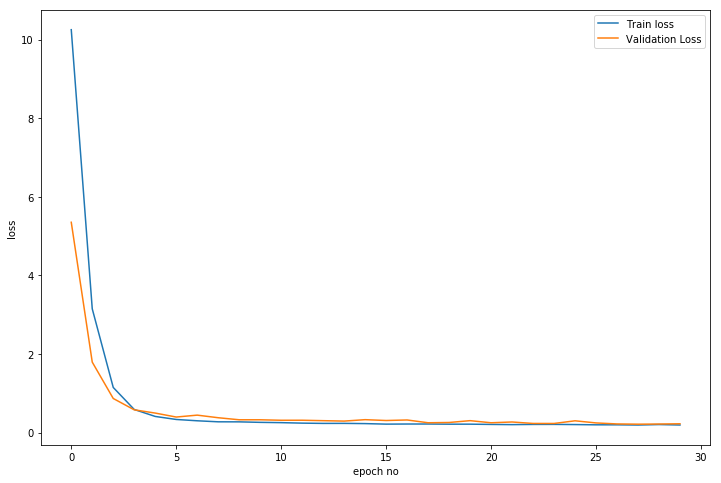

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation Loss')
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

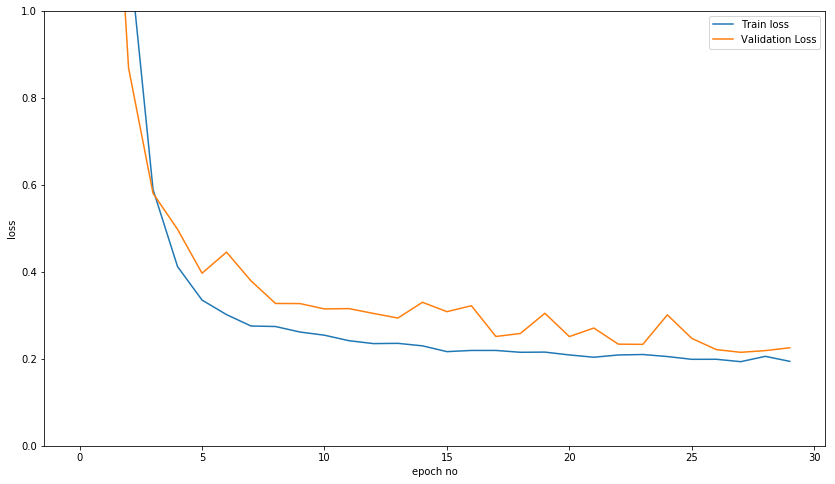

In [29]:
plt.figure(figsize=(14,8))
plt.plot(result.history['loss'],label='Train loss')
plt.plot(result.history['val_loss'],label = 'Validation Loss')
plt.ylim(0,1)
plt.xlabel('epoch no')
plt.ylabel('loss')
plt.legend()
plt.show()

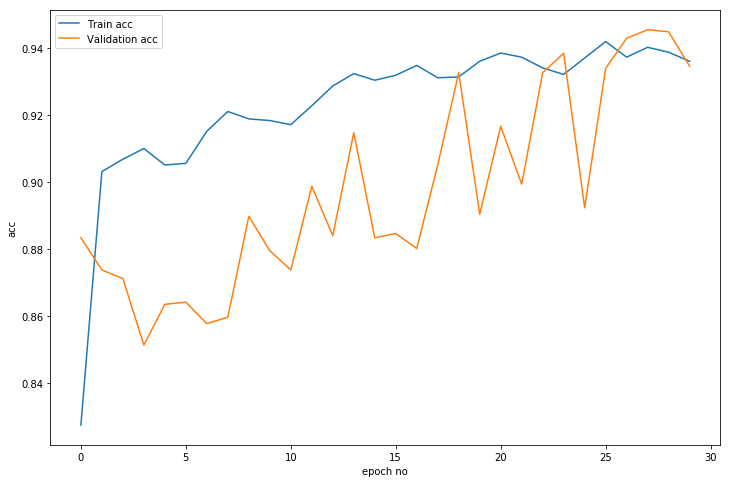

In [30]:
plt.figure(figsize=(12,8))
plt.plot(result.history['acc'],label='Train acc')
plt.plot(result.history['val_acc'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.legend()
plt.show()

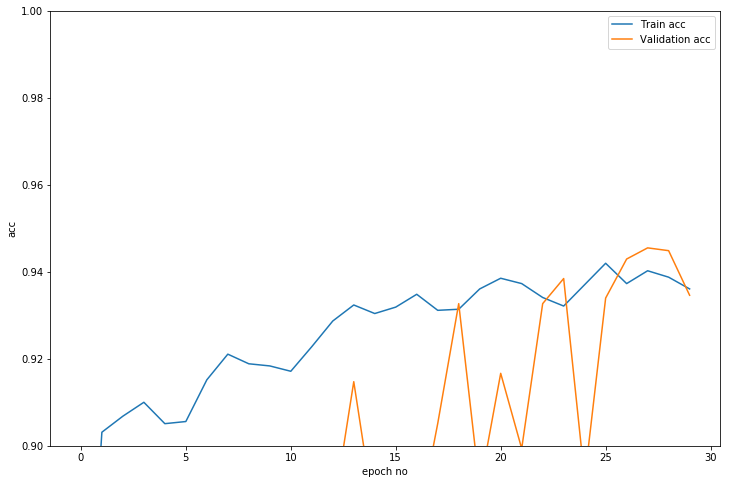

In [31]:
plt.figure(figsize=(12,8))
plt.plot(result.history['acc'],label='Train acc')
plt.plot(result.history['val_acc'],label = 'Validation acc')
plt.xlabel('epoch no')
plt.ylabel('acc')
plt.ylim(0.90,1)
plt.legend()
plt.show()

around 15-20 score is giving good accuracy wit less overfitting

In [34]:
runtime_param['nb_epoch'] = 59
best_model,result = keras_fmin_fnct(runtime_param)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 126, 32)           896       
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 124, 16)           1552      
_________________________________________________________________
dropout_5 (Dropout)          (None, 124, 16)           0         
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 41, 16)            0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 656)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                42048     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total para

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 4067 samples, validate on 1560 samples
Epoch 1/59
4067/4067 [==============================] - ETA: 57s - loss: 26.5661 - acc: 0.265 - ETA: 20s - loss: 25.5138 - acc: 0.484 - ETA: 12s - loss: 24.9786 - acc: 0.540 - ETA: 9s - loss: 24.3368 - acc: 0.582 - ETA: 7s - loss: 23.7448 - acc: 0.61 - ETA: 6s - loss: 23.1270 - acc: 0.65 - ETA: 5s - loss: 22.5990 - acc: 0.66 - ETA: 4s - loss: 22.0628 - acc: 0.68 - ETA: 4s - loss: 21.5278 - acc: 0.70 - ETA: 3s - loss: 21.0187 - acc: 0.71 - ETA: 3s - loss: 20.5310 - acc: 0.72 - ETA: 3s - loss: 20.0598 - acc: 0.73 - ETA: 2s - loss: 19.6059 - acc: 0.73 - ETA: 2s - loss: 19.1584 - acc: 0.74 - ETA: 2s - loss: 18.7239 - acc: 0.74 - ETA: 2s - loss: 18.3009 - acc: 0.75 - ETA: 1s - loss: 17.8967 - acc: 0.76 - ETA: 1s - loss: 17.5006 - acc: 0.76 - ETA: 1s - loss: 17.1220 - acc: 0.77 - ETA: 1s - loss: 16.7541 - acc: 0.77 - ETA: 1s - loss: 16.4009 - acc: 0.77 - ETA: 1s - loss: 16.0553 - acc: 0.78 - ETA: 1s - loss: 15.7180 - acc: 0.78 - ETA: 0s - loss:

Epoch 12/59
4067/4067 [==============================] - ETA: 2s - loss: 0.2231 - acc: 0.921 - ETA: 1s - loss: 0.2330 - acc: 0.927 - ETA: 1s - loss: 0.2323 - acc: 0.928 - ETA: 1s - loss: 0.2516 - acc: 0.915 - ETA: 1s - loss: 0.2440 - acc: 0.920 - ETA: 1s - loss: 0.2430 - acc: 0.921 - ETA: 1s - loss: 0.2392 - acc: 0.923 - ETA: 1s - loss: 0.2491 - acc: 0.917 - ETA: 1s - loss: 0.2520 - acc: 0.915 - ETA: 1s - loss: 0.2467 - acc: 0.917 - ETA: 1s - loss: 0.2447 - acc: 0.919 - ETA: 1s - loss: 0.2502 - acc: 0.917 - ETA: 1s - loss: 0.2487 - acc: 0.919 - ETA: 1s - loss: 0.2481 - acc: 0.917 - ETA: 1s - loss: 0.2494 - acc: 0.917 - ETA: 1s - loss: 0.2483 - acc: 0.918 - ETA: 0s - loss: 0.2512 - acc: 0.918 - ETA: 0s - loss: 0.2511 - acc: 0.918 - ETA: 0s - loss: 0.2547 - acc: 0.916 - ETA: 0s - loss: 0.2587 - acc: 0.914 - ETA: 0s - loss: 0.2626 - acc: 0.911 - ETA: 0s - loss: 0.2618 - acc: 0.911 - ETA: 0s - loss: 0.2595 - acc: 0.912 - ETA: 0s - loss: 0.2615 - acc: 0.911 - ETA: 0s - loss: 0.2606 - acc: 0

Epoch 24/59
4067/4067 [==============================] - ETA: 2s - loss: 0.2287 - acc: 0.906 - ETA: 1s - loss: 0.2346 - acc: 0.921 - ETA: 1s - loss: 0.2302 - acc: 0.921 - ETA: 1s - loss: 0.2409 - acc: 0.912 - ETA: 1s - loss: 0.2403 - acc: 0.916 - ETA: 1s - loss: 0.2269 - acc: 0.924 - ETA: 1s - loss: 0.2207 - acc: 0.925 - ETA: 1s - loss: 0.2256 - acc: 0.927 - ETA: 1s - loss: 0.2179 - acc: 0.929 - ETA: 1s - loss: 0.2213 - acc: 0.927 - ETA: 1s - loss: 0.2223 - acc: 0.927 - ETA: 1s - loss: 0.2201 - acc: 0.929 - ETA: 1s - loss: 0.2163 - acc: 0.930 - ETA: 1s - loss: 0.2187 - acc: 0.929 - ETA: 1s - loss: 0.2199 - acc: 0.928 - ETA: 1s - loss: 0.2220 - acc: 0.926 - ETA: 1s - loss: 0.2273 - acc: 0.924 - ETA: 0s - loss: 0.2291 - acc: 0.924 - ETA: 0s - loss: 0.2274 - acc: 0.924 - ETA: 0s - loss: 0.2245 - acc: 0.925 - ETA: 0s - loss: 0.2239 - acc: 0.926 - ETA: 0s - loss: 0.2235 - acc: 0.926 - ETA: 0s - loss: 0.2264 - acc: 0.925 - ETA: 0s - loss: 0.2261 - acc: 0.925 - ETA: 0s - loss: 0.2248 - acc: 0

4067/4067 [==============================] - ETA: 1s - loss: 0.2837 - acc: 0.937 - ETA: 1s - loss: 0.2547 - acc: 0.916 - ETA: 1s - loss: 0.2350 - acc: 0.918 - ETA: 1s - loss: 0.2170 - acc: 0.924 - ETA: 1s - loss: 0.2063 - acc: 0.930 - ETA: 1s - loss: 0.2040 - acc: 0.931 - ETA: 1s - loss: 0.2116 - acc: 0.929 - ETA: 1s - loss: 0.2074 - acc: 0.930 - ETA: 1s - loss: 0.2125 - acc: 0.929 - ETA: 1s - loss: 0.2150 - acc: 0.928 - ETA: 1s - loss: 0.2102 - acc: 0.930 - ETA: 1s - loss: 0.2131 - acc: 0.926 - ETA: 1s - loss: 0.2143 - acc: 0.926 - ETA: 1s - loss: 0.2126 - acc: 0.928 - ETA: 1s - loss: 0.2115 - acc: 0.928 - ETA: 1s - loss: 0.2079 - acc: 0.930 - ETA: 0s - loss: 0.2084 - acc: 0.930 - ETA: 0s - loss: 0.2146 - acc: 0.929 - ETA: 0s - loss: 0.2125 - acc: 0.930 - ETA: 0s - loss: 0.2129 - acc: 0.930 - ETA: 0s - loss: 0.2111 - acc: 0.931 - ETA: 0s - loss: 0.2118 - acc: 0.930 - ETA: 0s - loss: 0.2111 - acc: 0.931 - ETA: 0s - loss: 0.2129 - acc: 0.930 - ETA: 0s - loss: 0.2108 - acc: 0.930 - ETA: 

Epoch 48/59
4067/4067 [==============================] - ETA: 1s - loss: 0.2008 - acc: 0.968 - ETA: 1s - loss: 0.3463 - acc: 0.927 - ETA: 1s - loss: 0.3126 - acc: 0.921 - ETA: 1s - loss: 0.3005 - acc: 0.924 - ETA: 1s - loss: 0.2807 - acc: 0.930 - ETA: 1s - loss: 0.2765 - acc: 0.931 - ETA: 1s - loss: 0.2623 - acc: 0.935 - ETA: 1s - loss: 0.2630 - acc: 0.931 - ETA: 1s - loss: 0.2569 - acc: 0.933 - ETA: 1s - loss: 0.2518 - acc: 0.935 - ETA: 1s - loss: 0.2473 - acc: 0.934 - ETA: 1s - loss: 0.2484 - acc: 0.934 - ETA: 1s - loss: 0.2526 - acc: 0.932 - ETA: 1s - loss: 0.2476 - acc: 0.934 - ETA: 1s - loss: 0.2462 - acc: 0.934 - ETA: 1s - loss: 0.2440 - acc: 0.935 - ETA: 1s - loss: 0.2451 - acc: 0.933 - ETA: 0s - loss: 0.2439 - acc: 0.933 - ETA: 0s - loss: 0.2430 - acc: 0.933 - ETA: 0s - loss: 0.2437 - acc: 0.932 - ETA: 0s - loss: 0.2436 - acc: 0.931 - ETA: 0s - loss: 0.2427 - acc: 0.931 - ETA: 0s - loss: 0.2435 - acc: 0.930 - ETA: 0s - loss: 0.2461 - acc: 0.928 - ETA: 0s - loss: 0.2439 - acc: 0

Epoch 54/59
4067/4067 [==============================] - ETA: 2s - loss: 0.1035 - acc: 0.984 - ETA: 2s - loss: 0.1526 - acc: 0.958 - ETA: 1s - loss: 0.1607 - acc: 0.953 - ETA: 1s - loss: 0.1619 - acc: 0.955 - ETA: 1s - loss: 0.1906 - acc: 0.946 - ETA: 1s - loss: 0.1917 - acc: 0.946 - ETA: 1s - loss: 0.1993 - acc: 0.941 - ETA: 1s - loss: 0.1973 - acc: 0.940 - ETA: 1s - loss: 0.1958 - acc: 0.942 - ETA: 1s - loss: 0.2024 - acc: 0.939 - ETA: 1s - loss: 0.2046 - acc: 0.938 - ETA: 1s - loss: 0.2032 - acc: 0.938 - ETA: 1s - loss: 0.2022 - acc: 0.938 - ETA: 1s - loss: 0.2061 - acc: 0.937 - ETA: 1s - loss: 0.2087 - acc: 0.937 - ETA: 1s - loss: 0.2044 - acc: 0.940 - ETA: 1s - loss: 0.2039 - acc: 0.940 - ETA: 0s - loss: 0.2055 - acc: 0.938 - ETA: 0s - loss: 0.2036 - acc: 0.939 - ETA: 0s - loss: 0.2018 - acc: 0.940 - ETA: 0s - loss: 0.2001 - acc: 0.940 - ETA: 0s - loss: 0.2014 - acc: 0.938 - ETA: 0s - loss: 0.2020 - acc: 0.937 - ETA: 0s - loss: 0.2015 - acc: 0.937 - ETA: 0s - loss: 0.2007 - acc: 0

In [35]:
_,acc_val = best_model.evaluate(X_val_s,Y_val_s,verbose=0)
_,acc_train = best_model.evaluate(X_train_s,Y_train_s,verbose=0)
print('Train_accuracy',acc_train,'test_accuracy',acc_val)

Train_accuracy 0.9338578805015982 test_accuracy 0.9288461538461539


In [36]:
# Confusion Matrix
# Activities are the class labels
# It is a 3 class classification
from sklearn import metrics
ACTIVITIES = {
    0: 'SITTING',
    1: 'STANDING',
    2: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

# Confusion Matrix
print(confusion_matrix_cnn(Y_val_s, best_model.predict(X_val_s)))

[[537   0   0]
 [  0 439  52]
 [  0  59 473]]


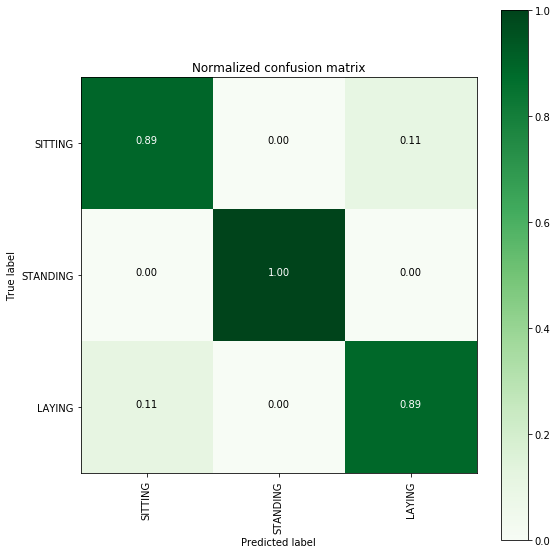

In [40]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_s, best_model.predict(X_val_s))
plot_confusion_matrix(cm, classes=['SITTING','STANDING','LAYING'], normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

In [41]:
##saving model
best_model.save('final_model_static.h5')

### Classification of Dynamic activities:

In [42]:
##data preparation
def data_scaled_dynamic():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    from sklearn.base import BaseEstimator, TransformerMixin
    class scaling_tseries_data(BaseEstimator, TransformerMixin):
        from sklearn.preprocessing import StandardScaler
        def __init__(self):
            self.scale = None

        def transform(self, X):
            temp_X1 = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
            temp_X1 = self.scale.transform(temp_X1)
            return temp_X1.reshape(X.shape)

        def fit(self, X):
            # remove overlaping
            remove = int(X.shape[1] / 2)
            temp_X = X[:, -remove:, :]
            # flatten data
            temp_X = temp_X.reshape((temp_X.shape[0] * temp_X.shape[1], temp_X.shape[2]))
            scale = StandardScaler()
            scale.fit(temp_X)
            pickle.dump(scale,open('Scale_dynamic.p','wb'))
            self.scale = scale
            return self
        
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        y_subset = y<=3
        y = y[y_subset]
        return pd.get_dummies(y).as_matrix(),y_subset
    
    Y_train_d,y_train_sub = load_y('train')
    Y_val_d,y_test_sub = load_y('test')
    X_train_d, X_val_d = load_signals('train'), load_signals('test')
    X_train_d = X_train_d[y_train_sub]
    X_val_d = X_val_d[y_test_sub]
    
    ###Scling data
    Scale = scaling_tseries_data()
    Scale.fit(X_train_d)
    X_train_d = Scale.transform(X_train_d)
    X_val_d = Scale.transform(X_val_d)

    return X_train_d, Y_train_d, X_val_d,  Y_val_d

In [43]:
X_train_d, Y_train_d, X_val_d,  Y_val_d = data_scaled_dynamic()
print('Train X shape',X_train_d.shape,'Test X shape',X_val_d.shape)
print('Train Y shape',Y_train_d.shape,'Test Y shape',Y_val_d.shape)

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:77: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:59: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Train X shape (3285, 128, 9) Test X shape (1387, 128, 9)
Train Y shape (3285, 3) Test Y shape (1387, 3)


#### baseline model

In [44]:
np.random.seed(0)
tf.set_random_seed(0)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=7, activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model.add(Conv1D(filters=32, kernel_size=3, activation='relu',kernel_initializer='he_uniform'))
model.add(Dropout(0.6))
model.add(MaxPooling1D(pool_size=3))
model.add(Flatten())
model.add(Dense(30, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, 122, 64)           4096      
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 120, 32)           6176      
_________________________________________________________________
dropout_6 (Dropout)          (None, 120, 32)           0         
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 40, 32)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                38430     
_________________________________________________________________
dense_12 (Dense)             (None, 3)                 93        
Total para

In [45]:
import math
adam = keras.optimizers.Adam(lr=0.004)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.fit(X_train_s,Y_train_s, epochs=100, batch_size=16,validation_data=(X_val_s, Y_val_s), verbose=1)
K.clear_session()

Train on 4067 samples, validate on 1560 samples
Epoch 1/100
4067/4067 [==============================] - ETA: 3:54 - loss: 2.0608 - acc: 0.375 - ETA: 1:02 - loss: 2.1721 - acc: 0.484 - ETA: 43s - loss: 1.5969 - acc: 0.572 - ETA: 34s - loss: 1.4281 - acc: 0.60 - ETA: 28s - loss: 1.2191 - acc: 0.65 - ETA: 22s - loss: 1.3602 - acc: 0.66 - ETA: 20s - loss: 1.4137 - acc: 0.66 - ETA: 18s - loss: 1.3443 - acc: 0.66 - ETA: 16s - loss: 1.2184 - acc: 0.68 - ETA: 14s - loss: 1.1831 - acc: 0.70 - ETA: 13s - loss: 1.1511 - acc: 0.71 - ETA: 13s - loss: 1.1674 - acc: 0.71 - ETA: 12s - loss: 1.1011 - acc: 0.72 - ETA: 11s - loss: 1.1216 - acc: 0.72 - ETA: 10s - loss: 1.0856 - acc: 0.73 - ETA: 10s - loss: 1.0339 - acc: 0.74 - ETA: 9s - loss: 1.0068 - acc: 0.7574 - ETA: 9s - loss: 0.9771 - acc: 0.765 - ETA: 8s - loss: 0.9542 - acc: 0.769 - ETA: 8s - loss: 0.9426 - acc: 0.776 - ETA: 8s - loss: 0.9306 - acc: 0.778 - ETA: 8s - loss: 0.9117 - acc: 0.782 - ETA: 7s - loss: 0.8713 - acc: 0.790 - ETA: 7s - loss:

4067/4067 [==============================] - ETA: 5s - loss: 0.0882 - acc: 0.937 - ETA: 4s - loss: 0.1177 - acc: 0.953 - ETA: 4s - loss: 0.1730 - acc: 0.928 - ETA: 5s - loss: 0.1703 - acc: 0.930 - ETA: 5s - loss: 0.2781 - acc: 0.916 - ETA: 5s - loss: 0.3048 - acc: 0.916 - ETA: 4s - loss: 0.2912 - acc: 0.916 - ETA: 4s - loss: 0.2670 - acc: 0.922 - ETA: 4s - loss: 0.2562 - acc: 0.919 - ETA: 4s - loss: 0.2412 - acc: 0.921 - ETA: 4s - loss: 0.2787 - acc: 0.920 - ETA: 4s - loss: 0.2690 - acc: 0.920 - ETA: 4s - loss: 0.2697 - acc: 0.921 - ETA: 4s - loss: 0.2709 - acc: 0.921 - ETA: 4s - loss: 0.2819 - acc: 0.924 - ETA: 4s - loss: 0.3044 - acc: 0.919 - ETA: 4s - loss: 0.2912 - acc: 0.921 - ETA: 4s - loss: 0.3072 - acc: 0.919 - ETA: 4s - loss: 0.3081 - acc: 0.917 - ETA: 4s - loss: 0.3023 - acc: 0.920 - ETA: 3s - loss: 0.2970 - acc: 0.917 - ETA: 3s - loss: 0.2887 - acc: 0.919 - ETA: 3s - loss: 0.2879 - acc: 0.917 - ETA: 3s - loss: 0.2885 - acc: 0.913 - ETA: 3s - loss: 0.2832 - acc: 0.915 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.1672 - acc: 0.875 - ETA: 5s - loss: 0.7712 - acc: 0.875 - ETA: 4s - loss: 0.7803 - acc: 0.883 - ETA: 4s - loss: 0.8787 - acc: 0.887 - ETA: 4s - loss: 0.7089 - acc: 0.899 - ETA: 4s - loss: 0.6846 - acc: 0.898 - ETA: 4s - loss: 0.7277 - acc: 0.884 - ETA: 4s - loss: 0.7521 - acc: 0.875 - ETA: 4s - loss: 0.7244 - acc: 0.880 - ETA: 4s - loss: 0.6676 - acc: 0.883 - ETA: 4s - loss: 0.6861 - acc: 0.885 - ETA: 4s - loss: 0.6710 - acc: 0.886 - ETA: 4s - loss: 0.6855 - acc: 0.885 - ETA: 4s - loss: 0.6725 - acc: 0.884 - ETA: 4s - loss: 0.6856 - acc: 0.883 - ETA: 4s - loss: 0.6690 - acc: 0.888 - ETA: 4s - loss: 0.6600 - acc: 0.887 - ETA: 3s - loss: 0.6505 - acc: 0.888 - ETA: 3s - loss: 0.6230 - acc: 0.890 - ETA: 3s - loss: 0.6319 - acc: 0.891 - ETA: 3s - loss: 0.6506 - acc: 0.889 - ETA: 3s - loss: 0.6424 - acc: 0.891 - ETA: 3s - loss: 0.6167 - acc: 0.895 - ETA: 3s - loss: 0.6136 - acc: 0.894 - ETA: 3s - loss: 0.6283 - acc: 0.892 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.1395 - acc: 0.937 - ETA: 4s - loss: 0.0695 - acc: 0.984 - ETA: 4s - loss: 0.1068 - acc: 0.964 - ETA: 4s - loss: 0.4177 - acc: 0.937 - ETA: 4s - loss: 0.3412 - acc: 0.942 - ETA: 4s - loss: 0.3635 - acc: 0.933 - ETA: 4s - loss: 0.3756 - acc: 0.930 - ETA: 4s - loss: 0.3385 - acc: 0.937 - ETA: 4s - loss: 0.3617 - acc: 0.937 - ETA: 4s - loss: 0.3304 - acc: 0.942 - ETA: 4s - loss: 0.3036 - acc: 0.947 - ETA: 4s - loss: 0.2894 - acc: 0.944 - ETA: 4s - loss: 0.2993 - acc: 0.944 - ETA: 4s - loss: 0.3199 - acc: 0.937 - ETA: 4s - loss: 0.3328 - acc: 0.937 - ETA: 4s - loss: 0.3238 - acc: 0.937 - ETA: 4s - loss: 0.3102 - acc: 0.937 - ETA: 4s - loss: 0.3227 - acc: 0.936 - ETA: 3s - loss: 0.3111 - acc: 0.936 - ETA: 3s - loss: 0.3196 - acc: 0.937 - ETA: 3s - loss: 0.3093 - acc: 0.937 - ETA: 3s - loss: 0.3187 - acc: 0.935 - ETA: 3s - loss: 0.3277 - acc: 0.932 - ETA: 3s - loss: 0.3427 - acc: 0.928 - ETA: 3s - loss: 0.3358 - acc: 0.927 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0772 - acc: 1.000 - ETA: 4s - loss: 0.0640 - acc: 1.000 - ETA: 5s - loss: 0.0986 - acc: 0.968 - ETA: 5s - loss: 0.1292 - acc: 0.951 - ETA: 5s - loss: 0.2842 - acc: 0.947 - ETA: 5s - loss: 0.3511 - acc: 0.942 - ETA: 5s - loss: 0.3124 - acc: 0.949 - ETA: 5s - loss: 0.2820 - acc: 0.950 - ETA: 5s - loss: 0.2785 - acc: 0.946 - ETA: 5s - loss: 0.2598 - acc: 0.947 - ETA: 5s - loss: 0.2527 - acc: 0.944 - ETA: 4s - loss: 0.2821 - acc: 0.935 - ETA: 4s - loss: 0.2685 - acc: 0.937 - ETA: 5s - loss: 0.2632 - acc: 0.937 - ETA: 5s - loss: 0.2593 - acc: 0.939 - ETA: 5s - loss: 0.2552 - acc: 0.937 - ETA: 5s - loss: 0.2558 - acc: 0.932 - ETA: 5s - loss: 0.2528 - acc: 0.934 - ETA: 5s - loss: 0.2457 - acc: 0.936 - ETA: 5s - loss: 0.2627 - acc: 0.934 - ETA: 5s - loss: 0.2569 - acc: 0.935 - ETA: 5s - loss: 0.2734 - acc: 0.933 - ETA: 5s - loss: 0.2694 - acc: 0.934 - ETA: 5s - loss: 0.2698 - acc: 0.930 - ETA: 4s - loss: 0.2972 - acc: 0.931 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.1827 - acc: 0.937 - ETA: 5s - loss: 0.1342 - acc: 0.921 - ETA: 5s - loss: 0.1499 - acc: 0.919 - ETA: 5s - loss: 0.4519 - acc: 0.906 - ETA: 5s - loss: 0.5631 - acc: 0.903 - ETA: 5s - loss: 0.7082 - acc: 0.890 - ETA: 4s - loss: 0.8193 - acc: 0.888 - ETA: 4s - loss: 0.7435 - acc: 0.886 - ETA: 4s - loss: 0.7707 - acc: 0.877 - ETA: 4s - loss: 0.7604 - acc: 0.868 - ETA: 4s - loss: 0.7543 - acc: 0.854 - ETA: 4s - loss: 0.7420 - acc: 0.852 - ETA: 4s - loss: 0.7586 - acc: 0.856 - ETA: 4s - loss: 0.7524 - acc: 0.857 - ETA: 4s - loss: 0.7387 - acc: 0.863 - ETA: 4s - loss: 0.7244 - acc: 0.868 - ETA: 4s - loss: 0.6882 - acc: 0.876 - ETA: 4s - loss: 0.6971 - acc: 0.877 - ETA: 4s - loss: 0.6703 - acc: 0.880 - ETA: 4s - loss: 0.6918 - acc: 0.881 - ETA: 4s - loss: 0.6665 - acc: 0.884 - ETA: 3s - loss: 0.6631 - acc: 0.883 - ETA: 3s - loss: 0.6493 - acc: 0.880 - ETA: 3s - loss: 0.6444 - acc: 0.880 - ETA: 3s - loss: 0.6553 - acc: 0.879 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.0925 - acc: 0.937 - ETA: 6s - loss: 0.3229 - acc: 0.895 - ETA: 6s - loss: 0.3371 - acc: 0.900 - ETA: 6s - loss: 0.2742 - acc: 0.910 - ETA: 6s - loss: 0.2619 - acc: 0.916 - ETA: 6s - loss: 0.2412 - acc: 0.909 - ETA: 6s - loss: 0.2465 - acc: 0.899 - ETA: 6s - loss: 0.2364 - acc: 0.891 - ETA: 6s - loss: 0.2386 - acc: 0.889 - ETA: 6s - loss: 0.2166 - acc: 0.893 - ETA: 6s - loss: 0.2317 - acc: 0.889 - ETA: 6s - loss: 0.2267 - acc: 0.888 - ETA: 6s - loss: 0.2600 - acc: 0.884 - ETA: 6s - loss: 0.2527 - acc: 0.887 - ETA: 6s - loss: 0.2528 - acc: 0.887 - ETA: 5s - loss: 0.2429 - acc: 0.886 - ETA: 5s - loss: 0.2416 - acc: 0.883 - ETA: 5s - loss: 0.2915 - acc: 0.875 - ETA: 5s - loss: 0.2795 - acc: 0.877 - ETA: 5s - loss: 0.2896 - acc: 0.879 - ETA: 5s - loss: 0.2815 - acc: 0.881 - ETA: 5s - loss: 0.2750 - acc: 0.881 - ETA: 4s - loss: 0.2663 - acc: 0.885 - ETA: 4s - loss: 0.2605 - acc: 0.888 - ETA: 4s - loss: 0.2561 - acc: 0.888 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.3593 - acc: 0.875 - ETA: 5s - loss: 0.4135 - acc: 0.921 - ETA: 4s - loss: 0.4264 - acc: 0.928 - ETA: 4s - loss: 0.3423 - acc: 0.937 - ETA: 5s - loss: 0.3171 - acc: 0.937 - ETA: 5s - loss: 0.2989 - acc: 0.933 - ETA: 5s - loss: 0.3400 - acc: 0.926 - ETA: 5s - loss: 0.4359 - acc: 0.918 - ETA: 5s - loss: 0.4335 - acc: 0.923 - ETA: 4s - loss: 0.4340 - acc: 0.927 - ETA: 4s - loss: 0.4018 - acc: 0.928 - ETA: 4s - loss: 0.3897 - acc: 0.927 - ETA: 4s - loss: 0.3880 - acc: 0.929 - ETA: 4s - loss: 0.3978 - acc: 0.927 - ETA: 4s - loss: 0.4605 - acc: 0.921 - ETA: 4s - loss: 0.4439 - acc: 0.922 - ETA: 4s - loss: 0.4304 - acc: 0.923 - ETA: 4s - loss: 0.4383 - acc: 0.919 - ETA: 4s - loss: 0.4206 - acc: 0.918 - ETA: 4s - loss: 0.4074 - acc: 0.920 - ETA: 4s - loss: 0.4193 - acc: 0.921 - ETA: 4s - loss: 0.4062 - acc: 0.917 - ETA: 4s - loss: 0.3930 - acc: 0.916 - ETA: 4s - loss: 0.3843 - acc: 0.917 - ETA: 4s - loss: 0.3755 - acc: 0.917 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 1.1320 - acc: 0.812 - ETA: 4s - loss: 0.3775 - acc: 0.921 - ETA: 4s - loss: 0.4061 - acc: 0.937 - ETA: 4s - loss: 0.2949 - acc: 0.950 - ETA: 4s - loss: 0.3935 - acc: 0.947 - ETA: 4s - loss: 0.3352 - acc: 0.945 - ETA: 4s - loss: 0.3105 - acc: 0.944 - ETA: 4s - loss: 0.2812 - acc: 0.940 - ETA: 4s - loss: 0.3999 - acc: 0.934 - ETA: 4s - loss: 0.4114 - acc: 0.930 - ETA: 4s - loss: 0.3801 - acc: 0.931 - ETA: 4s - loss: 0.4202 - acc: 0.924 - ETA: 4s - loss: 0.3937 - acc: 0.925 - ETA: 4s - loss: 0.3735 - acc: 0.924 - ETA: 4s - loss: 0.3641 - acc: 0.921 - ETA: 4s - loss: 0.3511 - acc: 0.922 - ETA: 4s - loss: 0.3396 - acc: 0.920 - ETA: 4s - loss: 0.3450 - acc: 0.920 - ETA: 4s - loss: 0.3344 - acc: 0.919 - ETA: 3s - loss: 0.3297 - acc: 0.916 - ETA: 3s - loss: 0.3172 - acc: 0.919 - ETA: 3s - loss: 0.3231 - acc: 0.919 - ETA: 3s - loss: 0.3136 - acc: 0.920 - ETA: 3s - loss: 0.3050 - acc: 0.922 - ETA: 3s - loss: 0.2964 - acc: 0.923 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0624 - acc: 1.000 - ETA: 5s - loss: 0.1944 - acc: 0.921 - ETA: 5s - loss: 0.3140 - acc: 0.937 - ETA: 5s - loss: 0.5884 - acc: 0.900 - ETA: 5s - loss: 0.5978 - acc: 0.895 - ETA: 5s - loss: 0.5378 - acc: 0.892 - ETA: 5s - loss: 0.7950 - acc: 0.882 - ETA: 5s - loss: 0.7358 - acc: 0.894 - ETA: 5s - loss: 0.7790 - acc: 0.897 - ETA: 5s - loss: 0.7318 - acc: 0.907 - ETA: 4s - loss: 0.7111 - acc: 0.908 - ETA: 4s - loss: 0.6780 - acc: 0.915 - ETA: 4s - loss: 0.6497 - acc: 0.916 - ETA: 4s - loss: 0.6739 - acc: 0.917 - ETA: 4s - loss: 0.6706 - acc: 0.920 - ETA: 4s - loss: 0.6498 - acc: 0.925 - ETA: 4s - loss: 0.6794 - acc: 0.924 - ETA: 4s - loss: 0.6612 - acc: 0.926 - ETA: 4s - loss: 0.6547 - acc: 0.922 - ETA: 4s - loss: 0.6613 - acc: 0.923 - ETA: 4s - loss: 0.6526 - acc: 0.921 - ETA: 4s - loss: 0.6448 - acc: 0.921 - ETA: 4s - loss: 0.6347 - acc: 0.923 - ETA: 4s - loss: 0.6140 - acc: 0.920 - ETA: 4s - loss: 0.6250 - acc: 0.917 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0435 - acc: 1.000 - ETA: 5s - loss: 0.4744 - acc: 0.859 - ETA: 5s - loss: 0.4568 - acc: 0.892 - ETA: 5s - loss: 0.4343 - acc: 0.918 - ETA: 5s - loss: 0.4490 - acc: 0.913 - ETA: 5s - loss: 0.3997 - acc: 0.920 - ETA: 5s - loss: 0.3573 - acc: 0.926 - ETA: 5s - loss: 0.3219 - acc: 0.934 - ETA: 5s - loss: 0.3635 - acc: 0.928 - ETA: 5s - loss: 0.3625 - acc: 0.924 - ETA: 5s - loss: 0.4050 - acc: 0.928 - ETA: 5s - loss: 0.3849 - acc: 0.925 - ETA: 5s - loss: 0.3614 - acc: 0.929 - ETA: 5s - loss: 0.3728 - acc: 0.932 - ETA: 5s - loss: 0.3610 - acc: 0.930 - ETA: 5s - loss: 0.3504 - acc: 0.931 - ETA: 5s - loss: 0.3438 - acc: 0.931 - ETA: 5s - loss: 0.3487 - acc: 0.933 - ETA: 4s - loss: 0.3466 - acc: 0.934 - ETA: 4s - loss: 0.3303 - acc: 0.937 - ETA: 4s - loss: 0.3247 - acc: 0.937 - ETA: 4s - loss: 0.3326 - acc: 0.938 - ETA: 4s - loss: 0.3455 - acc: 0.936 - ETA: 4s - loss: 0.3397 - acc: 0.935 - ETA: 4s - loss: 0.3328 - acc: 0.935 - ETA: 

4067/4067 [==============================] - ETA: 4s - loss: 0.0783 - acc: 1.000 - ETA: 4s - loss: 0.1673 - acc: 0.937 - ETA: 4s - loss: 0.1295 - acc: 0.946 - ETA: 4s - loss: 0.2198 - acc: 0.943 - ETA: 4s - loss: 0.2886 - acc: 0.937 - ETA: 4s - loss: 0.3202 - acc: 0.937 - ETA: 4s - loss: 0.3400 - acc: 0.944 - ETA: 4s - loss: 0.3226 - acc: 0.937 - ETA: 4s - loss: 0.3352 - acc: 0.937 - ETA: 4s - loss: 0.3240 - acc: 0.926 - ETA: 4s - loss: 0.3220 - acc: 0.925 - ETA: 4s - loss: 0.3069 - acc: 0.926 - ETA: 4s - loss: 0.2856 - acc: 0.932 - ETA: 4s - loss: 0.3031 - acc: 0.928 - ETA: 4s - loss: 0.2877 - acc: 0.931 - ETA: 4s - loss: 0.2809 - acc: 0.929 - ETA: 4s - loss: 0.2819 - acc: 0.926 - ETA: 4s - loss: 0.2729 - acc: 0.926 - ETA: 3s - loss: 0.2628 - acc: 0.928 - ETA: 3s - loss: 0.2603 - acc: 0.925 - ETA: 3s - loss: 0.2527 - acc: 0.927 - ETA: 3s - loss: 0.2693 - acc: 0.925 - ETA: 3s - loss: 0.2636 - acc: 0.926 - ETA: 3s - loss: 0.2876 - acc: 0.925 - ETA: 3s - loss: 0.3128 - acc: 0.924 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0512 - acc: 1.000 - ETA: 4s - loss: 0.1076 - acc: 0.921 - ETA: 4s - loss: 0.1165 - acc: 0.928 - ETA: 4s - loss: 0.1034 - acc: 0.937 - ETA: 4s - loss: 0.1013 - acc: 0.942 - ETA: 4s - loss: 0.1291 - acc: 0.925 - ETA: 4s - loss: 0.1349 - acc: 0.924 - ETA: 4s - loss: 0.1312 - acc: 0.926 - ETA: 4s - loss: 0.1703 - acc: 0.925 - ETA: 4s - loss: 0.1767 - acc: 0.912 - ETA: 4s - loss: 0.2025 - acc: 0.913 - ETA: 4s - loss: 0.1903 - acc: 0.917 - ETA: 4s - loss: 0.1863 - acc: 0.915 - ETA: 4s - loss: 0.2046 - acc: 0.917 - ETA: 4s - loss: 0.1980 - acc: 0.917 - ETA: 4s - loss: 0.1935 - acc: 0.918 - ETA: 4s - loss: 0.1909 - acc: 0.917 - ETA: 4s - loss: 0.1898 - acc: 0.915 - ETA: 4s - loss: 0.1799 - acc: 0.919 - ETA: 4s - loss: 0.1769 - acc: 0.920 - ETA: 4s - loss: 0.1757 - acc: 0.920 - ETA: 4s - loss: 0.1706 - acc: 0.923 - ETA: 4s - loss: 0.1672 - acc: 0.924 - ETA: 4s - loss: 0.1642 - acc: 0.925 - ETA: 4s - loss: 0.1697 - acc: 0.925 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.1252 - acc: 0.937 - ETA: 6s - loss: 0.0887 - acc: 0.958 - ETA: 5s - loss: 0.1137 - acc: 0.937 - ETA: 5s - loss: 0.0919 - acc: 0.944 - ETA: 5s - loss: 0.0816 - acc: 0.954 - ETA: 5s - loss: 0.0806 - acc: 0.955 - ETA: 5s - loss: 0.0911 - acc: 0.948 - ETA: 5s - loss: 0.0894 - acc: 0.950 - ETA: 5s - loss: 0.1254 - acc: 0.948 - ETA: 5s - loss: 0.1242 - acc: 0.947 - ETA: 5s - loss: 0.1226 - acc: 0.948 - ETA: 5s - loss: 0.1213 - acc: 0.949 - ETA: 4s - loss: 0.1280 - acc: 0.946 - ETA: 4s - loss: 0.1283 - acc: 0.944 - ETA: 4s - loss: 0.1273 - acc: 0.945 - ETA: 4s - loss: 0.1249 - acc: 0.947 - ETA: 4s - loss: 0.1272 - acc: 0.948 - ETA: 4s - loss: 0.1226 - acc: 0.950 - ETA: 4s - loss: 0.1229 - acc: 0.950 - ETA: 4s - loss: 0.1206 - acc: 0.951 - ETA: 4s - loss: 0.1299 - acc: 0.950 - ETA: 4s - loss: 0.1265 - acc: 0.952 - ETA: 4s - loss: 0.1242 - acc: 0.952 - ETA: 4s - loss: 0.1307 - acc: 0.952 - ETA: 4s - loss: 0.1280 - acc: 0.954 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0285 - acc: 1.000 - ETA: 5s - loss: 0.1193 - acc: 0.937 - ETA: 5s - loss: 0.0833 - acc: 0.955 - ETA: 5s - loss: 0.1193 - acc: 0.956 - ETA: 5s - loss: 0.1075 - acc: 0.961 - ETA: 5s - loss: 0.1601 - acc: 0.960 - ETA: 5s - loss: 0.1591 - acc: 0.950 - ETA: 5s - loss: 0.1489 - acc: 0.954 - ETA: 5s - loss: 0.1857 - acc: 0.950 - ETA: 5s - loss: 0.1757 - acc: 0.950 - ETA: 4s - loss: 0.1729 - acc: 0.951 - ETA: 4s - loss: 0.2093 - acc: 0.943 - ETA: 4s - loss: 0.2289 - acc: 0.942 - ETA: 4s - loss: 0.2285 - acc: 0.939 - ETA: 4s - loss: 0.2437 - acc: 0.937 - ETA: 4s - loss: 0.2384 - acc: 0.938 - ETA: 4s - loss: 0.2321 - acc: 0.937 - ETA: 4s - loss: 0.2450 - acc: 0.937 - ETA: 4s - loss: 0.2355 - acc: 0.939 - ETA: 4s - loss: 0.2484 - acc: 0.938 - ETA: 4s - loss: 0.2503 - acc: 0.936 - ETA: 4s - loss: 0.2448 - acc: 0.936 - ETA: 4s - loss: 0.2407 - acc: 0.936 - ETA: 4s - loss: 0.2687 - acc: 0.933 - ETA: 4s - loss: 0.2648 - acc: 0.933 - ETA: 

4067/4067 [==============================] - ETA: 8s - loss: 0.0756 - acc: 0.937 - ETA: 9s - loss: 0.1248 - acc: 0.937 - ETA: 8s - loss: 0.1416 - acc: 0.925 - ETA: 7s - loss: 0.1143 - acc: 0.946 - ETA: 7s - loss: 0.4848 - acc: 0.937 - ETA: 6s - loss: 0.3908 - acc: 0.942 - ETA: 6s - loss: 0.3473 - acc: 0.950 - ETA: 6s - loss: 0.3107 - acc: 0.952 - ETA: 6s - loss: 0.3243 - acc: 0.953 - ETA: 6s - loss: 0.3348 - acc: 0.953 - ETA: 6s - loss: 0.3112 - acc: 0.957 - ETA: 6s - loss: 0.3334 - acc: 0.956 - ETA: 5s - loss: 0.3082 - acc: 0.958 - ETA: 5s - loss: 0.2867 - acc: 0.960 - ETA: 5s - loss: 0.3048 - acc: 0.957 - ETA: 5s - loss: 0.2916 - acc: 0.957 - ETA: 5s - loss: 0.2792 - acc: 0.958 - ETA: 5s - loss: 0.2676 - acc: 0.960 - ETA: 5s - loss: 0.2580 - acc: 0.960 - ETA: 5s - loss: 0.2426 - acc: 0.963 - ETA: 5s - loss: 0.2318 - acc: 0.965 - ETA: 5s - loss: 0.2435 - acc: 0.962 - ETA: 4s - loss: 0.2387 - acc: 0.962 - ETA: 4s - loss: 0.2332 - acc: 0.962 - ETA: 4s - loss: 0.2449 - acc: 0.958 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.0554 - acc: 1.000 - ETA: 6s - loss: 0.0858 - acc: 0.958 - ETA: 5s - loss: 0.0776 - acc: 0.958 - ETA: 5s - loss: 0.0536 - acc: 0.972 - ETA: 5s - loss: 0.0502 - acc: 0.974 - ETA: 5s - loss: 0.0580 - acc: 0.973 - ETA: 6s - loss: 0.0517 - acc: 0.977 - ETA: 6s - loss: 0.1060 - acc: 0.975 - ETA: 6s - loss: 0.1361 - acc: 0.971 - ETA: 6s - loss: 0.1241 - acc: 0.972 - ETA: 5s - loss: 0.1241 - acc: 0.968 - ETA: 5s - loss: 0.1199 - acc: 0.968 - ETA: 5s - loss: 0.1166 - acc: 0.968 - ETA: 5s - loss: 0.1120 - acc: 0.967 - ETA: 5s - loss: 0.1091 - acc: 0.967 - ETA: 5s - loss: 0.1086 - acc: 0.964 - ETA: 5s - loss: 0.1014 - acc: 0.967 - ETA: 5s - loss: 0.1398 - acc: 0.966 - ETA: 4s - loss: 0.2190 - acc: 0.960 - ETA: 4s - loss: 0.2066 - acc: 0.963 - ETA: 4s - loss: 0.2130 - acc: 0.964 - ETA: 4s - loss: 0.2037 - acc: 0.964 - ETA: 4s - loss: 0.2058 - acc: 0.963 - ETA: 4s - loss: 0.2012 - acc: 0.964 - ETA: 4s - loss: 0.1926 - acc: 0.965 - ETA: 

4067/4067 [==============================] - ETA: 4s - loss: 0.0831 - acc: 0.937 - ETA: 4s - loss: 0.0855 - acc: 0.953 - ETA: 4s - loss: 0.0772 - acc: 0.946 - ETA: 4s - loss: 0.0640 - acc: 0.962 - ETA: 4s - loss: 0.1500 - acc: 0.951 - ETA: 4s - loss: 0.1290 - acc: 0.960 - ETA: 4s - loss: 0.1859 - acc: 0.950 - ETA: 4s - loss: 0.1853 - acc: 0.940 - ETA: 4s - loss: 0.2083 - acc: 0.942 - ETA: 4s - loss: 0.1988 - acc: 0.939 - ETA: 4s - loss: 0.1860 - acc: 0.943 - ETA: 4s - loss: 0.1772 - acc: 0.944 - ETA: 4s - loss: 0.1764 - acc: 0.945 - ETA: 4s - loss: 0.1702 - acc: 0.945 - ETA: 4s - loss: 0.1634 - acc: 0.946 - ETA: 4s - loss: 0.2011 - acc: 0.945 - ETA: 4s - loss: 0.1934 - acc: 0.946 - ETA: 3s - loss: 0.1884 - acc: 0.945 - ETA: 3s - loss: 0.1974 - acc: 0.947 - ETA: 3s - loss: 0.2069 - acc: 0.948 - ETA: 3s - loss: 0.2007 - acc: 0.946 - ETA: 3s - loss: 0.1929 - acc: 0.949 - ETA: 3s - loss: 0.1862 - acc: 0.950 - ETA: 3s - loss: 0.1835 - acc: 0.949 - ETA: 3s - loss: 0.2114 - acc: 0.947 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.2467 - acc: 0.875 - ETA: 6s - loss: 0.2211 - acc: 0.921 - ETA: 6s - loss: 0.1697 - acc: 0.937 - ETA: 7s - loss: 0.1466 - acc: 0.945 - ETA: 7s - loss: 0.1465 - acc: 0.937 - ETA: 7s - loss: 0.1500 - acc: 0.937 - ETA: 8s - loss: 0.1557 - acc: 0.937 - ETA: 8s - loss: 0.1510 - acc: 0.942 - ETA: 8s - loss: 0.1427 - acc: 0.941 - ETA: 8s - loss: 0.1432 - acc: 0.941 - ETA: 8s - loss: 0.1333 - acc: 0.947 - ETA: 8s - loss: 0.1301 - acc: 0.949 - ETA: 8s - loss: 0.1286 - acc: 0.948 - ETA: 9s - loss: 0.1219 - acc: 0.950 - ETA: 8s - loss: 0.1559 - acc: 0.949 - ETA: 8s - loss: 0.1543 - acc: 0.948 - ETA: 8s - loss: 0.1646 - acc: 0.950 - ETA: 8s - loss: 0.1569 - acc: 0.953 - ETA: 8s - loss: 0.1526 - acc: 0.954 - ETA: 8s - loss: 0.1480 - acc: 0.956 - ETA: 8s - loss: 0.1473 - acc: 0.956 - ETA: 8s - loss: 0.1429 - acc: 0.956 - ETA: 8s - loss: 0.1413 - acc: 0.955 - ETA: 7s - loss: 0.1393 - acc: 0.954 - ETA: 7s - loss: 0.1597 - acc: 0.954 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.0493 - acc: 0.937 - ETA: 4s - loss: 0.0994 - acc: 0.937 - ETA: 4s - loss: 0.0736 - acc: 0.964 - ETA: 4s - loss: 0.0643 - acc: 0.968 - ETA: 4s - loss: 0.0631 - acc: 0.971 - ETA: 5s - loss: 0.0612 - acc: 0.975 - ETA: 5s - loss: 0.0612 - acc: 0.974 - ETA: 5s - loss: 0.0644 - acc: 0.970 - ETA: 5s - loss: 0.1570 - acc: 0.967 - ETA: 5s - loss: 0.1505 - acc: 0.967 - ETA: 5s - loss: 0.1437 - acc: 0.967 - ETA: 5s - loss: 0.1397 - acc: 0.965 - ETA: 5s - loss: 0.1290 - acc: 0.968 - ETA: 5s - loss: 0.1189 - acc: 0.971 - ETA: 5s - loss: 0.1123 - acc: 0.972 - ETA: 5s - loss: 0.1054 - acc: 0.971 - ETA: 4s - loss: 0.1046 - acc: 0.969 - ETA: 4s - loss: 0.1039 - acc: 0.967 - ETA: 4s - loss: 0.1023 - acc: 0.966 - ETA: 4s - loss: 0.0952 - acc: 0.969 - ETA: 4s - loss: 0.0972 - acc: 0.969 - ETA: 4s - loss: 0.0943 - acc: 0.970 - ETA: 4s - loss: 0.0926 - acc: 0.969 - ETA: 4s - loss: 0.0902 - acc: 0.971 - ETA: 4s - loss: 0.0874 - acc: 0.972 - ETA: 

4067/4067 [==============================] - ETA: 3s - loss: 0.0019 - acc: 1.000 - ETA: 4s - loss: 0.3228 - acc: 0.968 - ETA: 4s - loss: 0.1969 - acc: 0.973 - ETA: 5s - loss: 0.1606 - acc: 0.972 - ETA: 4s - loss: 0.2712 - acc: 0.958 - ETA: 4s - loss: 0.2361 - acc: 0.958 - ETA: 4s - loss: 0.2587 - acc: 0.958 - ETA: 4s - loss: 0.3231 - acc: 0.955 - ETA: 4s - loss: 0.3296 - acc: 0.955 - ETA: 4s - loss: 0.3095 - acc: 0.956 - ETA: 4s - loss: 0.2907 - acc: 0.956 - ETA: 4s - loss: 0.2724 - acc: 0.956 - ETA: 4s - loss: 0.2894 - acc: 0.953 - ETA: 4s - loss: 0.2696 - acc: 0.956 - ETA: 4s - loss: 0.2683 - acc: 0.956 - ETA: 4s - loss: 0.3081 - acc: 0.954 - ETA: 4s - loss: 0.3402 - acc: 0.953 - ETA: 4s - loss: 0.3566 - acc: 0.951 - ETA: 3s - loss: 0.3391 - acc: 0.952 - ETA: 3s - loss: 0.3247 - acc: 0.952 - ETA: 3s - loss: 0.3331 - acc: 0.951 - ETA: 3s - loss: 0.3239 - acc: 0.950 - ETA: 3s - loss: 0.3275 - acc: 0.950 - ETA: 3s - loss: 0.3317 - acc: 0.950 - ETA: 3s - loss: 0.3204 - acc: 0.951 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.8440 - acc: 0.875 - ETA: 5s - loss: 0.4254 - acc: 0.859 - ETA: 5s - loss: 0.2981 - acc: 0.901 - ETA: 5s - loss: 0.3614 - acc: 0.912 - ETA: 5s - loss: 0.3261 - acc: 0.913 - ETA: 5s - loss: 0.3857 - acc: 0.902 - ETA: 4s - loss: 0.4112 - acc: 0.904 - ETA: 4s - loss: 0.4197 - acc: 0.906 - ETA: 4s - loss: 0.4714 - acc: 0.900 - ETA: 4s - loss: 0.4840 - acc: 0.897 - ETA: 4s - loss: 0.4633 - acc: 0.900 - ETA: 4s - loss: 0.5590 - acc: 0.892 - ETA: 4s - loss: 0.5328 - acc: 0.895 - ETA: 4s - loss: 0.5341 - acc: 0.892 - ETA: 4s - loss: 0.5679 - acc: 0.881 - ETA: 4s - loss: 0.5458 - acc: 0.881 - ETA: 4s - loss: 0.5259 - acc: 0.885 - ETA: 4s - loss: 0.5657 - acc: 0.882 - ETA: 4s - loss: 0.5720 - acc: 0.883 - ETA: 4s - loss: 0.5551 - acc: 0.884 - ETA: 4s - loss: 0.5431 - acc: 0.884 - ETA: 4s - loss: 0.5506 - acc: 0.882 - ETA: 4s - loss: 0.5396 - acc: 0.881 - ETA: 4s - loss: 0.5391 - acc: 0.882 - ETA: 4s - loss: 0.5512 - acc: 0.883 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 1.0595 - acc: 0.937 - ETA: 6s - loss: 1.0507 - acc: 0.937 - ETA: 5s - loss: 1.6596 - acc: 0.854 - ETA: 5s - loss: 1.5696 - acc: 0.875 - ETA: 5s - loss: 1.4599 - acc: 0.880 - ETA: 5s - loss: 1.3343 - acc: 0.891 - ETA: 5s - loss: 1.3278 - acc: 0.892 - ETA: 5s - loss: 1.2919 - acc: 0.892 - ETA: 4s - loss: 1.3075 - acc: 0.893 - ETA: 4s - loss: 1.2423 - acc: 0.900 - ETA: 4s - loss: 1.2711 - acc: 0.897 - ETA: 4s - loss: 1.2199 - acc: 0.901 - ETA: 4s - loss: 1.2063 - acc: 0.902 - ETA: 4s - loss: 1.2048 - acc: 0.899 - ETA: 4s - loss: 1.2006 - acc: 0.894 - ETA: 4s - loss: 1.2845 - acc: 0.887 - ETA: 4s - loss: 1.2913 - acc: 0.888 - ETA: 4s - loss: 1.3406 - acc: 0.883 - ETA: 4s - loss: 1.3476 - acc: 0.880 - ETA: 4s - loss: 1.3163 - acc: 0.882 - ETA: 4s - loss: 1.2926 - acc: 0.884 - ETA: 4s - loss: 1.3324 - acc: 0.880 - ETA: 3s - loss: 1.4013 - acc: 0.876 - ETA: 3s - loss: 1.3896 - acc: 0.876 - ETA: 3s - loss: 1.4184 - acc: 0.876 - ETA: 

4067/4067 [==============================] - ETA: 5s - loss: 0.2013 - acc: 0.875 - ETA: 5s - loss: 0.5140 - acc: 0.828 - ETA: 6s - loss: 0.5614 - acc: 0.854 - ETA: 6s - loss: 0.5039 - acc: 0.835 - ETA: 6s - loss: 0.4273 - acc: 0.852 - ETA: 5s - loss: 0.4540 - acc: 0.857 - ETA: 5s - loss: 0.4806 - acc: 0.852 - ETA: 5s - loss: 0.4423 - acc: 0.862 - ETA: 5s - loss: 0.4565 - acc: 0.864 - ETA: 5s - loss: 0.4686 - acc: 0.867 - ETA: 5s - loss: 0.4827 - acc: 0.864 - ETA: 5s - loss: 0.5597 - acc: 0.857 - ETA: 4s - loss: 0.5855 - acc: 0.858 - ETA: 4s - loss: 0.5617 - acc: 0.858 - ETA: 4s - loss: 0.5565 - acc: 0.861 - ETA: 4s - loss: 0.5391 - acc: 0.859 - ETA: 4s - loss: 0.5453 - acc: 0.862 - ETA: 4s - loss: 0.5620 - acc: 0.866 - ETA: 4s - loss: 0.5641 - acc: 0.865 - ETA: 4s - loss: 0.5651 - acc: 0.863 - ETA: 4s - loss: 0.5656 - acc: 0.863 - ETA: 4s - loss: 0.5632 - acc: 0.866 - ETA: 4s - loss: 0.5456 - acc: 0.871 - ETA: 4s - loss: 0.5271 - acc: 0.875 - ETA: 4s - loss: 0.5303 - acc: 0.877 - ETA: 

4067/4067 [==============================] - ETA: 6s - loss: 0.0655 - acc: 1.000 - ETA: 5s - loss: 0.8737 - acc: 0.890 - ETA: 5s - loss: 0.7846 - acc: 0.857 - ETA: 5s - loss: 0.8856 - acc: 0.847 - ETA: 5s - loss: 0.7437 - acc: 0.843 - ETA: 5s - loss: 0.6515 - acc: 0.845 - ETA: 5s - loss: 0.6371 - acc: 0.850 - ETA: 5s - loss: 0.5833 - acc: 0.854 - ETA: 5s - loss: 0.5861 - acc: 0.854 - ETA: 4s - loss: 0.5566 - acc: 0.851 - ETA: 4s - loss: 0.5278 - acc: 0.852 - ETA: 4s - loss: 0.5081 - acc: 0.856 - ETA: 4s - loss: 0.4799 - acc: 0.862 - ETA: 4s - loss: 0.5181 - acc: 0.859 - ETA: 4s - loss: 0.5021 - acc: 0.857 - ETA: 4s - loss: 0.4826 - acc: 0.859 - ETA: 4s - loss: 0.4845 - acc: 0.863 - ETA: 4s - loss: 0.4920 - acc: 0.862 - ETA: 4s - loss: 0.4777 - acc: 0.863 - ETA: 4s - loss: 0.4711 - acc: 0.862 - ETA: 4s - loss: 0.4612 - acc: 0.865 - ETA: 4s - loss: 0.4707 - acc: 0.864 - ETA: 4s - loss: 0.4943 - acc: 0.864 - ETA: 4s - loss: 0.4881 - acc: 0.865 - ETA: 4s - loss: 0.5228 - acc: 0.862 - ETA: 

Epoch 98/100
4067/4067 [==============================] - ETA: 5s - loss: 0.2230 - acc: 0.937 - ETA: 4s - loss: 0.4282 - acc: 0.887 - ETA: 5s - loss: 0.5190 - acc: 0.875 - ETA: 4s - loss: 0.5028 - acc: 0.875 - ETA: 4s - loss: 0.6039 - acc: 0.875 - ETA: 4s - loss: 0.5352 - acc: 0.882 - ETA: 4s - loss: 0.4807 - acc: 0.891 - ETA: 4s - loss: 0.4402 - acc: 0.900 - ETA: 4s - loss: 0.4947 - acc: 0.895 - ETA: 4s - loss: 0.4677 - acc: 0.892 - ETA: 4s - loss: 0.4507 - acc: 0.891 - ETA: 4s - loss: 0.4655 - acc: 0.882 - ETA: 4s - loss: 0.4555 - acc: 0.883 - ETA: 4s - loss: 0.4618 - acc: 0.884 - ETA: 4s - loss: 0.4721 - acc: 0.881 - ETA: 4s - loss: 0.4837 - acc: 0.877 - ETA: 4s - loss: 0.4666 - acc: 0.880 - ETA: 4s - loss: 0.4479 - acc: 0.884 - ETA: 3s - loss: 0.4522 - acc: 0.886 - ETA: 3s - loss: 0.4571 - acc: 0.888 - ETA: 3s - loss: 0.4665 - acc: 0.888 - ETA: 3s - loss: 0.4779 - acc: 0.887 - ETA: 3s - loss: 0.4899 - acc: 0.886 - ETA: 3s - loss: 0.4765 - acc: 0.888 - ETA: 3s - loss: 0.4671 - acc: 

In [ ]:
X_train_d, Y_train_d, X_val_d, Y_val_d = data_scaled_dynamic()

In [59]:
model_dyn = Sequential()
model_dyn.add(Conv1D(filters=64, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform',input_shape=(128,9)))
model_dyn.add(Conv1D(filters=32, kernel_size=5,padding='same', activation='relu',kernel_initializer='he_uniform'))
model_dyn.add(Dropout(0.5))
model_dyn.add(MaxPooling1D(pool_size=1,strides=1))

model_dyn.add(Flatten())
model_dyn.add(Dense(64, activation='relu',kernel_initializer='he_uniform'))
model_dyn.add(BatchNormalization()) 
model_dyn.add(Dropout(0.5))

model_dyn.add(Dense(32, activation='relu',kernel_initializer='he_uniform'))
model_dyn.add(BatchNormalization()) 
model_dyn.add(Dropout(0.5))

model_dyn.add(Dense(3, activation='softmax'))

model_dyn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_dyn.fit(X_train_d, Y_train_d, epochs=40, batch_size=16,validation_data=(X_val_d, Y_val_d),verbose=1)

#Evaluate the model_dyn 
score = model_dyn.evaluate(X_val_d, Y_val_d)

Train on 3285 samples, validate on 1387 samples
Epoch 1/40
3285/3285 [==============================] - ETA: 7:49 - loss: 2.0778 - acc: 0.312 - ETA: 2:40 - loss: 1.5070 - acc: 0.458 - ETA: 1:38 - loss: 1.6841 - acc: 0.412 - ETA: 1:12 - loss: 1.8303 - acc: 0.366 - ETA: 57s - loss: 1.7413 - acc: 0.381 - ETA: 47s - loss: 1.7483 - acc: 0.36 - ETA: 40s - loss: 1.7444 - acc: 0.36 - ETA: 36s - loss: 1.7777 - acc: 0.36 - ETA: 32s - loss: 1.7455 - acc: 0.36 - ETA: 29s - loss: 1.7407 - acc: 0.37 - ETA: 26s - loss: 1.7432 - acc: 0.36 - ETA: 24s - loss: 1.7441 - acc: 0.36 - ETA: 23s - loss: 1.7319 - acc: 0.36 - ETA: 22s - loss: 1.7000 - acc: 0.37 - ETA: 21s - loss: 1.6991 - acc: 0.37 - ETA: 20s - loss: 1.6753 - acc: 0.37 - ETA: 19s - loss: 1.6495 - acc: 0.37 - ETA: 18s - loss: 1.6184 - acc: 0.38 - ETA: 17s - loss: 1.6328 - acc: 0.38 - ETA: 16s - loss: 1.6416 - acc: 0.38 - ETA: 15s - loss: 1.6538 - acc: 0.37 - ETA: 15s - loss: 1.6380 - acc: 0.37 - ETA: 14s - loss: 1.6267 - acc: 0.37 - ETA: 14s - lo

Epoch 3/40
3285/3285 [==============================] - ETA: 7s - loss: 0.2576 - acc: 0.875 - ETA: 7s - loss: 0.3494 - acc: 0.895 - ETA: 7s - loss: 0.3980 - acc: 0.862 - ETA: 7s - loss: 0.4207 - acc: 0.812 - ETA: 7s - loss: 0.4208 - acc: 0.819 - ETA: 7s - loss: 0.4673 - acc: 0.812 - ETA: 7s - loss: 0.4439 - acc: 0.826 - ETA: 7s - loss: 0.4305 - acc: 0.825 - ETA: 7s - loss: 0.4547 - acc: 0.816 - ETA: 7s - loss: 0.4562 - acc: 0.819 - ETA: 6s - loss: 0.4594 - acc: 0.812 - ETA: 6s - loss: 0.4570 - acc: 0.812 - ETA: 6s - loss: 0.4565 - acc: 0.815 - ETA: 6s - loss: 0.4616 - acc: 0.814 - ETA: 6s - loss: 0.4721 - acc: 0.808 - ETA: 6s - loss: 0.4689 - acc: 0.812 - ETA: 6s - loss: 0.4756 - acc: 0.808 - ETA: 6s - loss: 0.4725 - acc: 0.812 - ETA: 6s - loss: 0.4649 - acc: 0.819 - ETA: 6s - loss: 0.4631 - acc: 0.820 - ETA: 6s - loss: 0.4586 - acc: 0.820 - ETA: 6s - loss: 0.4598 - acc: 0.819 - ETA: 6s - loss: 0.4505 - acc: 0.826 - ETA: 6s - loss: 0.4525 - acc: 0.825 - ETA: 6s - loss: 0.4562 - acc: 0.

3285/3285 [==============================] - ETA: 7s - loss: 0.3791 - acc: 0.875 - ETA: 7s - loss: 0.2227 - acc: 0.937 - ETA: 7s - loss: 0.2104 - acc: 0.937 - ETA: 7s - loss: 0.2162 - acc: 0.937 - ETA: 7s - loss: 0.2030 - acc: 0.945 - ETA: 8s - loss: 0.1917 - acc: 0.951 - ETA: 7s - loss: 0.1834 - acc: 0.960 - ETA: 8s - loss: 0.1751 - acc: 0.961 - ETA: 8s - loss: 0.1664 - acc: 0.964 - ETA: 8s - loss: 0.1832 - acc: 0.953 - ETA: 8s - loss: 0.1751 - acc: 0.954 - ETA: 8s - loss: 0.1749 - acc: 0.953 - ETA: 8s - loss: 0.1667 - acc: 0.958 - ETA: 8s - loss: 0.1828 - acc: 0.953 - ETA: 8s - loss: 0.1987 - acc: 0.947 - ETA: 8s - loss: 0.1976 - acc: 0.947 - ETA: 8s - loss: 0.1901 - acc: 0.948 - ETA: 8s - loss: 0.1872 - acc: 0.948 - ETA: 8s - loss: 0.1830 - acc: 0.950 - ETA: 8s - loss: 0.1824 - acc: 0.949 - ETA: 7s - loss: 0.1874 - acc: 0.945 - ETA: 7s - loss: 0.1895 - acc: 0.942 - ETA: 7s - loss: 0.1854 - acc: 0.944 - ETA: 7s - loss: 0.1904 - acc: 0.944 - ETA: 7s - loss: 0.2067 - acc: 0.935 - ETA: 

3285/3285 [==============================] - ETA: 7s - loss: 0.1086 - acc: 0.937 - ETA: 7s - loss: 0.0725 - acc: 0.979 - ETA: 7s - loss: 0.0706 - acc: 0.987 - ETA: 7s - loss: 0.0649 - acc: 0.991 - ETA: 7s - loss: 0.0913 - acc: 0.984 - ETA: 7s - loss: 0.0965 - acc: 0.981 - ETA: 8s - loss: 0.0894 - acc: 0.983 - ETA: 8s - loss: 0.0840 - acc: 0.985 - ETA: 7s - loss: 0.0937 - acc: 0.979 - ETA: 7s - loss: 0.0912 - acc: 0.981 - ETA: 7s - loss: 0.0961 - acc: 0.980 - ETA: 7s - loss: 0.0908 - acc: 0.982 - ETA: 7s - loss: 0.0901 - acc: 0.981 - ETA: 7s - loss: 0.0986 - acc: 0.975 - ETA: 7s - loss: 0.0994 - acc: 0.974 - ETA: 7s - loss: 0.0972 - acc: 0.976 - ETA: 7s - loss: 0.0942 - acc: 0.977 - ETA: 7s - loss: 0.0920 - acc: 0.978 - ETA: 7s - loss: 0.0901 - acc: 0.979 - ETA: 7s - loss: 0.0889 - acc: 0.979 - ETA: 7s - loss: 0.0925 - acc: 0.978 - ETA: 7s - loss: 0.0906 - acc: 0.979 - ETA: 7s - loss: 0.0872 - acc: 0.980 - ETA: 6s - loss: 0.0896 - acc: 0.977 - ETA: 6s - loss: 0.0867 - acc: 0.978 - ETA: 

3285/3285 [==============================] - ETA: 7s - loss: 0.2065 - acc: 0.937 - ETA: 7s - loss: 0.1873 - acc: 0.937 - ETA: 7s - loss: 0.1197 - acc: 0.962 - ETA: 7s - loss: 0.1326 - acc: 0.955 - ETA: 7s - loss: 0.1148 - acc: 0.965 - ETA: 6s - loss: 0.2177 - acc: 0.943 - ETA: 6s - loss: 0.1874 - acc: 0.951 - ETA: 6s - loss: 0.1703 - acc: 0.958 - ETA: 6s - loss: 0.1637 - acc: 0.952 - ETA: 6s - loss: 0.1502 - acc: 0.957 - ETA: 6s - loss: 0.1369 - acc: 0.961 - ETA: 6s - loss: 0.1277 - acc: 0.964 - ETA: 6s - loss: 0.1195 - acc: 0.967 - ETA: 6s - loss: 0.1115 - acc: 0.969 - ETA: 6s - loss: 0.1066 - acc: 0.972 - ETA: 6s - loss: 0.1020 - acc: 0.973 - ETA: 6s - loss: 0.1094 - acc: 0.971 - ETA: 6s - loss: 0.1184 - acc: 0.969 - ETA: 6s - loss: 0.1127 - acc: 0.971 - ETA: 5s - loss: 0.1100 - acc: 0.972 - ETA: 5s - loss: 0.1107 - acc: 0.972 - ETA: 5s - loss: 0.1064 - acc: 0.973 - ETA: 5s - loss: 0.1022 - acc: 0.975 - ETA: 5s - loss: 0.0993 - acc: 0.976 - ETA: 5s - loss: 0.1169 - acc: 0.971 - ETA: 

3285/3285 [==============================] - ETA: 7s - loss: 0.0152 - acc: 1.000 - ETA: 7s - loss: 0.0662 - acc: 0.979 - ETA: 7s - loss: 0.0454 - acc: 0.987 - ETA: 7s - loss: 0.0450 - acc: 0.991 - ETA: 7s - loss: 0.0475 - acc: 0.986 - ETA: 7s - loss: 0.0586 - acc: 0.977 - ETA: 7s - loss: 0.0542 - acc: 0.980 - ETA: 7s - loss: 0.0523 - acc: 0.979 - ETA: 7s - loss: 0.0491 - acc: 0.981 - ETA: 7s - loss: 0.0464 - acc: 0.983 - ETA: 7s - loss: 0.0451 - acc: 0.985 - ETA: 7s - loss: 0.0416 - acc: 0.986 - ETA: 7s - loss: 0.0439 - acc: 0.985 - ETA: 6s - loss: 0.0441 - acc: 0.986 - ETA: 6s - loss: 0.0431 - acc: 0.987 - ETA: 6s - loss: 0.0410 - acc: 0.987 - ETA: 6s - loss: 0.0397 - acc: 0.988 - ETA: 6s - loss: 0.0381 - acc: 0.989 - ETA: 6s - loss: 0.0381 - acc: 0.989 - ETA: 6s - loss: 0.0442 - acc: 0.985 - ETA: 6s - loss: 0.0444 - acc: 0.984 - ETA: 6s - loss: 0.0428 - acc: 0.985 - ETA: 6s - loss: 0.0431 - acc: 0.986 - ETA: 6s - loss: 0.0416 - acc: 0.986 - ETA: 6s - loss: 0.0428 - acc: 0.986 - ETA: 

3285/3285 [==============================] - ETA: 8s - loss: 0.0372 - acc: 1.000 - ETA: 7s - loss: 0.0171 - acc: 1.000 - ETA: 7s - loss: 0.0138 - acc: 1.000 - ETA: 6s - loss: 0.0214 - acc: 1.000 - ETA: 6s - loss: 0.0191 - acc: 1.000 - ETA: 6s - loss: 0.0173 - acc: 1.000 - ETA: 6s - loss: 0.0617 - acc: 0.990 - ETA: 6s - loss: 0.0669 - acc: 0.983 - ETA: 6s - loss: 0.0602 - acc: 0.985 - ETA: 6s - loss: 0.0548 - acc: 0.986 - ETA: 6s - loss: 0.0599 - acc: 0.982 - ETA: 6s - loss: 0.0563 - acc: 0.983 - ETA: 6s - loss: 0.0758 - acc: 0.980 - ETA: 6s - loss: 0.0707 - acc: 0.981 - ETA: 5s - loss: 0.0731 - acc: 0.980 - ETA: 5s - loss: 0.0693 - acc: 0.981 - ETA: 5s - loss: 0.0659 - acc: 0.983 - ETA: 5s - loss: 0.0649 - acc: 0.983 - ETA: 5s - loss: 0.0620 - acc: 0.984 - ETA: 5s - loss: 0.0617 - acc: 0.984 - ETA: 5s - loss: 0.0590 - acc: 0.984 - ETA: 5s - loss: 0.0589 - acc: 0.984 - ETA: 5s - loss: 0.0580 - acc: 0.984 - ETA: 5s - loss: 0.0563 - acc: 0.985 - ETA: 5s - loss: 0.0545 - acc: 0.986 - ETA: 

3285/3285 [==============================] - ETA: 6s - loss: 0.0095 - acc: 1.000 - ETA: 6s - loss: 0.0057 - acc: 1.000 - ETA: 6s - loss: 0.0139 - acc: 1.000 - ETA: 6s - loss: 0.0115 - acc: 1.000 - ETA: 6s - loss: 0.0122 - acc: 1.000 - ETA: 6s - loss: 0.0114 - acc: 1.000 - ETA: 6s - loss: 0.0143 - acc: 0.995 - ETA: 6s - loss: 0.0417 - acc: 0.991 - ETA: 6s - loss: 0.0384 - acc: 0.992 - ETA: 6s - loss: 0.0369 - acc: 0.993 - ETA: 6s - loss: 0.0376 - acc: 0.994 - ETA: 6s - loss: 0.0352 - acc: 0.994 - ETA: 6s - loss: 0.0634 - acc: 0.990 - ETA: 6s - loss: 0.0609 - acc: 0.990 - ETA: 5s - loss: 0.0580 - acc: 0.991 - ETA: 5s - loss: 0.0609 - acc: 0.989 - ETA: 5s - loss: 0.0792 - acc: 0.986 - ETA: 5s - loss: 0.0750 - acc: 0.987 - ETA: 5s - loss: 0.0811 - acc: 0.986 - ETA: 5s - loss: 0.0839 - acc: 0.984 - ETA: 5s - loss: 0.0815 - acc: 0.983 - ETA: 5s - loss: 0.0786 - acc: 0.984 - ETA: 5s - loss: 0.0773 - acc: 0.983 - ETA: 5s - loss: 0.0745 - acc: 0.984 - ETA: 5s - loss: 0.0733 - acc: 0.984 - ETA: 

3285/3285 [==============================] - ETA: 10s - loss: 0.0045 - acc: 1.00 - ETA: 10s - loss: 0.0072 - acc: 1.00 - ETA: 10s - loss: 0.0137 - acc: 1.00 - ETA: 9s - loss: 0.0107 - acc: 1.0000 - ETA: 9s - loss: 0.0113 - acc: 1.000 - ETA: 9s - loss: 0.0101 - acc: 1.000 - ETA: 8s - loss: 0.0091 - acc: 1.000 - ETA: 8s - loss: 0.0127 - acc: 1.000 - ETA: 9s - loss: 0.0119 - acc: 1.000 - ETA: 9s - loss: 0.0142 - acc: 1.000 - ETA: 8s - loss: 0.0131 - acc: 1.000 - ETA: 8s - loss: 0.0161 - acc: 0.996 - ETA: 8s - loss: 0.0172 - acc: 0.993 - ETA: 8s - loss: 0.0165 - acc: 0.994 - ETA: 8s - loss: 0.0164 - acc: 0.994 - ETA: 8s - loss: 0.0170 - acc: 0.994 - ETA: 8s - loss: 0.0173 - acc: 0.995 - ETA: 8s - loss: 0.0264 - acc: 0.993 - ETA: 8s - loss: 0.0255 - acc: 0.993 - ETA: 8s - loss: 0.0241 - acc: 0.994 - ETA: 7s - loss: 0.0229 - acc: 0.994 - ETA: 7s - loss: 0.0229 - acc: 0.994 - ETA: 7s - loss: 0.0223 - acc: 0.994 - ETA: 7s - loss: 0.0217 - acc: 0.994 - ETA: 7s - loss: 0.0211 - acc: 0.995 - ETA:

3285/3285 [==============================] - ETA: 7s - loss: 0.0454 - acc: 1.000 - ETA: 8s - loss: 0.0183 - acc: 1.000 - ETA: 8s - loss: 0.0327 - acc: 0.987 - ETA: 8s - loss: 0.0273 - acc: 0.989 - ETA: 8s - loss: 0.0240 - acc: 0.992 - ETA: 8s - loss: 0.0205 - acc: 0.993 - ETA: 8s - loss: 0.0177 - acc: 0.994 - ETA: 8s - loss: 0.0176 - acc: 0.995 - ETA: 7s - loss: 0.0364 - acc: 0.991 - ETA: 7s - loss: 0.0327 - acc: 0.992 - ETA: 7s - loss: 0.0331 - acc: 0.993 - ETA: 7s - loss: 0.0302 - acc: 0.994 - ETA: 7s - loss: 0.0282 - acc: 0.994 - ETA: 7s - loss: 0.0287 - acc: 0.992 - ETA: 7s - loss: 0.0298 - acc: 0.990 - ETA: 7s - loss: 0.0283 - acc: 0.991 - ETA: 7s - loss: 0.0272 - acc: 0.991 - ETA: 7s - loss: 0.0256 - acc: 0.992 - ETA: 7s - loss: 0.0253 - acc: 0.992 - ETA: 6s - loss: 0.0252 - acc: 0.993 - ETA: 6s - loss: 0.0240 - acc: 0.993 - ETA: 6s - loss: 0.0250 - acc: 0.992 - ETA: 6s - loss: 0.0245 - acc: 0.992 - ETA: 6s - loss: 0.0234 - acc: 0.992 - ETA: 6s - loss: 0.0223 - acc: 0.992 - ETA: 

3285/3285 [==============================] - ETA: 8s - loss: 0.0115 - acc: 1.000 - ETA: 9s - loss: 0.0074 - acc: 1.000 - ETA: 8s - loss: 0.1456 - acc: 0.968 - ETA: 8s - loss: 0.1066 - acc: 0.968 - ETA: 8s - loss: 0.0900 - acc: 0.976 - ETA: 8s - loss: 0.0763 - acc: 0.981 - ETA: 8s - loss: 0.0643 - acc: 0.984 - ETA: 7s - loss: 0.0569 - acc: 0.986 - ETA: 7s - loss: 0.0554 - acc: 0.984 - ETA: 8s - loss: 0.0523 - acc: 0.985 - ETA: 8s - loss: 0.0495 - acc: 0.986 - ETA: 8s - loss: 0.0503 - acc: 0.984 - ETA: 8s - loss: 0.0484 - acc: 0.985 - ETA: 8s - loss: 0.0473 - acc: 0.985 - ETA: 8s - loss: 0.0436 - acc: 0.987 - ETA: 7s - loss: 0.0414 - acc: 0.988 - ETA: 7s - loss: 0.0404 - acc: 0.986 - ETA: 7s - loss: 0.0391 - acc: 0.987 - ETA: 7s - loss: 0.0383 - acc: 0.987 - ETA: 7s - loss: 0.0373 - acc: 0.988 - ETA: 7s - loss: 0.0379 - acc: 0.987 - ETA: 7s - loss: 0.0361 - acc: 0.987 - ETA: 7s - loss: 0.0345 - acc: 0.988 - ETA: 7s - loss: 0.0330 - acc: 0.989 - ETA: 7s - loss: 0.0318 - acc: 0.989 - ETA: 

3285/3285 [==============================] - ETA: 8s - loss: 7.8895e-04 - acc: 1.000 - ETA: 8s - loss: 0.0049 - acc: 1.0000    - ETA: 8s - loss: 0.0042 - acc: 1.000 - ETA: 8s - loss: 0.0056 - acc: 1.000 - ETA: 8s - loss: 0.0075 - acc: 1.000 - ETA: 8s - loss: 0.0066 - acc: 1.000 - ETA: 8s - loss: 0.0096 - acc: 0.994 - ETA: 8s - loss: 0.0235 - acc: 0.991 - ETA: 8s - loss: 0.0212 - acc: 0.992 - ETA: 8s - loss: 0.0190 - acc: 0.993 - ETA: 7s - loss: 0.0195 - acc: 0.993 - ETA: 7s - loss: 0.0287 - acc: 0.991 - ETA: 7s - loss: 0.0291 - acc: 0.991 - ETA: 7s - loss: 0.0281 - acc: 0.992 - ETA: 8s - loss: 0.0271 - acc: 0.992 - ETA: 7s - loss: 0.0281 - acc: 0.990 - ETA: 7s - loss: 0.0263 - acc: 0.991 - ETA: 7s - loss: 0.0306 - acc: 0.989 - ETA: 7s - loss: 0.0297 - acc: 0.989 - ETA: 7s - loss: 0.0289 - acc: 0.990 - ETA: 7s - loss: 0.0337 - acc: 0.989 - ETA: 7s - loss: 0.0329 - acc: 0.989 - ETA: 7s - loss: 0.0317 - acc: 0.989 - ETA: 7s - loss: 0.0302 - acc: 0.990 - ETA: 7s - loss: 0.0293 - acc: 0.990

3285/3285 [==============================] - ETA: 8s - loss: 0.0068 - acc: 1.000 - ETA: 7s - loss: 0.0225 - acc: 1.000 - ETA: 9s - loss: 0.0184 - acc: 1.000 - ETA: 9s - loss: 0.0159 - acc: 1.000 - ETA: 8s - loss: 0.0263 - acc: 0.991 - ETA: 8s - loss: 0.0236 - acc: 0.993 - ETA: 8s - loss: 0.0199 - acc: 0.994 - ETA: 8s - loss: 0.0173 - acc: 0.995 - ETA: 8s - loss: 0.0152 - acc: 0.995 - ETA: 7s - loss: 0.0137 - acc: 0.996 - ETA: 7s - loss: 0.0125 - acc: 0.996 - ETA: 7s - loss: 0.0157 - acc: 0.994 - ETA: 7s - loss: 0.0144 - acc: 0.994 - ETA: 7s - loss: 0.0134 - acc: 0.995 - ETA: 7s - loss: 0.0125 - acc: 0.995 - ETA: 7s - loss: 0.0193 - acc: 0.989 - ETA: 7s - loss: 0.0186 - acc: 0.989 - ETA: 6s - loss: 0.0179 - acc: 0.990 - ETA: 6s - loss: 0.0170 - acc: 0.991 - ETA: 6s - loss: 0.0183 - acc: 0.989 - ETA: 6s - loss: 0.0198 - acc: 0.988 - ETA: 6s - loss: 0.0408 - acc: 0.987 - ETA: 6s - loss: 0.0394 - acc: 0.988 - ETA: 6s - loss: 0.0378 - acc: 0.988 - ETA: 6s - loss: 0.0367 - acc: 0.989 - ETA: 

Epoch 32/40
3285/3285 [==============================] - ETA: 7s - loss: 0.2111 - acc: 0.937 - ETA: 8s - loss: 0.0969 - acc: 0.958 - ETA: 7s - loss: 0.0602 - acc: 0.975 - ETA: 8s - loss: 0.0506 - acc: 0.979 - ETA: 7s - loss: 0.0424 - acc: 0.984 - ETA: 7s - loss: 0.0350 - acc: 0.987 - ETA: 7s - loss: 0.0293 - acc: 0.989 - ETA: 7s - loss: 0.0272 - acc: 0.990 - ETA: 7s - loss: 0.0236 - acc: 0.991 - ETA: 7s - loss: 0.0218 - acc: 0.992 - ETA: 7s - loss: 0.0199 - acc: 0.993 - ETA: 7s - loss: 0.0220 - acc: 0.991 - ETA: 7s - loss: 0.0202 - acc: 0.991 - ETA: 7s - loss: 0.0189 - acc: 0.992 - ETA: 6s - loss: 0.0214 - acc: 0.990 - ETA: 7s - loss: 0.0207 - acc: 0.991 - ETA: 6s - loss: 0.0197 - acc: 0.991 - ETA: 6s - loss: 0.0186 - acc: 0.992 - ETA: 6s - loss: 0.0176 - acc: 0.992 - ETA: 6s - loss: 0.0168 - acc: 0.993 - ETA: 6s - loss: 0.0163 - acc: 0.993 - ETA: 6s - loss: 0.0158 - acc: 0.993 - ETA: 6s - loss: 0.0151 - acc: 0.994 - ETA: 6s - loss: 0.0145 - acc: 0.994 - ETA: 6s - loss: 0.0139 - acc: 0

3285/3285 [==============================] - ETA: 7s - loss: 0.1277 - acc: 0.937 - ETA: 7s - loss: 0.0596 - acc: 0.979 - ETA: 7s - loss: 0.0370 - acc: 0.987 - ETA: 7s - loss: 0.0267 - acc: 0.991 - ETA: 7s - loss: 0.0263 - acc: 0.993 - ETA: 7s - loss: 0.0302 - acc: 0.988 - ETA: 7s - loss: 0.0259 - acc: 0.990 - ETA: 7s - loss: 0.0292 - acc: 0.991 - ETA: 7s - loss: 0.0274 - acc: 0.992 - ETA: 7s - loss: 0.0274 - acc: 0.990 - ETA: 7s - loss: 0.0948 - acc: 0.982 - ETA: 7s - loss: 0.0866 - acc: 0.983 - ETA: 7s - loss: 0.0833 - acc: 0.985 - ETA: 7s - loss: 0.0784 - acc: 0.986 - ETA: 6s - loss: 0.0766 - acc: 0.984 - ETA: 6s - loss: 0.0724 - acc: 0.985 - ETA: 6s - loss: 0.0688 - acc: 0.986 - ETA: 6s - loss: 0.0650 - acc: 0.987 - ETA: 6s - loss: 0.0619 - acc: 0.988 - ETA: 6s - loss: 0.0615 - acc: 0.987 - ETA: 6s - loss: 0.0591 - acc: 0.987 - ETA: 6s - loss: 0.0568 - acc: 0.988 - ETA: 6s - loss: 0.0543 - acc: 0.988 - ETA: 6s - loss: 0.0523 - acc: 0.989 - ETA: 6s - loss: 0.0511 - acc: 0.989 - ETA: 

3285/3285 [==============================] - ETA: 7s - loss: 0.0462 - acc: 1.000 - ETA: 8s - loss: 0.0163 - acc: 1.000 - ETA: 8s - loss: 0.0100 - acc: 1.000 - ETA: 8s - loss: 0.0094 - acc: 1.000 - ETA: 7s - loss: 0.0076 - acc: 1.000 - ETA: 7s - loss: 0.0075 - acc: 1.000 - ETA: 7s - loss: 0.1166 - acc: 0.985 - ETA: 7s - loss: 0.1017 - acc: 0.987 - ETA: 7s - loss: 0.0900 - acc: 0.989 - ETA: 7s - loss: 0.0817 - acc: 0.990 - ETA: 7s - loss: 0.0741 - acc: 0.991 - ETA: 7s - loss: 0.0940 - acc: 0.986 - ETA: 7s - loss: 0.1045 - acc: 0.985 - ETA: 7s - loss: 0.0971 - acc: 0.986 - ETA: 7s - loss: 0.0909 - acc: 0.987 - ETA: 6s - loss: 0.0859 - acc: 0.987 - ETA: 6s - loss: 0.0807 - acc: 0.988 - ETA: 6s - loss: 0.0844 - acc: 0.987 - ETA: 6s - loss: 0.0801 - acc: 0.988 - ETA: 6s - loss: 0.0772 - acc: 0.988 - ETA: 6s - loss: 0.0827 - acc: 0.984 - ETA: 6s - loss: 0.0926 - acc: 0.982 - ETA: 6s - loss: 0.0906 - acc: 0.983 - ETA: 6s - loss: 0.0885 - acc: 0.983 - ETA: 6s - loss: 0.0877 - acc: 0.983 - ETA: 

3285/3285 [==============================] - ETA: 8s - loss: 0.0209 - acc: 1.000 - ETA: 7s - loss: 0.0197 - acc: 1.000 - ETA: 7s - loss: 0.0141 - acc: 1.000 - ETA: 7s - loss: 0.0107 - acc: 1.000 - ETA: 7s - loss: 0.0143 - acc: 0.993 - ETA: 7s - loss: 0.0117 - acc: 0.994 - ETA: 7s - loss: 0.0101 - acc: 0.995 - ETA: 7s - loss: 0.0088 - acc: 0.995 - ETA: 7s - loss: 0.0107 - acc: 0.996 - ETA: 7s - loss: 0.0111 - acc: 0.996 - ETA: 7s - loss: 0.0108 - acc: 0.997 - ETA: 7s - loss: 0.0120 - acc: 0.997 - ETA: 7s - loss: 0.0125 - acc: 0.997 - ETA: 7s - loss: 0.0121 - acc: 0.997 - ETA: 7s - loss: 0.0221 - acc: 0.995 - ETA: 7s - loss: 0.0209 - acc: 0.995 - ETA: 6s - loss: 0.0201 - acc: 0.996 - ETA: 6s - loss: 0.0190 - acc: 0.996 - ETA: 6s - loss: 0.0222 - acc: 0.994 - ETA: 6s - loss: 0.0213 - acc: 0.995 - ETA: 6s - loss: 0.0202 - acc: 0.995 - ETA: 6s - loss: 0.0198 - acc: 0.995 - ETA: 6s - loss: 0.0189 - acc: 0.995 - ETA: 6s - loss: 0.0185 - acc: 0.995 - ETA: 6s - loss: 0.0177 - acc: 0.996 - ETA: 

1387/1387 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 1s 366us/step


In [62]:
from sklearn import metrics
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
}

# Utility function to print the confusion matrix
def confusion_matrix_cnn(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    #return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])
    return metrics.confusion_matrix(Y_true, Y_pred)

# Confusion Matrix
print(confusion_matrix_cnn(Y_val_d, model_dyn.predict(X_val_d)))

[[492   3   1]
 [  0 419   1]
 [  3  20 448]]


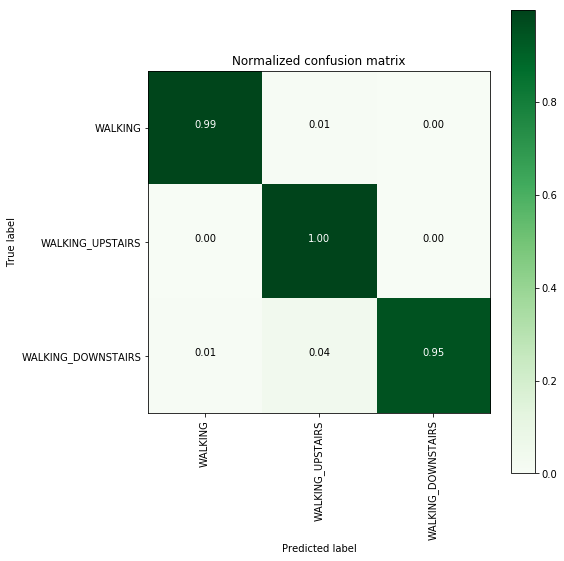

In [63]:
plt.figure(figsize=(8,8))
cm = confusion_matrix_cnn(Y_val_d, model_dyn.predict(X_val_d))
plot_confusion_matrix(cm, classes=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS'], 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

In [64]:
#saving model
model_dyn.save('final_model_dynamic.h5')

In [65]:
def data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    # Data directory
    DATADIR = 'UCI_HAR_Dataset'
    # Raw data signals
    # Signals are from Accelerometer and Gyroscope
    # The signals are in x,y,z directions
    # Sensor signals are filtered to have only body acceleration
    # excluding the acceleration due to gravity
    # Triaxial acceleration from the accelerometer is total acceleration
    SIGNALS = [
        "body_acc_x",
        "body_acc_y",
        "body_acc_z",
        "body_gyro_x",
        "body_gyro_y",
        "body_gyro_z",
        "total_acc_x",
        "total_acc_y",
        "total_acc_z"
        ]
    # Utility function to read the data from csv file
    def _read_csv(filename):
        return pd.read_csv(filename, delim_whitespace=True, header=None)

    # Utility function to load the load
    def load_signals(subset):
        signals_data = []

        for signal in SIGNALS:
            filename = f'UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
            signals_data.append( _read_csv(filename).as_matrix()) 

        # Transpose is used to change the dimensionality of the output,
        # aggregating the signals by combination of sample/timestep.
        # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
        return np.transpose(signals_data, (1, 2, 0))
    
    def load_y(subset):
        """
        The objective that we are trying to predict is a integer, from 1 to 6,
        that represents a human activity. We return a binary representation of 
        every sample objective as a 6 bits vector using One Hot Encoding
        (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
        """
        filename = f'UCI_HAR_Dataset/{subset}/y_{subset}.txt'
        y = _read_csv(filename)[0]
        return y
    
    X_train, X_val = load_signals('train'), load_signals('test')
    Y_train, Y_val = load_y('train'), load_y('test')

    return X_train, Y_train, X_val,  Y_val

In [66]:
X_train, Y_train, X_val,  Y_val = data()
print('shape of test Y',Y_val.shape)

C:\Users\Raftaar Singh\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


shape of test Y (2947,)


### Final prediction pipeline

In [67]:
##loading keras models and picle files for scaling data 
from keras.models import load_model
import pickle
model_2class = load_model('final_model_2class.h5')
model_dynamic = load_model('final_model_dynamic.h5')
model_static = load_model('final_model_static.h5')
scale_2class = pickle.load(open('Scale_2class.p','rb'))
scale_static = pickle.load(open('Scale_static.p','rb'))
scale_dynamic = pickle.load(open('Scale_dynamic.p','rb'))

In [68]:
##scaling the data
def transform_data(X,scale):
    X_temp = X.reshape((X.shape[0] * X.shape[1], X.shape[2]))
    X_temp = scale.transform(X_temp)
    return X_temp.reshape(X.shape)

In [69]:
#predicting output activity
def predict_activity(X):
    ##predicting whether dynamic or static
    predict_2class = model_2class.predict(transform_data(X,scale_2class))
    Y_pred_2class =  np.argmax(predict_2class, axis=1)
    #static data filter
    X_static = X[Y_pred_2class==1]
    #dynamic data filter
    X_dynamic = X[Y_pred_2class==0]
    #predicting static activities
    predict_static = model_static.predict(transform_data(X_static,scale_static))
    predict_static = np.argmax(predict_static,axis=1)
    #adding 4 because need to get inal prediction lable as output
    predict_static = predict_static + 4
    #predicting dynamic activites
    predict_dynamic = model_dynamic.predict(transform_data(X_dynamic,scale_dynamic))
    predict_dynamic = np.argmax(predict_dynamic,axis=1)
    #adding 1 because need to get inal prediction lable as output
    predict_dynamic = predict_dynamic + 1
    ##appending final output to one list in the same sequence of input data
    i,j = 0,0 
    final_pred = []
    for mask in Y_pred_2class:
        if mask == 1:
            final_pred.append(predict_static[i])
            i = i + 1
        else:
            final_pred.append(predict_dynamic[j])
            j = j + 1 
    return final_pred

In [70]:
##predicting 
final_pred_val = predict_activity(X_val)
final_pred_train = predict_activity(X_train)

In [71]:
##accuracy of train and test
from sklearn.metrics import accuracy_score
print('Accuracy of train data',accuracy_score(Y_train,final_pred_train))
print('Accuracy of validation data',accuracy_score(Y_val,final_pred_val))

Accuracy of train data 0.963411316648531
Accuracy of validation data 0.9518154054971157


In [72]:
#confusion metric
cm = metrics.confusion_matrix(Y_val, final_pred_val,labels=range(1,7))
cm

array([[492,   1,   3,   0,   0,   0],
       [  3, 448,  20,   0,   0,   0],
       [  0,   1, 419,   0,   0,   0],
       [  0,   2,   0, 437,  52,   0],
       [  1,   0,   0,  59, 472,   0],
       [  0,   0,   0,   0,   0, 537]], dtype=int64)

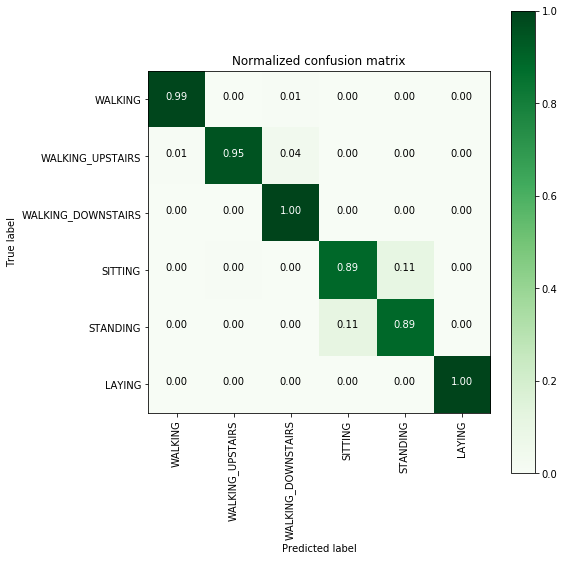

In [73]:
plt.figure(figsize=(8,8))
labels=['WALKING','WALKING_UPSTAIRS','WALKING_DOWNSTAIRS','SITTING','STANDING','LAYING']
plot_confusion_matrix(cm, classes=labels, 
                      normalize=True, title='Normalized confusion matrix', cmap = plt.cm.Greens)
plt.show()

# Overall Observation:

For this problem, require optimal parameters are........

- Using 2 layer Conv1D layer with large dropout rate and followed by 2 layer dense network, able to get desired accuracy

So using reference:
Divide and Conquer-Based 1D CNN Human Activity Recognition Using Test Data Sharpening
https://www.mdpi.com/1424-8220/18/4/1055/pdf

- Divide and Conquer approch with CNN is giving good result with final test accuracy of 0.9518154054971157 and train accuracy 0.96341131664853.
